# DryCreek watershed

In [1]:
watershed = 'DryCreek'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/2-DryCreek'

In [89]:
# function for aggregation(hourly) and combination
def aggre_and_comb_hourly(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(df.groupby(df.index).apply(lambda x: x.sum(skipna=False)),how ='outer')
            elif func == "mean":
                prep = prep.join(df.groupby(df.index).apply(lambda x: x.mean(skipna=False)),how ='outer')
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,df.groupby(df.index).apply(lambda x: x.sum(skipna=False))], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,df.groupby(df.index).apply(lambda x: x.mean(skipna=False))], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

In [86]:
# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,400), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-5,50), ### avoid unreasonable records
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

## Download the data from the original website

In [6]:
# https://www.boisestate.edu/drycreek/dry-creek-data/

#### Bogus Ridge Weather (BRW) Meteorological Station

In [7]:
# meteorology data
linklist =['http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2018.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2019.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Weather/Hourly%20Summary%20Data/BRW_HrlySummary_2020.csv']
BRW_met = pd.DataFrame()
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 19, sep = ',',index_col = 'DateTime')
    #display(data.head())
    data.columns = ['BRW_Precipitation', 'BRW_AirTemperature', 'BRW_SolarRadiation_regular',
       'BRW_SolarRadiation_net', 'BRW_RelativeHumidity', 'BRW_WindDirection',
       'BRW_WindSpeed', 'BRW_SnowDepth']
    BRW_met = copy.deepcopy(pd.concat([BRW_met,data], axis = 0))
BRW_met.head(3)

BRW_Precipitation BRW_AirTemperature  \
DateTime                                              
1/1/2011 0:00            -6999.0              -6999   
1/1/2011 1:00            -6999.0              -6999   
1/1/2011 2:00            -6999.0              -6999   

              BRW_SolarRadiation_regular BRW_SolarRadiation_net  \
DateTime                                                          
1/1/2011 0:00                      -6999                  -6999   
1/1/2011 1:00                      -6999                  -6999   
1/1/2011 2:00                      -6999                  -6999   

              BRW_RelativeHumidity  BRW_WindDirection BRW_WindSpeed  \
DateTime                                                              
1/1/2011 0:00                -6999            -6999.0         -6999   
1/1/2011 1:00                -6999            -6999.0         -6999   
1/1/2011 2:00                -6999            -6999.0         -6999   

               BRW_SnowDepth  
DateTime                      
1/1/2011 0:00        -6999.0  
1/1/2011 1:00        -6999.0  
1/1/2011 2:00        -6999.0

In [8]:
# soil data
BRW_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Soil/Hillslope/BRWhillslope_Soil_Lys_HrlySummary_2012_2017.csv',
       'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Soil/Hillslope/BRWhillslope_Soil_Lys_HrlySummary_2018.csv']
       #'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Soil/Hillslope/BRWhillslope_Soil_Lys_HrlySummary_2019.csv',
       #'http://icewater.boisestate.edu/boisefront-products/historical/dcew_br/Soil/Hillslope/BRWhillslope_Soil_Lys_HrlySummary_2020.csv']
for link in linklist:
    data = pd.read_csv(link, skiprows = 18, sep = ',',index_col = 'DateTime')
    # display(data.head())
    # L means lower, U means upper
    data.columns = ['BRW_SoilMoisture_L_5cm', 'BRW_SoilMoisture_L_15cm',
                    'BRW_SoilMoisture_L_30cm','BRW_SoilMoisture_L_81cm',
                    'BRW_SoilMoisture_U_5cm', 'BRW_SoilMoisture_U_15cm',
                    'BRW_SoilMoisture_U_30cm','BRW_SoilMoisture_U_55cm',
                    'BRW_SoilTemperature_L_5cm', 'BRW_SoilTemperature_L_15cm',
                    'BRW_SoilTemperature_L_30cm','BRW_SoilTemperature_L_81cm',
                    'BRW_SoilTemperature_U_5cm', 'BRW_SoilTemperature_U_15cm',
                    'BRW_SoilTemperature_U_30cm','BRW_SoilTemperature_U_55cm']
    BRW_soil = copy.deepcopy(pd.concat([BRW_soil,data], axis = 0))
BRW_soil.head(3)

BRW_SoilMoisture_L_5cm  BRW_SoilMoisture_L_15cm  \
DateTime                                                            
11/24/2012 10:00                   0.184                    0.204   
11/24/2012 10:15                   0.180                    0.202   
11/24/2012 10:30                   0.182                    0.204   

                  BRW_SoilMoisture_L_30cm  BRW_SoilMoisture_L_81cm  \
DateTime                                                             
11/24/2012 10:00                     0.19                    0.083   
11/24/2012 10:15                     0.19                    0.083   
11/24/2012 10:30                     0.19                    0.083   

                  BRW_SoilMoisture_U_5cm  BRW_SoilMoisture_U_15cm  \
DateTime                                                            
11/24/2012 10:00                   0.086                    0.156   
11/24/2012 10:15                   0.088                    0.156   
11/24/2012 10:30                   0.088                    0.152   

                  BRW_SoilMoisture_U_30cm  BRW_SoilMoisture_U_55cm  \
DateTime                                                             
11/24/2012 10:00                    0.208                    0.109   
11/24/2012 10:15                    0.208                    0.109   
11/24/2012 10:30                    0.208                    0.108   

                  BRW_SoilTemperature_L_5cm  BRW_SoilTemperature_L_15cm  \
DateTime                                                                  
11/24/2012 10:00                        0.3                         0.6   
11/24/2012 10:15                        0.3                         0.6   
11/24/2012 10:30                        0.3                         0.6   

                  BRW_SoilTemperature_L_30cm  BRW_SoilTemperature_L_81cm  \
DateTime                                                                   
11/24/2012 10:00                         1.6                         3.8   
11/24/2012 10:15                         1.6                         3.8   
11/24/2012 10:30                         1.6                         3.8   

                  BRW_SoilTemperature_U_5cm  BRW_SoilTemperature_U_15cm  \
DateTime                                                                  
11/24/2012 10:00                        0.0                         0.9   
11/24/2012 10:15                        0.0                         0.8   
11/24/2012 10:30                        0.0                         0.8   

                  BRW_SoilTemperature_U_30cm  BRW_SoilTemperature_U_55cm  
DateTime                                                                  
11/24/2012 10:00                         1.9                         3.3  
11/24/2012 10:15                         1.9                         3.3  
11/24/2012 10:30                         1.9                         3.3

#### Lower Deer Point (LDP)

In [9]:
# meteorology data
linklist =['http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2018.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Weather/Hourly%20Summary%20Data/LDP_HrlySummary_2019.csv']
LDP_met = pd.DataFrame()
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 19, sep = ',',index_col = 'DateTime')
    if i<5:
        data.drop(columns = ['Unnamed: 9', 'Unnamed: 10','Unnamed: 11'], inplace = True)
    #print(data.columns)
    #display(data.head())
    data.columns = ['LDP_Precipitation', 'LDP_AirTemperature', 'LDP_SolarRadiation_regular',
                   'LDP_SolarRadiation_net', 'LDP_RelativeHumidity', 'LDP_WindDirection',
                   'LDP_WindSpeed', 'LDP_SnowDepth']
    LDP_met = copy.deepcopy(pd.concat([LDP_met,data], axis = 0))
display(LDP_met.head(3))
LDP_met.tail(3)

LDP_Precipitation  LDP_AirTemperature  \
DateTime                                                
01/01/07 00:00            -6999.0             -6999.0   
01/01/07 01:00            -6999.0             -6999.0   
01/01/07 02:00            -6999.0             -6999.0   

                LDP_SolarRadiation_regular  LDP_SolarRadiation_net  \
DateTime                                                             
01/01/07 00:00                     -6999.0                 -6999.0   
01/01/07 01:00                     -6999.0                 -6999.0   
01/01/07 02:00                     -6999.0                 -6999.0   

                LDP_RelativeHumidity  LDP_WindDirection  LDP_WindSpeed  \
DateTime                                                                 
01/01/07 00:00               -6999.0            -6999.0        -6999.0   
01/01/07 01:00               -6999.0            -6999.0        -6999.0   
01/01/07 02:00               -6999.0            -6999.0        -6999.0   

                LDP_SnowDepth  
DateTime                       
01/01/07 00:00        -6999.0  
01/01/07 01:00        -6999.0  
01/01/07 02:00        -6999.0

LDP_Precipitation  LDP_AirTemperature  \
DateTime                                                  
12/31/2019 21:00              167.5                -1.2   
12/31/2019 22:00              167.9                -1.1   
12/31/2019 23:00              168.7                -0.3   

                  LDP_SolarRadiation_regular  LDP_SolarRadiation_net  \
DateTime                                                               
12/31/2019 21:00                         0.0                    1.20   
12/31/2019 22:00                         0.0                   -0.26   
12/31/2019 23:00                         0.0                    1.02   

                  LDP_RelativeHumidity  LDP_WindDirection  LDP_WindSpeed  \
DateTime                                                                   
12/31/2019 21:00                  94.7              193.5           1.02   
12/31/2019 22:00                  96.6              147.8           1.11   
12/31/2019 23:00                  91.7              214.9           1.47   

                  LDP_SnowDepth  
DateTime                         
12/31/2019 21:00          27.31  
12/31/2019 22:00          28.82  
12/31/2019 23:00          29.52

In [10]:
# soil data
LDP_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Soil/LDP_SoilHrlySummary_2007_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Soil/LDP_SoilHrlySummary_2017.csv']
           #'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Soil/LDP_SoilHrlySummary_2018.csv',
           #'http://icewater.boisestate.edu/boisefront-products/historical/dcew_ldp/Soil/LDP_SoilHrlySummary_2019.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 21, sep = ',',index_col = 'DateTime')
    #display(data.head(3))
    # W means west, E means east
    data.columns = ['LDP_SoilMoisture_W_8cm', 'LDP_SoilMoisture_E_8cm',
                    'LDP_SoilTemperature_W_2cm', 'LDP_SoilTemperature_W_6cm',
                    'LDP_SoilTemperature_E_2cm','LDP_SoilTemperature_E_6cm',
                    'LDP_SoilTemperature_2.5cm', 'LDP_SoilTemperature_20cm','LDP_SoilTemperature_33cm']
    LDP_soil = copy.deepcopy(pd.concat([LDP_soil,data], axis = 0))
display(LDP_soil.head(3))
LDP_soil.tail(3)

LDP_SoilMoisture_W_8cm  LDP_SoilMoisture_E_8cm  \
DateTime                                                        
1/1/2007 0:00                 -6999.0                 -6999.0   
1/1/2007 1:00                 -6999.0                 -6999.0   
1/1/2007 2:00                 -6999.0                 -6999.0   

               LDP_SoilTemperature_W_2cm  LDP_SoilTemperature_W_6cm  \
DateTime                                                              
1/1/2007 0:00                    -6999.0                    -6999.0   
1/1/2007 1:00                    -6999.0                    -6999.0   
1/1/2007 2:00                    -6999.0                    -6999.0   

               LDP_SoilTemperature_E_2cm  LDP_SoilTemperature_E_6cm  \
DateTime                                                              
1/1/2007 0:00                    -6999.0                    -6999.0   
1/1/2007 1:00                    -6999.0                    -6999.0   
1/1/2007 2:00                    -6999.0                    -6999.0   

               LDP_SoilTemperature_2.5cm  LDP_SoilTemperature_20cm  \
DateTime                                                             
1/1/2007 0:00                    -6999.0                   -6999.0   
1/1/2007 1:00                    -6999.0                   -6999.0   
1/1/2007 2:00                    -6999.0                   -6999.0   

               LDP_SoilTemperature_33cm  
DateTime                                 
1/1/2007 0:00                   -6999.0  
1/1/2007 1:00                   -6999.0  
1/1/2007 2:00                   -6999.0

LDP_SoilMoisture_W_8cm  LDP_SoilMoisture_E_8cm  \
DateTime                                                           
12/31/2017 21:00                   0.156                   0.133   
12/31/2017 22:00                   0.155                   0.132   
12/31/2017 23:00                   0.155                   0.132   

                  LDP_SoilTemperature_W_2cm  LDP_SoilTemperature_W_6cm  \
DateTime                                                                 
12/31/2017 21:00                   0.569537                   0.922216   
12/31/2017 22:00                   0.610533                   0.984948   
12/31/2017 23:00                   0.653897                   1.002167   

                  LDP_SoilTemperature_E_2cm  LDP_SoilTemperature_E_6cm  \
DateTime                                                                 
12/31/2017 21:00                   0.858371                   1.020868   
12/31/2017 22:00                   0.919662                   1.073437   
12/31/2017 23:00                   0.929628                   1.108057   

                  LDP_SoilTemperature_2.5cm  LDP_SoilTemperature_20cm  \
DateTime                                                                
12/31/2017 21:00                   0.659542                  1.457347   
12/31/2017 22:00                   0.719399                  1.498277   
12/31/2017 23:00                   0.748241                  1.534316   

                  LDP_SoilTemperature_33cm  
DateTime                                    
12/31/2017 21:00                  2.044101  
12/31/2017 22:00                  2.113944  
12/31/2017 23:00                  2.131115

#### Shingle Creek Ridge (SCR)

In [11]:
# meteorology data
linklist=['http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2010.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2011.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2012.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2013.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2014.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2015.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2016.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2017.csv',
          'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/weather/hourly%20summary%20data/SCR_HrlySummary_2018.csv']
SCR_met = pd.DataFrame()
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i in [0,1,2,3,4,5,7]:
        data = pd.read_csv(link, skiprows = 19, sep = ',',index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',',index_col = 'DateTime')
    #display(data.head())
    if i<3:
        data.drop(columns = ['Unnamed: 9', 'Unnamed: 10','Unnamed: 11'], inplace = True)
    #print(data.columns)
    data.columns = ['SCR_Precipitation', 'SCR_AirTemperature', 'SCR_SolarRadiation_regular',
                  'SCR_SolarRadiation_net', 'SCR_RelativeHumidity', 'SCR_WindDirection',
                  'SCR_WindSpeed', 'SCR_SnowDepth']
    SCR_met = copy.deepcopy(pd.concat([SCR_met,data], axis = 0))
display(SCR_met.head(3))
SCR_met.tail(3)

SCR_Precipitation  SCR_AirTemperature  \
DateTime                                                  
01/01/2010 00:00            -6999.0             -6999.0   
01/01/2010 01:00            -6999.0             -6999.0   
01/01/2010 02:00            -6999.0             -6999.0   

                  SCR_SolarRadiation_regular SCR_SolarRadiation_net  \
DateTime                                                              
01/01/2010 00:00                     -6999.0                  -6999   
01/01/2010 01:00                     -6999.0                  -6999   
01/01/2010 02:00                     -6999.0                  -6999   

                  SCR_RelativeHumidity  SCR_WindDirection  SCR_WindSpeed  \
DateTime                                                                   
01/01/2010 00:00               -6999.0            -6999.0        -6999.0   
01/01/2010 01:00               -6999.0            -6999.0        -6999.0   
01/01/2010 02:00               -6999.0            -6999.0        -6999.0   

                 SCR_SnowDepth  
DateTime                        
01/01/2010 00:00         -6999  
01/01/2010 01:00         -6999  
01/01/2010 02:00         -6999

SCR_Precipitation  SCR_AirTemperature  \
DateTime                                                  
10/15/2018 11:00                0.0                 5.0   
10/15/2018 12:00                0.0                 5.6   
10/15/2018 13:00                0.0                 6.2   

                  SCR_SolarRadiation_regular SCR_SolarRadiation_net  \
DateTime                                                              
10/15/2018 11:00                       478.6                  273.5   
10/15/2018 12:00                       563.6                  337.1   
10/15/2018 13:00                       627.4                  390.2   

                  SCR_RelativeHumidity  SCR_WindDirection  SCR_WindSpeed  \
DateTime                                                                   
10/15/2018 11:00                 36.10              238.3           1.67   
10/15/2018 12:00                 37.93              257.9           1.76   
10/15/2018 13:00                 41.07              248.3           1.89   

                 SCR_SnowDepth  
DateTime                        
10/15/2018 11:00          8.99  
10/15/2018 12:00          9.05  
10/15/2018 13:00          7.48

In [12]:
# soil data
SCR_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/Soil/DCEW_ShingleCreekRidgeSoilData2012_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_scr/Soil/DCEW_ShingleCreekRidgeSoilData2018.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 14, sep = ',',index_col = 'DateTime')
    #display(data.head(3))
    data.columns = ['SCR_SoilMoisture_5cm','SCR_SoilTemperature_5cm']
    SCR_soil = copy.deepcopy(pd.concat([SCR_soil,data], axis = 0))
display(SCR_soil.head(3))
SCR_soil.tail(3)

SCR_SoilMoisture_5cm  SCR_SoilTemperature_5cm
DateTime                                                    
1/1/2012 0:00               -6999.0                  -6999.0
1/1/2012 1:00               -6999.0                  -6999.0
1/1/2012 2:00               -6999.0                  -6999.0

SCR_SoilMoisture_5cm  SCR_SoilTemperature_5cm
DateTime                                                     
5/21/2018 7:00                 0.167                     11.0
5/21/2018 8:00                 0.166                     10.7
5/21/2018 9:00                 0.165                     11.1

#### Treeline (TL) station

In [13]:
# meteorology data
linklist=['http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_1999.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2000.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2001.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2002.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2003.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2004.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2005.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2006.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2007.csv',       
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2008.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2009.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2010.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2011.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2012.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2013.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2014.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2015.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2016.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2017.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2018.csv']
        # 'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Weather/Hourly%20Summary%20Data/Treeline_HrlySummary_2019.csv',]
TL_met = pd.DataFrame()
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 19, sep = ',',index_col = 'DateTime')
    #display(data.head())
    data = copy.deepcopy(data.iloc[:,0:8])
    #print(data.columns)
    data.columns = ['TL_Precipitation', 'TL_AirTemperature', 'TL_SolarRadiation_regular',
                  'TL_SolarRadiation_net', 'TL_RelativeHumidity', 'TL_WindDirection',
                  'TL_WindSpeed', 'TL_SnowDepth']
    TL_met = copy.deepcopy(pd.concat([TL_met,data], axis = 0))
display(TL_met.head(3))
TL_met.tail(3)

TL_Precipitation  TL_AirTemperature  \
DateTime                                              
01/01/99 00:00           -6999.0            -6999.0   
01/01/99 01:00           -6999.0            -6999.0   
01/01/99 02:00           -6999.0            -6999.0   

                TL_SolarRadiation_regular TL_SolarRadiation_net  \
DateTime                                                          
01/01/99 00:00                    -6999.0                 -6999   
01/01/99 01:00                    -6999.0                 -6999   
01/01/99 02:00                    -6999.0                 -6999   

                TL_RelativeHumidity  TL_WindDirection  TL_WindSpeed  \
DateTime                                                              
01/01/99 00:00              -6999.0           -6999.0       -6999.0   
01/01/99 01:00              -6999.0           -6999.0       -6999.0   
01/01/99 02:00              -6999.0           -6999.0       -6999.0   

               TL_SnowDepth  
DateTime                     
01/01/99 00:00        -6999  
01/01/99 01:00        -6999  
01/01/99 02:00        -6999

TL_Precipitation  TL_AirTemperature  \
DateTime                                                
10/15/2018 10:00             139.3                6.9   
10/15/2018 11:00             139.4                7.3   
10/15/2018 12:00             139.2                7.7   

                  TL_SolarRadiation_regular TL_SolarRadiation_net  \
DateTime                                                            
10/15/2018 10:00                      416.6                233.35   
10/15/2018 11:00                      551.9                352.32   
10/15/2018 12:00                      637.6                433.15   

                  TL_RelativeHumidity  TL_WindDirection  TL_WindSpeed  \
DateTime                                                                
10/15/2018 10:00                31.72             322.9          0.76   
10/15/2018 11:00                36.14             232.9          0.76   
10/15/2018 12:00                37.98              38.4          1.03   

                 TL_SnowDepth  
DateTime                       
10/15/2018 10:00         1.57  
10/15/2018 11:00         1.77  
10/15/2018 12:00         1.93

In [14]:
# Stream data (longer record available upon request)
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Streamflow/TL_StreamHrlySummary_2018.csv']
TL_str = pd.DataFrame()
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 18, sep = ',',index_col = 'DateTime')
    #display(data.head())
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['TL_Discharge']
    TL_str = copy.deepcopy(pd.concat([TL_str,data], axis = 0))
display(TL_str.head(3))
TL_str.tail(3)

TL_Discharge
DateTime                    
01/01/07 00:37           0.0
01/01/07 01:37           0.0
01/01/07 02:37           0.0

TL_Discharge
DateTime                      
12/31/2017 21:00           0.0
12/31/2017 22:00           0.0
12/31/2017 23:00           0.0

In [15]:
# soil data
# more is available for transect area
TL_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_1999.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2000.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2001.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2002.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2003.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2004.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2005.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_tl/Soil/TL_P3P4/TL_P3P4_SoilHrlySummary_2018.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 16:
        data = pd.read_csv(link, skiprows = 15, sep = ',', index_col = 'LocalDateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #print(data.columns)
    data.columns = ['TL_SoilMoisture_P3_5cm','TL_SoilMoisture_P3_15cm','TL_SoilMoisture_P3_30cm','TL_SoilMoisture_P3_60cm','TL_SoilMoisture_P3_100cm',
                    'TL_SoilMoisture_P4_5cm','TL_SoilMoisture_P4_15cm','TL_SoilMoisture_P4_30cm','TL_SoilMoisture_P4_45cm','TL_SoilMoisture_P4_65cm',
                    'TL_SoilTemperature_P3_5cm','TL_SoilTemperatureP3_15cm','TL_SoilTemperature_P3_30cm','TL_SoilTemperature_P3_60cm','TL_SoilTemperature_P3_100cm',
                    'TL_SoilTemperature_P4_5cm','TL_SoilTemperature_P4_15cm','TL_SoilTemperature_P4_30cm','TL_SoilTemperature_P4_45cm','TL_SoilTemperature_P4_65cm']
    TL_soil = copy.deepcopy(pd.concat([TL_soil,data], axis = 0))
display(TL_soil.head(3))
TL_soil.tail(3)

TL_SoilMoisture_P3_5cm  TL_SoilMoisture_P3_15cm  \
1/1/1999 0:00                 -6999.0                  -6999.0   
1/1/1999 1:00                 -6999.0                  -6999.0   
1/1/1999 2:00                 -6999.0                  -6999.0   

               TL_SoilMoisture_P3_30cm  TL_SoilMoisture_P3_60cm  \
1/1/1999 0:00                  -6999.0                  -6999.0   
1/1/1999 1:00                  -6999.0                  -6999.0   
1/1/1999 2:00                  -6999.0                  -6999.0   

               TL_SoilMoisture_P3_100cm  TL_SoilMoisture_P4_5cm  \
1/1/1999 0:00                   -6999.0                 -6999.0   
1/1/1999 1:00                   -6999.0                 -6999.0   
1/1/1999 2:00                   -6999.0                 -6999.0   

               TL_SoilMoisture_P4_15cm  TL_SoilMoisture_P4_30cm  \
1/1/1999 0:00                  -6999.0                  -6999.0   
1/1/1999 1:00                  -6999.0                  -6999.0   
1/1/1999 2:00                  -6999.0                  -6999.0   

               TL_SoilMoisture_P4_45cm  TL_SoilMoisture_P4_65cm  \
1/1/1999 0:00                  -6999.0                  -6999.0   
1/1/1999 1:00                  -6999.0                  -6999.0   
1/1/1999 2:00                  -6999.0                  -6999.0   

               TL_SoilTemperature_P3_5cm  TL_SoilTemperatureP3_15cm  \
1/1/1999 0:00                    -6999.0                    -6999.0   
1/1/1999 1:00                    -6999.0                    -6999.0   
1/1/1999 2:00                    -6999.0                    -6999.0   

               TL_SoilTemperature_P3_30cm  TL_SoilTemperature_P3_60cm  \
1/1/1999 0:00                     -6999.0                     -6999.0   
1/1/1999 1:00                     -6999.0                     -6999.0   
1/1/1999 2:00                     -6999.0                     -6999.0   

              TL_SoilTemperature_P3_100cm  TL_SoilTemperature_P4_5cm  \
1/1/1999 0:00                       -6999                    -6999.0   
1/1/1999 1:00                       -6999                    -6999.0   
1/1/1999 2:00                       -6999                    -6999.0   

               TL_SoilTemperature_P4_15cm  TL_SoilTemperature_P4_30cm  \
1/1/1999 0:00                     -6999.0                     -6999.0   
1/1/1999 1:00                     -6999.0                     -6999.0   
1/1/1999 2:00                     -6999.0                     -6999.0   

               TL_SoilTemperature_P4_45cm  TL_SoilTemperature_P4_65cm  
1/1/1999 0:00                     -6999.0                     -6999.0  
1/1/1999 1:00                     -6999.0                     -6999.0  
1/1/1999 2:00                     -6999.0                     -6999.0

TL_SoilMoisture_P3_5cm  TL_SoilMoisture_P3_15cm  \
12/31/2017 21:00                    0.15                    0.206   
12/31/2017 22:00                    0.15                    0.205   
12/31/2017 23:00                    0.15                    0.205   

                  TL_SoilMoisture_P3_30cm  TL_SoilMoisture_P3_60cm  \
12/31/2017 21:00                  -6999.0                     0.19   
12/31/2017 22:00                  -6999.0                     0.19   
12/31/2017 23:00                  -6999.0                     0.19   

                  TL_SoilMoisture_P3_100cm  TL_SoilMoisture_P4_5cm  \
12/31/2017 21:00                     0.084                -6999.00   
12/31/2017 22:00                     0.084                    0.12   
12/31/2017 23:00                     0.084                    0.06   

                  TL_SoilMoisture_P4_15cm  TL_SoilMoisture_P4_30cm  \
12/31/2017 21:00                    0.177                    0.147   
12/31/2017 22:00                    0.177                    0.147   
12/31/2017 23:00                    0.177                    0.147   

                  TL_SoilMoisture_P4_45cm  TL_SoilMoisture_P4_65cm  \
12/31/2017 21:00                    0.063                    0.054   
12/31/2017 22:00                    0.063                    0.054   
12/31/2017 23:00                    0.063                    0.054   

                  TL_SoilTemperature_P3_5cm  TL_SoilTemperatureP3_15cm  \
12/31/2017 21:00                        1.4                        1.9   
12/31/2017 22:00                        1.5                        2.0   
12/31/2017 23:00                        1.4                        2.0   

                  TL_SoilTemperature_P3_30cm  TL_SoilTemperature_P3_60cm  \
12/31/2017 21:00                         2.6                         4.2   
12/31/2017 22:00                         2.6                         4.2   
12/31/2017 23:00                         2.6                         4.2   

                 TL_SoilTemperature_P3_100cm  TL_SoilTemperature_P4_5cm  \
12/31/2017 21:00                         5.7                        1.0   
12/31/2017 22:00                         5.7                        1.0   
12/31/2017 23:00                         5.7                        1.0   

                  TL_SoilTemperature_P4_15cm  TL_SoilTemperature_P4_30cm  \
12/31/2017 21:00                         1.7                         2.6   
12/31/2017 22:00                         1.8                         2.6   
12/31/2017 23:00                         1.7                         2.6   

                  TL_SoilTemperature_P4_45cm  TL_SoilTemperature_P4_65cm  
12/31/2017 21:00                         3.4                         4.3  
12/31/2017 22:00                         3.5                         4.3  
12/31/2017 23:00                         3.4                         4.3

#### Lower Weather (LW)

In [21]:
# meteorology data
LW_met = pd.DataFrame()
linklist=['http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_1999.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2000.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2001.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2002.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2003.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2004.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2005.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2006.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2007.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2008.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2009.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2010.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2011.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2012.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2013.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2014.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2015.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2016.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2017.csv',
         'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Weather/Hourly%20Summary%20Data/LowerWeather_HrlySummary_2018.csv']
for i in range(len(linklist)):
    link = linklist[i]
    if i == 17:
        data = pd.read_csv(link, skiprows = 20, sep = ',',index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 19, sep = ',',index_col = 'DateTime')
    #display(data.head(2))
    data = copy.deepcopy(data.iloc[:,0:8])
    #print(data.columns)
    data.columns = ['LW_Precipitation', 'LW_AirTemperature', 'LW_SolarRadiation_regular',
                  'LW_SolarRadiation_net', 'LW_RelativeHumidity', 'LW_WindDirection',
                  'LW_WindSpeed', 'LW_SnowDepth']
    LW_met = copy.deepcopy(pd.concat([LW_met,data], axis = 0))    
display(LW_met.head(3))
LW_met.tail(3)  

LW_Precipitation  LW_AirTemperature  \
DateTime                                                
01/01/1999 00:00              0.00               2.27   
01/01/1999 01:00              0.00               2.62   
01/01/1999 02:00              0.02               2.29   

                  LW_SolarRadiation_regular  LW_SolarRadiation_net  \
DateTime                                                             
01/01/1999 00:00                    -6999.0                -6999.0   
01/01/1999 01:00                    -6999.0                -6999.0   
01/01/1999 02:00                    -6999.0                -6999.0   

                  LW_RelativeHumidity  LW_WindDirection  LW_WindSpeed  \
DateTime                                                                
01/01/1999 00:00                 79.9             320.7          3.33   
01/01/1999 01:00                 75.1             318.4          5.10   
01/01/1999 02:00                 73.5             305.3          5.41   

                 LW_SnowDepth  
DateTime                       
01/01/1999 00:00         0.45  
01/01/1999 01:00         0.52  
01/01/1999 02:00         0.93

LW_Precipitation  LW_AirTemperature  \
DateTime                                                
10/15/2018 11:00              66.1               -7.8   
10/15/2018 12:00              65.8               -6.4   
10/15/2018 13:00              65.8               -7.0   

                  LW_SolarRadiation_regular  LW_SolarRadiation_net  \
DateTime                                                             
10/15/2018 11:00                        0.0                -6999.0   
10/15/2018 12:00                        0.0                -6999.0   
10/15/2018 13:00                        0.0                -6999.0   

                  LW_RelativeHumidity  LW_WindDirection  LW_WindSpeed  \
DateTime                                                                
10/15/2018 11:00               -68.13             217.1          1.47   
10/15/2018 12:00               -68.00             259.3          2.20   
10/15/2018 13:00               -68.48             257.3          3.09   

                 LW_SnowDepth  
DateTime                       
10/15/2018 11:00        -2.51  
10/15/2018 12:00        -2.17  
10/15/2018 13:00        -2.51

In [22]:
# soil data
# more is available for transect area
LW_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_1999.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2000.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2001.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2002.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2003.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2004.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2005.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lw/Soil/LW_P1P2_SoilHrlySummary_2018.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i > 17:
        data = pd.read_csv(link, skiprows = 15, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data.columns = ['LW_SoilMoisture_P1_5cm','LW_SoilMoisture_P1_15cm','LW_SoilMoisture_P1_30cm',
                    'LW_SoilMoisture_P1_50cm','LW_SoilMoisture_P1_100cm',
                   'LW_SoilMoisture_P2_5cm','LW_SoilMoisture_P2_15cm','LW_SoilMoisture_P2_30cm',
                    'LW_SoilMoisture_P2_60cm','LW_SoilMoisture_P2_100cm',
                   'LW_SoilTemperature_P1_5cm','LW_SoilTemperature_P1_15cm','LW_SoilTemperature_P1_30cm',
                    'LW_SoilTemperature_P1_50cm','LW_SoilTemperature_P1_100cm',
                   'LW_SoilTemperature_P2_5cm','LW_SoilTemperature_P2_15cm','LW_SoilTemperature_P2_30cm',
                    'LW_SoilTemperature_P2_60cm','LW_SoilTemperature_P2_100cm']
    LW_soil = copy.deepcopy(pd.concat([LW_soil,data], axis = 0))
display(LW_soil.head(3))
LW_soil.tail(3)

LW_SoilMoisture_P1_5cm  LW_SoilMoisture_P1_15cm  \
DateTime                                                            
01/01/1999 00:00                   0.239                    0.259   
01/01/1999 01:00                   0.239                    0.259   
01/01/1999 02:00                   0.237                    0.259   

                  LW_SoilMoisture_P1_30cm  LW_SoilMoisture_P1_50cm  \
DateTime                                                             
01/01/1999 00:00                    0.238                    0.039   
01/01/1999 01:00                    0.238                    0.039   
01/01/1999 02:00                    0.238                    0.039   

                  LW_SoilMoisture_P1_100cm  LW_SoilMoisture_P2_5cm  \
DateTime                                                             
01/01/1999 00:00                     0.076                   0.289   
01/01/1999 01:00                     0.076                   0.285   
01/01/1999 02:00                     0.076                   0.279   

                  LW_SoilMoisture_P2_15cm  LW_SoilMoisture_P2_30cm  \
DateTime                                                             
01/01/1999 00:00                    0.280                    0.157   
01/01/1999 01:00                    0.279                    0.158   
01/01/1999 02:00                    0.279                    0.161   

                  LW_SoilMoisture_P2_60cm  LW_SoilMoisture_P2_100cm  \
DateTime                                                              
01/01/1999 00:00                     0.01                     0.057   
01/01/1999 01:00                     0.01                     0.057   
01/01/1999 02:00                     0.01                     0.057   

                  LW_SoilTemperature_P1_5cm  LW_SoilTemperature_P1_15cm  \
DateTime                                                                  
01/01/1999 00:00                       -0.1                     -6999.0   
01/01/1999 01:00                        0.3                     -6999.0   
01/01/1999 02:00                        0.3                     -6999.0   

                  LW_SoilTemperature_P1_30cm  LW_SoilTemperature_P1_50cm  \
DateTime                                                                   
01/01/1999 00:00                     -6999.0                     -6999.0   
01/01/1999 01:00                     -6999.0                     -6999.0   
01/01/1999 02:00                     -6999.0                     -6999.0   

                  LW_SoilTemperature_P1_100cm  LW_SoilTemperature_P2_5cm  \
DateTime                                                                   
01/01/1999 00:00                      -6999.0                    -6999.0   
01/01/1999 01:00                      -6999.0                    -6999.0   
01/01/1999 02:00                      -6999.0                    -6999.0   

                  LW_SoilTemperature_P2_15cm  LW_SoilTemperature_P2_30cm  \
DateTime                                                                   
01/01/1999 00:00                     -6999.0                     -6999.0   
01/01/1999 01:00                     -6999.0                     -6999.0   
01/01/1999 02:00                     -6999.0                     -6999.0   

                  LW_SoilTemperature_P2_60cm  LW_SoilTemperature_P2_100cm  
DateTime                                                                   
01/01/1999 00:00                     -6999.0                      -6999.0  
01/01/1999 01:00                     -6999.0                      -6999.0  
01/01/1999 02:00                     -6999.0                      -6999.0

LW_SoilMoisture_P1_5cm  LW_SoilMoisture_P1_15cm  \
DateTime                                                            
12/31/2017 21:00                   0.147                    0.229   
12/31/2017 22:00                   0.146                    0.228   
12/31/2017 23:00                   0.145                    0.228   

                  LW_SoilMoisture_P1_30cm  LW_SoilMoisture_P1_50cm  \
DateTime                                                             
12/31/2017 21:00                  -6999.0                  -6999.0   
12/31/2017 22:00                  -6999.0                  -6999.0   
12/31/2017 23:00                  -6999.0                  -6999.0   

                  LW_SoilMoisture_P1_100cm  LW_SoilMoisture_P2_5cm  \
DateTime                                                             
12/31/2017 21:00                     0.087                   0.183   
12/31/2017 22:00                     0.087                   0.182   
12/31/2017 23:00                     0.087                   0.181   

                  LW_SoilMoisture_P2_15cm  LW_SoilMoisture_P2_30cm  \
DateTime                                                             
12/31/2017 21:00                    0.134                    0.077   
12/31/2017 22:00                    0.135                    0.077   
12/31/2017 23:00                    0.135                    0.077   

                  LW_SoilMoisture_P2_60cm  LW_SoilMoisture_P2_100cm  \
DateTime                                                              
12/31/2017 21:00                    0.051                 -6999.000   
12/31/2017 22:00                    0.051                     0.055   
12/31/2017 23:00                    0.051                 -6999.000   

                  LW_SoilTemperature_P1_5cm  LW_SoilTemperature_P1_15cm  \
DateTime                                                                  
12/31/2017 21:00                        0.6                         1.2   
12/31/2017 22:00                        0.6                         1.2   
12/31/2017 23:00                        0.6                         1.1   

                  LW_SoilTemperature_P1_30cm  LW_SoilTemperature_P1_50cm  \
DateTime                                                                   
12/31/2017 21:00                         2.2                         3.2   
12/31/2017 22:00                         2.2                         3.2   
12/31/2017 23:00                         2.1                         3.1   

                  LW_SoilTemperature_P1_100cm  LW_SoilTemperature_P2_5cm  \
DateTime                                                                   
12/31/2017 21:00                          6.0                        0.0   
12/31/2017 22:00                          5.9                        0.0   
12/31/2017 23:00                          5.9                        0.0   

                  LW_SoilTemperature_P2_15cm  LW_SoilTemperature_P2_30cm  \
DateTime                                                                   
12/31/2017 21:00                         0.8                     -6999.0   
12/31/2017 22:00                         0.8                     -6999.0   
12/31/2017 23:00                         0.8                     -6999.0   

                  LW_SoilTemperature_P2_60cm  LW_SoilTemperature_P2_100cm  
DateTime                                                                   
12/31/2017 21:00                         3.7                          5.9  
12/31/2017 22:00                         3.7                          5.9  
12/31/2017 23:00                         3.6                          5.9

#### Bogus South Gauge (BSG)

In [23]:
# Stream data
BSG_str = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_bsg/StreamHourlyData/BSG_StreamHrlySummary_2018.csv'
           ]
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    #else:
    data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['BSG_Discharge']
    BSG_str = copy.deepcopy(pd.concat([BSG_str,data], axis = 0))
display(BSG_str.head(3))
BSG_str.tail(3)    


BSG_Discharge
DateTime                    
1/1/2006 0:00        -6999.0
1/1/2006 1:00        -6999.0
1/1/2006 2:00        -6999.0

BSG_Discharge
DateTime                      
3/13/2018 9:00            1.38
3/13/2018 10:00           1.41
3/13/2018 11:00           1.41

#### Lower Gauge (LG)

In [25]:
# Stream data
LG_str = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_1999.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2000.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2001.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2002.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2003.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2004.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2005.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2018.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_lg/StreamHourlyData/LG_StreamHrlySummary_2019.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    #else:
    data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['LG_Discharge']
    LG_str = copy.deepcopy(pd.concat([LG_str,data], axis = 0))
display(LG_str.head(3))
LG_str.tail(3)


LG_Discharge
DateTime                  
1/1/1999 0:00        -6999
1/1/1999 1:00        -6999
1/1/1999 2:00        -6999

LG_Discharge
DateTime                     
12/31/2019 21:00        60.03
12/31/2019 22:00        60.54
12/31/2019 23:00        61.06

#### Con1East (C1E)

In [26]:
# Stream data
C1E_str = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2004.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2005.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2006.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2007.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2008.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2009.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2010.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2011.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2012.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2013.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2014.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2015.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2016.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2017.csv',
            'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1e/StreamHourlyData/C1e_StreamHrlySummary_2018.csv']

for i in range(len(linklist)):
    print(i)
    link = linklist[i]
    #else:
    data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['C1E_Discharge']
    C1E_str = copy.deepcopy(pd.concat([C1E_str,data], axis = 0))
display(C1E_str.head(3))
C1E_str.tail(3) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


C1E_Discharge
DateTime                     
01/01/04 00:00        -6999.0
01/01/04 01:00        -6999.0
01/01/04 02:00        -6999.0

C1E_Discharge
DateTime                      
3/12/2018 11:00          27.14
3/12/2018 12:00          26.19
3/12/2018 13:00          29.12

#### Con1West (C1W)

In [27]:
# Stream data
C1W_str = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2004.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2005.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c1w/StreamHourlyData/C1W_StreamHrlySummary_2018.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['C1W_Discharge']
    C1W_str = copy.deepcopy(pd.concat([C1W_str,data], axis = 0))
display(C1W_str.head(3))
C1W_str.tail(3) 

C1W_Discharge
DateTime                    
01/01/04 00:00         -6999
01/01/04 01:00         -6999
01/01/04 02:00         -6999

C1W_Discharge
DateTime                     
3/12/2018 11:00         28.43
3/12/2018 12:00         25.86
3/12/2018 13:00         20.41

#### Con2East (C2E)

In [28]:
# Stream data
C2E_str = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2004.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2005.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2e/StreamHourlyData/C2E_StreamHrlySummary_2018.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['C2E_Discharge']
    C2E_str = copy.deepcopy(pd.concat([C2E_str,data], axis = 0))
display(C2E_str.head(3))
display(C2E_str.tail(3))
#C2E_dis.plot()

C2E_Discharge
DateTime                     
01/01/04 00:00        -6999.0
01/01/04 01:00        -6999.0
01/01/04 02:00        -6999.0

C2E_Discharge
DateTime                     
3/7/2018 11:00          14.95
3/7/2018 12:00          14.60
3/7/2018 13:00          13.88

#### Con2Main (C2M)

In [29]:
# Stream data
C2M_str = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2004.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2005.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2006.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2007.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2017.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew_c2m/StreamHourlyData/C2M_StreamHrlySummary_2018.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')
    #display(data.head(4))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,[0]])
    data.columns = ['C2M_Discharge']
    C2M_str = copy.deepcopy(pd.concat([C2M_str,data], axis = 0))
display(C2M_str.head(3))
display(C2M_str.tail(3))
#C2M_dis.plot()

C2M_Discharge
DateTime                     
01/01/04 00:00        -6999.0
01/01/04 01:00        -6999.0
01/01/04 02:00        -6999.0

C2M_Discharge
DateTime                     
1/1/2018 21:00        -6999.0
1/1/2018 22:00        -6999.0
1/1/2018 23:00        -6999.0

#### Soil Station: High N-Facing (HN)

In [30]:
# Soil data
HN_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HN/HN_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 8:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime') 
    display(data.head(4))
    data = copy.deepcopy(data.iloc[:,0:32])
    display(data.head(4))
    data.columns = ['HN_SoilMoisture_Pit1_2cm', 'HN_SoilMoisture_Pit1_15cm', 'HN_SoilMoisture_Pit1_30cm', 'HN_SoilMoisture_Pit1_37cmBdrk',
       'HN_SoilMoisture_Pit2_2cm', 'HN_SoilMoisture_Pit2_15cm', 'HN_SoilMoisture_Pit2_30cm', 'HN_SoilMoisture_Pit2_42cmBdrk',
       'HN_SoilMoisture_Pit3_2cm', 'HN_SoilMoisture_Pit3_15cm', 'HN_SoilMoisture_Pit3_30cm', 'HN_SoilMoisture_Pit3_54cmBdrk',
       'HN_SoilMoisture_Pit4_2cm', 'HN_SoilMoisture_Pit4_15cm', 'HN_SoilMoisture_Pit4_30cm', 'HN_SoilMoisture_Pit4_45cmBdrk',
       'HN_SoilTemperature_Pit1_2cm', 'HN_SoilTemperature_Pit1_15cm', 'HN_SoilTemperature_Pit1_30cm', 'HN_SoilTemperature_Pit1_37cmBdrk',
       'HN_SoilTemperature_Pit2_2cm', 'HN_SoilTemperature_Pit2_15cm', 'HN_SoilTemperature_Pit2_30cm', 'HN_SoilTemperature_Pit2_42cmBdrk',
       'HN_SoilTemperature_Pit3_2cm', 'HN_SoilTemperature_Pit3_15cm', 'HN_SoilTemperature_Pit3_30cm', 'HN_SoilTemperature_Pit3_54cmBdrk',
       'HN_SoilTemperature_Pit4_2cm', 'HN_SoilTemperature_Pit4_15cm', 'HN_SoilTemperature_Pit4_30cm', 'HN_SoilTemperature_Pit4_45cmBdrk']
    HN_soil = copy.deepcopy(pd.concat([HN_soil,data], axis = 0))
display(HN_soil.head(3))
display(HN_soil.tail(3))
#HN_soil.plot()

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2008 00:00       -6999.0        -6999.0        -6999.0   
01/01/2008 01:00       -6999.0        -6999.0        -6999.0   
01/01/2008 02:00       -6999.0        -6999.0        -6999.0   
01/01/2008 03:00       -6999.0        -6999.0        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2008 00:00            -6999.0       -6999.0        -6999.0   
01/01/2008 01:00            -6999.0       -6999.0        -6999.0   
01/01/2008 02:00            -6999.0       -6999.0        -6999.0   
01/01/2008 03:00            -6999.0       -6999.0        -6999.0   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2008 00:00        -6999.0            -6999.0       -6999.0   
01/01/2008 01:00        -6999.0            -6999.0       -6999.0   
01/01/2008 02:00        -6999.0            -6999.0       -6999.0   
01/01/2008 03:00        -6999.0            -6999.0       -6999.0   

                  VWC_HNPit3_15  ...  Unnamed: 37  Unnamed: 38  Unnamed: 39  \
DateTime                         ...                                          
01/01/2008 00:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2008 01:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2008 02:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2008 03:00        -6999.0  ...          NaN          NaN          NaN   

                  Unnamed: 40  Unnamed: 41  Unnamed: 42  Unnamed: 43  \
DateTime                                                               
01/01/2008 00:00          NaN          NaN          NaN          NaN   
01/01/2008 01:00          NaN          NaN          NaN          NaN   
01/01/2008 02:00          NaN          NaN          NaN          NaN   
01/01/2008 03:00          NaN          NaN          NaN          NaN   

                  Unnamed: 44  Unnamed: 45  Unnamed: 46  
DateTime                                                 
01/01/2008 00:00          NaN          NaN          NaN  
01/01/2008 01:00          NaN          NaN          NaN  
01/01/2008 02:00          NaN          NaN          NaN  
01/01/2008 03:00          NaN          NaN          NaN  

[4 rows x 46 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2008 00:00       -6999.0        -6999.0        -6999.0   
01/01/2008 01:00       -6999.0        -6999.0        -6999.0   
01/01/2008 02:00       -6999.0        -6999.0        -6999.0   
01/01/2008 03:00       -6999.0        -6999.0        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2008 00:00            -6999.0       -6999.0        -6999.0   
01/01/2008 01:00            -6999.0       -6999.0        -6999.0   
01/01/2008 02:00            -6999.0       -6999.0        -6999.0   
01/01/2008 03:00            -6999.0       -6999.0        -6999.0   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2008 00:00        -6999.0            -6999.0       -6999.0   
01/01/2008 01:00        -6999.0            -6999.0       -6999.0   
01/01/2008 02:00        -6999.0            -6999.0       -6999.0   
01/01/2008 03:00        -6999.0            -6999.0       -6999.0   

                  VWC_HNPit3_15  ...  ST_HNPit2_30  ST_HNPit2_42Bdrk  \
DateTime                         ...                                   
01/01/2008 00:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2008 01:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2008 02:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2008 03:00        -6999.0  ...       -6999.0           -6999.0   

                  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  ST_HNPit3_54Bdrk  \
DateTime                                                                      
01/01/2008 00:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2008 01:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2008 02:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2008 03:00      -6999.0       -6999.0       -6999.0           -6999.0   

                  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  ST_HNPit4_45Bdrk  
DateTime                                                                     
01/01/2008 00:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2008 01:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2008 02:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2008 03:00      -6999.0       -6999.0       -6999.0           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2009 00:00         0.218          0.270          0.305   
01/01/2009 01:00         0.216          0.270          0.307   
01/01/2009 02:00         0.216          0.274          0.307   
01/01/2009 03:00         0.216          0.272          0.307   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2009 00:00              0.254         0.265          0.308   
01/01/2009 01:00              0.252         0.262          0.354   
01/01/2009 02:00              0.252         0.263          0.350   
01/01/2009 03:00              0.253         0.265          0.302   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2009 00:00          0.345              0.239         0.190   
01/01/2009 01:00          0.347              0.239         0.193   
01/01/2009 02:00          0.343              0.240         0.185   
01/01/2009 03:00          0.344              0.240         0.185   

                  VWC_HNPit3_15  ...  Unnamed: 37  Unnamed: 38  Unnamed: 39  \
DateTime                         ...                                          
01/01/2009 00:00          0.312  ...          NaN          NaN          NaN   
01/01/2009 01:00          0.303  ...          NaN          NaN          NaN   
01/01/2009 02:00          0.304  ...          NaN          NaN          NaN   
01/01/2009 03:00          0.303  ...          NaN          NaN          NaN   

                  Unnamed: 40  Unnamed: 41  Unnamed: 42  Unnamed: 43  \
DateTime                                                               
01/01/2009 00:00          NaN          NaN          NaN          NaN   
01/01/2009 01:00          NaN          NaN          NaN          NaN   
01/01/2009 02:00          NaN          NaN          NaN          NaN   
01/01/2009 03:00          NaN          NaN          NaN          NaN   

                  Unnamed: 44  Unnamed: 45  Unnamed: 46  
DateTime                                                 
01/01/2009 00:00          NaN          NaN          NaN  
01/01/2009 01:00          NaN          NaN          NaN  
01/01/2009 02:00          NaN          NaN          NaN  
01/01/2009 03:00          NaN          NaN          NaN  

[4 rows x 46 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2009 00:00         0.218          0.270          0.305   
01/01/2009 01:00         0.216          0.270          0.307   
01/01/2009 02:00         0.216          0.274          0.307   
01/01/2009 03:00         0.216          0.272          0.307   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2009 00:00              0.254         0.265          0.308   
01/01/2009 01:00              0.252         0.262          0.354   
01/01/2009 02:00              0.252         0.263          0.350   
01/01/2009 03:00              0.253         0.265          0.302   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2009 00:00          0.345              0.239         0.190   
01/01/2009 01:00          0.347              0.239         0.193   
01/01/2009 02:00          0.343              0.240         0.185   
01/01/2009 03:00          0.344              0.240         0.185   

                  VWC_HNPit3_15  ...  ST_HNPit2_30  ST_HNPit2_42Bdrk  \
DateTime                         ...                                   
01/01/2009 00:00          0.312  ...           2.1               2.9   
01/01/2009 01:00          0.303  ...           1.9               2.9   
01/01/2009 02:00          0.304  ...           1.9               2.9   
01/01/2009 03:00          0.303  ...           1.9               2.8   

                  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  ST_HNPit3_54Bdrk  \
DateTime                                                                      
01/01/2009 00:00          0.5           1.3           1.4               2.5   
01/01/2009 01:00          0.5           1.2           1.4               2.5   
01/01/2009 02:00          0.5           1.4           1.4               2.5   
01/01/2009 03:00          0.5           1.3           1.4               2.5   

                  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  ST_HNPit4_45Bdrk  
DateTime                                                                     
01/01/2009 00:00          1.1           1.7           1.8               2.4  
01/01/2009 01:00          1.1           1.5           2.1               2.4  
01/01/2009 02:00          1.1           1.7           2.0               2.4  
01/01/2009 03:00          1.1           1.8           1.9               2.4  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2010 00:00       -6999.0        -6999.0        -6999.0   
01/01/2010 01:00       -6999.0        -6999.0        -6999.0   
01/01/2010 02:00       -6999.0        -6999.0        -6999.0   
01/01/2010 03:00       -6999.0        -6999.0        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2010 00:00            -6999.0       -6999.0        -6999.0   
01/01/2010 01:00            -6999.0       -6999.0        -6999.0   
01/01/2010 02:00            -6999.0       -6999.0        -6999.0   
01/01/2010 03:00            -6999.0       -6999.0        -6999.0   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2010 00:00        -6999.0            -6999.0       -6999.0   
01/01/2010 01:00        -6999.0            -6999.0       -6999.0   
01/01/2010 02:00        -6999.0            -6999.0       -6999.0   
01/01/2010 03:00        -6999.0            -6999.0       -6999.0   

                  VWC_HNPit3_15  ...  Unnamed: 37  Unnamed: 38  Unnamed: 39  \
DateTime                         ...                                          
01/01/2010 00:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2010 01:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2010 02:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2010 03:00        -6999.0  ...          NaN          NaN          NaN   

                  Unnamed: 40  Unnamed: 41  Unnamed: 42  Unnamed: 43  \
DateTime                                                               
01/01/2010 00:00          NaN          NaN          NaN          NaN   
01/01/2010 01:00          NaN          NaN          NaN          NaN   
01/01/2010 02:00          NaN          NaN          NaN          NaN   
01/01/2010 03:00          NaN          NaN          NaN          NaN   

                  Unnamed: 44  Unnamed: 45  Unnamed: 46  
DateTime                                                 
01/01/2010 00:00          NaN          NaN          NaN  
01/01/2010 01:00          NaN          NaN          NaN  
01/01/2010 02:00          NaN          NaN          NaN  
01/01/2010 03:00          NaN          NaN          NaN  

[4 rows x 46 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2010 00:00       -6999.0        -6999.0        -6999.0   
01/01/2010 01:00       -6999.0        -6999.0        -6999.0   
01/01/2010 02:00       -6999.0        -6999.0        -6999.0   
01/01/2010 03:00       -6999.0        -6999.0        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2010 00:00            -6999.0       -6999.0        -6999.0   
01/01/2010 01:00            -6999.0       -6999.0        -6999.0   
01/01/2010 02:00            -6999.0       -6999.0        -6999.0   
01/01/2010 03:00            -6999.0       -6999.0        -6999.0   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2010 00:00        -6999.0            -6999.0       -6999.0   
01/01/2010 01:00        -6999.0            -6999.0       -6999.0   
01/01/2010 02:00        -6999.0            -6999.0       -6999.0   
01/01/2010 03:00        -6999.0            -6999.0       -6999.0   

                  VWC_HNPit3_15  ...  ST_HNPit2_30  ST_HNPit2_42Bdrk  \
DateTime                         ...                                   
01/01/2010 00:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2010 01:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2010 02:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2010 03:00        -6999.0  ...       -6999.0           -6999.0   

                  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  ST_HNPit3_54Bdrk  \
DateTime                                                                      
01/01/2010 00:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2010 01:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2010 02:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2010 03:00      -6999.0       -6999.0       -6999.0           -6999.0   

                  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  ST_HNPit4_45Bdrk  
DateTime                                                                     
01/01/2010 00:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2010 01:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2010 02:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2010 03:00      -6999.0       -6999.0       -6999.0           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2011 00:00       -6999.0        -6999.0        -6999.0   
01/01/2011 01:00       -6999.0        -6999.0        -6999.0   
01/01/2011 02:00       -6999.0        -6999.0        -6999.0   
01/01/2011 03:00       -6999.0        -6999.0        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2011 00:00            -6999.0       -6999.0        -6999.0   
01/01/2011 01:00            -6999.0       -6999.0        -6999.0   
01/01/2011 02:00            -6999.0       -6999.0        -6999.0   
01/01/2011 03:00            -6999.0       -6999.0        -6999.0   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2011 00:00        -6999.0            -6999.0       -6999.0   
01/01/2011 01:00        -6999.0            -6999.0       -6999.0   
01/01/2011 02:00        -6999.0            -6999.0       -6999.0   
01/01/2011 03:00        -6999.0            -6999.0       -6999.0   

                  VWC_HNPit3_15  ...  Unnamed: 37  Unnamed: 38  Unnamed: 39  \
DateTime                         ...                                          
01/01/2011 00:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2011 01:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2011 02:00        -6999.0  ...          NaN          NaN          NaN   
01/01/2011 03:00        -6999.0  ...          NaN          NaN          NaN   

                  Unnamed: 40  Unnamed: 41  Unnamed: 42  Unnamed: 43  \
DateTime                                                               
01/01/2011 00:00          NaN          NaN          NaN          NaN   
01/01/2011 01:00          NaN          NaN          NaN          NaN   
01/01/2011 02:00          NaN          NaN          NaN          NaN   
01/01/2011 03:00          NaN          NaN          NaN          NaN   

                  Unnamed: 44  Unnamed: 45  Unnamed: 46  
DateTime                                                 
01/01/2011 00:00          NaN          NaN          NaN  
01/01/2011 01:00          NaN          NaN          NaN  
01/01/2011 02:00          NaN          NaN          NaN  
01/01/2011 03:00          NaN          NaN          NaN  

[4 rows x 46 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2011 00:00       -6999.0        -6999.0        -6999.0   
01/01/2011 01:00       -6999.0        -6999.0        -6999.0   
01/01/2011 02:00       -6999.0        -6999.0        -6999.0   
01/01/2011 03:00       -6999.0        -6999.0        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2011 00:00            -6999.0       -6999.0        -6999.0   
01/01/2011 01:00            -6999.0       -6999.0        -6999.0   
01/01/2011 02:00            -6999.0       -6999.0        -6999.0   
01/01/2011 03:00            -6999.0       -6999.0        -6999.0   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2011 00:00        -6999.0            -6999.0       -6999.0   
01/01/2011 01:00        -6999.0            -6999.0       -6999.0   
01/01/2011 02:00        -6999.0            -6999.0       -6999.0   
01/01/2011 03:00        -6999.0            -6999.0       -6999.0   

                  VWC_HNPit3_15  ...  ST_HNPit2_30  ST_HNPit2_42Bdrk  \
DateTime                         ...                                   
01/01/2011 00:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2011 01:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2011 02:00        -6999.0  ...       -6999.0           -6999.0   
01/01/2011 03:00        -6999.0  ...       -6999.0           -6999.0   

                  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  ST_HNPit3_54Bdrk  \
DateTime                                                                      
01/01/2011 00:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2011 01:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2011 02:00      -6999.0       -6999.0       -6999.0           -6999.0   
01/01/2011 03:00      -6999.0       -6999.0       -6999.0           -6999.0   

                  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  ST_HNPit4_45Bdrk  
DateTime                                                                     
01/01/2011 00:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2011 01:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2011 02:00      -6999.0       -6999.0       -6999.0           -6999.0  
01/01/2011 03:00      -6999.0       -6999.0       -6999.0           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2012 00:00         0.229          0.170        -6999.0   
01/01/2012 01:00         0.226          0.173        -6999.0   
01/01/2012 02:00         0.218          0.172        -6999.0   
01/01/2012 03:00         0.227          0.172        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2012 00:00              0.130         0.252          0.288   
01/01/2012 01:00              0.126         0.254          0.288   
01/01/2012 02:00              0.127         0.253          0.284   
01/01/2012 03:00              0.129         0.251          0.288   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2012 00:00          0.216              0.144         0.133   
01/01/2012 01:00          0.216              0.145         0.132   
01/01/2012 02:00          0.217              0.146         0.134   
01/01/2012 03:00          0.218              0.149         0.131   

                  VWC_HNPit3_15  ...  Unnamed: 37  Unnamed: 38  Unnamed: 39  \
DateTime                         ...                                          
01/01/2012 00:00          0.234  ...          NaN          NaN          NaN   
01/01/2012 01:00          0.245  ...          NaN          NaN          NaN   
01/01/2012 02:00          0.234  ...          NaN          NaN          NaN   
01/01/2012 03:00          0.257  ...          NaN          NaN          NaN   

                  Unnamed: 40  Unnamed: 41  Unnamed: 42  Unnamed: 43  \
DateTime                                                               
01/01/2012 00:00          NaN          NaN          NaN          NaN   
01/01/2012 01:00          NaN          NaN          NaN          NaN   
01/01/2012 02:00          NaN          NaN          NaN          NaN   
01/01/2012 03:00          NaN          NaN          NaN          NaN   

                  Unnamed: 44  Unnamed: 45  Unnamed: 46  
DateTime                                                 
01/01/2012 00:00          NaN          NaN          NaN  
01/01/2012 01:00          NaN          NaN          NaN  
01/01/2012 02:00          NaN          NaN          NaN  
01/01/2012 03:00          NaN          NaN          NaN  

[4 rows x 46 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  \
DateTime                                                       
01/01/2012 00:00         0.229          0.170        -6999.0   
01/01/2012 01:00         0.226          0.173        -6999.0   
01/01/2012 02:00         0.218          0.172        -6999.0   
01/01/2012 03:00         0.227          0.172        -6999.0   

                  VWC_HNPit1_37Bdrk  VWC_HNPit2_2  VWC_HNPit2_15  \
DateTime                                                           
01/01/2012 00:00              0.130         0.252          0.288   
01/01/2012 01:00              0.126         0.254          0.288   
01/01/2012 02:00              0.127         0.253          0.284   
01/01/2012 03:00              0.129         0.251          0.288   

                  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  VWC_HNPit3_2  \
DateTime                                                           
01/01/2012 00:00          0.216              0.144         0.133   
01/01/2012 01:00          0.216              0.145         0.132   
01/01/2012 02:00          0.217              0.146         0.134   
01/01/2012 03:00          0.218              0.149         0.131   

                  VWC_HNPit3_15  ...  ST_HNPit2_30  ST_HNPit2_42Bdrk  \
DateTime                         ...                                   
01/01/2012 00:00          0.234  ...           0.5               1.9   
01/01/2012 01:00          0.245  ...           0.5               1.8   
01/01/2012 02:00          0.234  ...           0.5               1.6   
01/01/2012 03:00          0.257  ...           0.5               1.6   

                  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  ST_HNPit3_54Bdrk  \
DateTime                                                                      
01/01/2012 00:00         -0.2          -0.3           0.2               1.0   
01/01/2012 01:00         -0.2          -0.2           0.2               1.1   
01/01/2012 02:00         -0.2          -0.4           0.2               1.0   
01/01/2012 03:00         -0.2          -0.3           0.2               1.1   

                  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  ST_HNPit4_45Bdrk  
DateTime                                                                     
01/01/2012 00:00         -0.3           0.0           0.2               0.9  
01/01/2012 01:00         -0.3          -0.1           0.2               0.9  
01/01/2012 02:00         -0.3          -0.1           0.2               0.9  
01/01/2012 03:00         -0.3          -0.1           0.2               0.9  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2013 0:00         0.162          0.194          -6999              0.173   
1/1/2013 1:00         0.166          0.191          -6999              0.174   
1/1/2013 2:00         0.178          0.194          -6999              0.173   
1/1/2013 3:00         0.159          0.195          -6999              0.173   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2013 0:00         0.192          0.289          0.224              0.160   
1/1/2013 1:00         0.191          0.224          0.226              0.159   
1/1/2013 2:00         0.191          0.279          0.226              0.158   
1/1/2013 3:00         0.192          0.277          0.226              0.159   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2013 0:00         0.089          0.303  ...           1.4   
1/1/2013 1:00         0.086          0.290  ...           1.4   
1/1/2013 2:00         0.089          0.287  ...           1.4   
1/1/2013 3:00         0.089          0.321  ...           1.4   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2013 0:00               2.7          0.2           1.2           1.5   
1/1/2013 1:00               2.5          0.2           0.8           1.5   
1/1/2013 2:00               2.7          0.2           0.8           1.5   
1/1/2013 3:00               2.5          0.2           0.8           1.5   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2013 0:00               2.4          0.7           1.1           2.1   
1/1/2013 1:00               2.3          0.7           1.1           2.1   
1/1/2013 2:00               2.4          0.7           1.1           2.2   
1/1/2013 3:00               2.4          0.7           1.0           2.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2013 0:00               2.5  
1/1/2013 1:00               2.5  
1/1/2013 2:00               2.5  
1/1/2013 3:00               2.5  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2013 0:00         0.162          0.194          -6999              0.173   
1/1/2013 1:00         0.166          0.191          -6999              0.174   
1/1/2013 2:00         0.178          0.194          -6999              0.173   
1/1/2013 3:00         0.159          0.195          -6999              0.173   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2013 0:00         0.192          0.289          0.224              0.160   
1/1/2013 1:00         0.191          0.224          0.226              0.159   
1/1/2013 2:00         0.191          0.279          0.226              0.158   
1/1/2013 3:00         0.192          0.277          0.226              0.159   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2013 0:00         0.089          0.303  ...           1.4   
1/1/2013 1:00         0.086          0.290  ...           1.4   
1/1/2013 2:00         0.089          0.287  ...           1.4   
1/1/2013 3:00         0.089          0.321  ...           1.4   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2013 0:00               2.7          0.2           1.2           1.5   
1/1/2013 1:00               2.5          0.2           0.8           1.5   
1/1/2013 2:00               2.7          0.2           0.8           1.5   
1/1/2013 3:00               2.5          0.2           0.8           1.5   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2013 0:00               2.4          0.7           1.1           2.1   
1/1/2013 1:00               2.3          0.7           1.1           2.1   
1/1/2013 2:00               2.4          0.7           1.1           2.2   
1/1/2013 3:00               2.4          0.7           1.0           2.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2013 0:00               2.5  
1/1/2013 1:00               2.5  
1/1/2013 2:00               2.5  
1/1/2013 3:00               2.5  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2014 0:00         0.023          0.194          -6999              0.168   
1/1/2014 1:00         0.021          0.194          -6999              0.169   
1/1/2014 2:00         0.017          0.199          -6999              0.170   
1/1/2014 3:00         0.021          0.202          -6999              0.169   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2014 0:00         0.099          0.293          0.276              0.200   
1/1/2014 1:00         0.098          0.289          0.276              0.200   
1/1/2014 2:00         0.101          0.292          0.276              0.203   
1/1/2014 3:00         0.098          0.291          0.276              0.200   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2014 0:00       -6999.0          0.263  ...           1.1   
1/1/2014 1:00       -6999.0          0.257  ...           1.1   
1/1/2014 2:00       -6999.0          0.260  ...           1.1   
1/1/2014 3:00       -6999.0          0.255  ...           1.0   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2014 0:00               2.0         -0.3           0.0           1.0   
1/1/2014 1:00               2.2         -0.3           0.2           1.0   
1/1/2014 2:00               2.2         -0.3           0.1           1.0   
1/1/2014 3:00               2.1         -0.3           0.0           1.0   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2014 0:00               1.9         -0.1         -6999       -6999.0   
1/1/2014 1:00               1.9         -0.1         -6999       -6999.0   
1/1/2014 2:00               1.9         -0.1         -6999       -6999.0   
1/1/2014 3:00               1.9         -0.1         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2014 0:00               2.1  
1/1/2014 1:00               2.1  
1/1/2014 2:00               2.1  
1/1/2014 3:00               2.1  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2014 0:00         0.023          0.194          -6999              0.168   
1/1/2014 1:00         0.021          0.194          -6999              0.169   
1/1/2014 2:00         0.017          0.199          -6999              0.170   
1/1/2014 3:00         0.021          0.202          -6999              0.169   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2014 0:00         0.099          0.293          0.276              0.200   
1/1/2014 1:00         0.098          0.289          0.276              0.200   
1/1/2014 2:00         0.101          0.292          0.276              0.203   
1/1/2014 3:00         0.098          0.291          0.276              0.200   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2014 0:00       -6999.0          0.263  ...           1.1   
1/1/2014 1:00       -6999.0          0.257  ...           1.1   
1/1/2014 2:00       -6999.0          0.260  ...           1.1   
1/1/2014 3:00       -6999.0          0.255  ...           1.0   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2014 0:00               2.0         -0.3           0.0           1.0   
1/1/2014 1:00               2.2         -0.3           0.2           1.0   
1/1/2014 2:00               2.2         -0.3           0.1           1.0   
1/1/2014 3:00               2.1         -0.3           0.0           1.0   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2014 0:00               1.9         -0.1         -6999       -6999.0   
1/1/2014 1:00               1.9         -0.1         -6999       -6999.0   
1/1/2014 2:00               1.9         -0.1         -6999       -6999.0   
1/1/2014 3:00               1.9         -0.1         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2014 0:00               2.1  
1/1/2014 1:00               2.1  
1/1/2014 2:00               2.1  
1/1/2014 3:00               2.1  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2015 0:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2015 1:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2015 2:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2015 3:00       -6999.0        -6999.0          -6999            -6999.0   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2015 0:00       -6999.0          -6999        -6999.0            -6999.0   
1/1/2015 1:00       -6999.0          -6999        -6999.0            -6999.0   
1/1/2015 2:00       -6999.0          -6999        -6999.0            -6999.0   
1/1/2015 3:00       -6999.0          -6999        -6999.0            -6999.0   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2015 0:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2015 1:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2015 2:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2015 3:00       -6999.0        -6999.0  ...       -6999.0   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2015 0:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2015 1:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2015 2:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2015 3:00           -6999.0      -6999.0       -6999.0       -6999.0   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2015 0:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2015 1:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2015 2:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2015 3:00           -6999.0      -6999.0         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2015 0:00           -6999.0  
1/1/2015 1:00           -6999.0  
1/1/2015 2:00           -6999.0  
1/1/2015 3:00           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2015 0:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2015 1:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2015 2:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2015 3:00       -6999.0        -6999.0          -6999            -6999.0   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2015 0:00       -6999.0          -6999        -6999.0            -6999.0   
1/1/2015 1:00       -6999.0          -6999        -6999.0            -6999.0   
1/1/2015 2:00       -6999.0          -6999        -6999.0            -6999.0   
1/1/2015 3:00       -6999.0          -6999        -6999.0            -6999.0   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2015 0:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2015 1:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2015 2:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2015 3:00       -6999.0        -6999.0  ...       -6999.0   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2015 0:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2015 1:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2015 2:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2015 3:00           -6999.0      -6999.0       -6999.0       -6999.0   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2015 0:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2015 1:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2015 2:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2015 3:00           -6999.0      -6999.0         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2015 0:00           -6999.0  
1/1/2015 1:00           -6999.0  
1/1/2015 2:00           -6999.0  
1/1/2015 3:00           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2016 0:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2016 1:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2016 2:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2016 3:00       -6999.0        -6999.0          -6999            -6999.0   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2016 0:00         -6999          -6999        -6999.0            -6999.0   
1/1/2016 1:00         -6999          -6999        -6999.0            -6999.0   
1/1/2016 2:00         -6999          -6999        -6999.0            -6999.0   
1/1/2016 3:00         -6999          -6999        -6999.0            -6999.0   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2016 0:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2016 1:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2016 2:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2016 3:00       -6999.0        -6999.0  ...       -6999.0   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2016 0:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2016 1:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2016 2:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2016 3:00           -6999.0      -6999.0       -6999.0       -6999.0   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2016 0:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2016 1:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2016 2:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2016 3:00           -6999.0      -6999.0         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2016 0:00           -6999.0  
1/1/2016 1:00           -6999.0  
1/1/2016 2:00           -6999.0  
1/1/2016 3:00           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2016 0:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2016 1:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2016 2:00       -6999.0        -6999.0          -6999            -6999.0   
1/1/2016 3:00       -6999.0        -6999.0          -6999            -6999.0   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2016 0:00         -6999          -6999        -6999.0            -6999.0   
1/1/2016 1:00         -6999          -6999        -6999.0            -6999.0   
1/1/2016 2:00         -6999          -6999        -6999.0            -6999.0   
1/1/2016 3:00         -6999          -6999        -6999.0            -6999.0   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2016 0:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2016 1:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2016 2:00       -6999.0        -6999.0  ...       -6999.0   
1/1/2016 3:00       -6999.0        -6999.0  ...       -6999.0   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2016 0:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2016 1:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2016 2:00           -6999.0      -6999.0       -6999.0       -6999.0   
1/1/2016 3:00           -6999.0      -6999.0       -6999.0       -6999.0   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2016 0:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2016 1:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2016 2:00           -6999.0      -6999.0         -6999       -6999.0   
1/1/2016 3:00           -6999.0      -6999.0         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2016 0:00           -6999.0  
1/1/2016 1:00           -6999.0  
1/1/2016 2:00           -6999.0  
1/1/2016 3:00           -6999.0  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2017 0:00         0.147        -6999.0          -6999              0.157   
1/1/2017 1:00         0.151        -6999.0          -6999              0.159   
1/1/2017 2:00         0.153        -6999.0          -6999              0.159   
1/1/2017 3:00         0.149        -6999.0          -6999              0.160   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2017 0:00         -6999          -6999          0.209              0.153   
1/1/2017 1:00         -6999          -6999          0.207              0.153   
1/1/2017 2:00         -6999          -6999          0.208              0.154   
1/1/2017 3:00         -6999          -6999          0.210              0.153   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2017 0:00         0.068          0.224  ...           2.8   
1/1/2017 1:00         0.065          0.231  ...           2.8   
1/1/2017 2:00         0.070          0.231  ...           2.8   
1/1/2017 3:00         0.069          0.230  ...           2.8   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2017 0:00               3.5          1.0           1.6           2.6   
1/1/2017 1:00               3.6          1.0           1.7           2.5   
1/1/2017 2:00               3.6          1.0           1.7           2.5   
1/1/2017 3:00               3.6          1.0           1.7           2.5   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2017 0:00               3.2          2.6         -6999       -6999.0   
1/1/2017 1:00               3.2          2.6         -6999       -6999.0   
1/1/2017 2:00               3.2          2.6         -6999       -6999.0   
1/1/2017 3:00               3.2          2.6         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2017 0:00               3.6  
1/1/2017 1:00               3.6  
1/1/2017 2:00               3.6  
1/1/2017 3:00               3.7  

[4 rows x 32 columns]

VWC_HNPit1_2  VWC_HNPit1_15  VWC_HNPit1_30  VWC_HNPit1_37Bdrk  \
DateTime                                                                       
1/1/2017 0:00         0.147        -6999.0          -6999              0.157   
1/1/2017 1:00         0.151        -6999.0          -6999              0.159   
1/1/2017 2:00         0.153        -6999.0          -6999              0.159   
1/1/2017 3:00         0.149        -6999.0          -6999              0.160   

               VWC_HNPit2_2  VWC_HNPit2_15  VWC_HNPit2_30  VWC_HNPit2_42Bdrk  \
DateTime                                                                       
1/1/2017 0:00         -6999          -6999          0.209              0.153   
1/1/2017 1:00         -6999          -6999          0.207              0.153   
1/1/2017 2:00         -6999          -6999          0.208              0.154   
1/1/2017 3:00         -6999          -6999          0.210              0.153   

               VWC_HNPit3_2  VWC_HNPit3_15  ...  ST_HNPit2_30  \
DateTime                                    ...                 
1/1/2017 0:00         0.068          0.224  ...           2.8   
1/1/2017 1:00         0.065          0.231  ...           2.8   
1/1/2017 2:00         0.070          0.231  ...           2.8   
1/1/2017 3:00         0.069          0.230  ...           2.8   

               ST_HNPit2_42Bdrk  ST_HNPit3_2  ST_HNPit3_15  ST_HNPit3_30  \
DateTime                                                                   
1/1/2017 0:00               3.5          1.0           1.6           2.6   
1/1/2017 1:00               3.6          1.0           1.7           2.5   
1/1/2017 2:00               3.6          1.0           1.7           2.5   
1/1/2017 3:00               3.6          1.0           1.7           2.5   

               ST_HNPit3_54Bdrk  ST_HNPit4_2  ST_HNPit4_15  ST_HNPit4_30  \
DateTime                                                                   
1/1/2017 0:00               3.2          2.6         -6999       -6999.0   
1/1/2017 1:00               3.2          2.6         -6999       -6999.0   
1/1/2017 2:00               3.2          2.6         -6999       -6999.0   
1/1/2017 3:00               3.2          2.6         -6999       -6999.0   

               ST_HNPit4_45Bdrk  
DateTime                         
1/1/2017 0:00               3.6  
1/1/2017 1:00               3.6  
1/1/2017 2:00               3.6  
1/1/2017 3:00               3.7  

[4 rows x 32 columns]

HN_SoilMoisture_Pit1_2cm  HN_SoilMoisture_Pit1_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   
01/01/2008 02:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit1_30cm  HN_SoilMoisture_Pit1_37cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   
01/01/2008 02:00                    -6999.0                        -6999.0   

                  HN_SoilMoisture_Pit2_2cm  HN_SoilMoisture_Pit2_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   
01/01/2008 02:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit2_30cm  HN_SoilMoisture_Pit2_42cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   
01/01/2008 02:00                    -6999.0                        -6999.0   

                  HN_SoilMoisture_Pit3_2cm  HN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                               ...   
01/01/2008 00:00                   -6999.0                    -6999.0  ...   
01/01/2008 01:00                   -6999.0                    -6999.0  ...   
01/01/2008 02:00                   -6999.0                    -6999.0  ...   

                  HN_SoilTemperature_Pit2_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   
01/01/2008 02:00                       -6999.0   

                  HN_SoilTemperature_Pit2_42cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   
01/01/2008 02:00                           -6999.0   

                  HN_SoilTemperature_Pit3_2cm  HN_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   
01/01/2008 02:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit3_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   
01/01/2008 02:00                       -6999.0   

                  HN_SoilTemperature_Pit3_54cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   
01/01/2008 02:00                           -6999.0   

                  HN_SoilTemperature_Pit4_2cm  HN_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   
01/01/2008 02:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit4_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   
01/01/2008 02:00                       -6999.0   

                  HN_SoilT

HN_SoilMoisture_Pit1_2cm  HN_SoilMoisture_Pit1_15cm  \
DateTime                                                                
12/31/2017 21:00                     0.227                      0.252   
12/31/2017 22:00                     0.224                      0.252   
12/31/2017 23:00                     0.235                      0.252   

                  HN_SoilMoisture_Pit1_30cm  HN_SoilMoisture_Pit1_37cmBdrk  \
DateTime                                                                     
12/31/2017 21:00                    -6999.0                          0.234   
12/31/2017 22:00                    -6999.0                          0.230   
12/31/2017 23:00                    -6999.0                          0.224   

                  HN_SoilMoisture_Pit2_2cm  HN_SoilMoisture_Pit2_15cm  \
DateTime                                                                
12/31/2017 21:00                   -6999.0                    -6999.0   
12/31/2017 22:00                   -6999.0                    -6999.0   
12/31/2017 23:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit2_30cm  HN_SoilMoisture_Pit2_42cmBdrk  \
DateTime                                                                     
12/31/2017 21:00                      0.286                          0.232   
12/31/2017 22:00                      0.288                          0.231   
12/31/2017 23:00                      0.305                          0.230   

                  HN_SoilMoisture_Pit3_2cm  HN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                               ...   
12/31/2017 21:00                     0.160                      0.300  ...   
12/31/2017 22:00                     0.157                      0.306  ...   
12/31/2017 23:00                     0.168                      0.290  ...   

                  HN_SoilTemperature_Pit2_30cm  \
DateTime                                         
12/31/2017 21:00                           2.5   
12/31/2017 22:00                           2.5   
12/31/2017 23:00                           2.5   

                  HN_SoilTemperature_Pit2_42cmBdrk  \
DateTime                                             
12/31/2017 21:00                               3.3   
12/31/2017 22:00                               2.9   
12/31/2017 23:00                               3.2   

                  HN_SoilTemperature_Pit3_2cm  HN_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
12/31/2017 21:00                          0.4                           0.9   
12/31/2017 22:00                          0.4                           0.8   
12/31/2017 23:00                          0.4                           1.1   

                  HN_SoilTemperature_Pit3_30cm  \
DateTime                                         
12/31/2017 21:00                           2.0   
12/31/2017 22:00                           2.0   
12/31/2017 23:00                           2.0   

                  HN_SoilTemperature_Pit3_54cmBdrk  \
DateTime                                             
12/31/2017 21:00                               2.7   
12/31/2017 22:00                               2.8   
12/31/2017 23:00                               2.8   

                  HN_SoilTemperature_Pit4_2cm  HN_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
12/31/2017 21:00                      -6999.0                       -6999.0   
12/31/2017 22:00                      -6999.0                       -6999.0   
12/31/2017 23:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit4_30cm  \
DateTime                                         
12/31/2017 21:00                           2.6   
12/31/2017 22:00                           2.8   
12/31/2017 23:00                           2.7   

                  HN_SoilT

#### Soil Station: High S-Facing (HS)

In [31]:
# Soil data
HS_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/HS/HS_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    # print(i)
    link = linklist[i]
    if i >= 8:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    data = copy.deepcopy(data.iloc[:,0:32])
    #display(data.head(4))
    data.columns = ['HS_SoilMoisture_Pit1_2cm', 'HS_SoilMoisture_Pit1_15cm', 'HS_SoilMoisture_Pit1_30cm', 'HS_SoilMoisture_Pit1_65cmBdrk',
       'HS_SoilMoisture_Pit2_2cm', 'HS_SoilMoisture_Pit2_15cm', 'HS_SoilMoisture_Pit2_30cm', 'HS_SoilMoisture_Pit2_70cmBdrk',
       'HS_SoilMoisture_Pit3_2cm', 'HS_SoilMoisture_Pit3_15cm', 'HS_SoilMoisture_Pit3_30cm', 'HS_SoilMoisture_Pit3_80cmBdrk',
       'HS_SoilMoisture_Pit4_2cm', 'HS_SoilMoisture_Pit4_15cm', 'HS_SoilMoisture_Pit4_30cm', 'HS_SoilMoisture_Pit4_77cmBdrk',
       'HS_SoilTemperature_Pit1_2cm', 'HS_SoilTemperature_Pit1_15cm', 'HS_SoilTemperature_Pit1_30cm', 'HS_SoilTemperature_Pit1_65cmBdrk',
       'HS_SoilTemperature_Pit2_2cm', 'HS_SoilTemperature_Pit2_15cm', 'HS_SoilTemperature_Pit2_30cm', 'HS_SoilTemperature_Pit2_70cmBdrk',
       'HS_SoilTemperature_Pit3_2cm', 'HS_SoilTemperature_Pit3_15cm', 'HS_SoilTemperature_Pit3_30cm', 'HS_SoilTemperature_Pit3_80cmBdrk',
       'HS_SoilTemperature_Pit4_2cm', 'HS_SoilTemperature_Pit4_15cm', 'HS_SoilTemperature_Pit4_30cm', 'HS_SoilTemperature_Pit4_77cmBdrk']
    HS_soil = copy.deepcopy(pd.concat([HS_soil,data], axis = 0))
display(HS_soil.head(3))
display(HS_soil.tail(3))

HS_SoilMoisture_Pit1_2cm  HS_SoilMoisture_Pit1_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   
1/1/2008 2:00                   -6999.0                    -6999.0   

               HS_SoilMoisture_Pit1_30cm  HS_SoilMoisture_Pit1_65cmBdrk  \
DateTime                                                                  
1/1/2008 0:00                    -6999.0                        -6999.0   
1/1/2008 1:00                    -6999.0                        -6999.0   
1/1/2008 2:00                    -6999.0                        -6999.0   

               HS_SoilMoisture_Pit2_2cm  HS_SoilMoisture_Pit2_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   
1/1/2008 2:00                   -6999.0                    -6999.0   

               HS_SoilMoisture_Pit2_30cm  HS_SoilMoisture_Pit2_70cmBdrk  \
DateTime                                                                  
1/1/2008 0:00                    -6999.0                        -6999.0   
1/1/2008 1:00                    -6999.0                        -6999.0   
1/1/2008 2:00                    -6999.0                        -6999.0   

               HS_SoilMoisture_Pit3_2cm  HS_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                            ...   
1/1/2008 0:00                   -6999.0                    -6999.0  ...   
1/1/2008 1:00                   -6999.0                    -6999.0  ...   
1/1/2008 2:00                   -6999.0                    -6999.0  ...   

               HS_SoilTemperature_Pit2_30cm  HS_SoilTemperature_Pit2_70cmBdrk  \
DateTime                                                                        
1/1/2008 0:00                       -6999.0                           -6999.0   
1/1/2008 1:00                       -6999.0                           -6999.0   
1/1/2008 2:00                       -6999.0                           -6999.0   

               HS_SoilTemperature_Pit3_2cm  HS_SoilTemperature_Pit3_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   
1/1/2008 2:00                      -6999.0                       -6999.0   

               HS_SoilTemperature_Pit3_30cm  HS_SoilTemperature_Pit3_80cmBdrk  \
DateTime                                                                        
1/1/2008 0:00                       -6999.0                           -6999.0   
1/1/2008 1:00                       -6999.0                           -6999.0   
1/1/2008 2:00                       -6999.0                           -6999.0   

               HS_SoilTemperature_Pit4_2cm  HS_SoilTemperature_Pit4_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   
1/1/2008 2:00                      -6999.0                       -6999.0   

               HS_SoilTemperature_Pit4_30cm  HS_SoilTemperature_Pit4_77cmBdrk  
DateTime                                                                       
1/1/2008 0:00                       -6999.0                           -6999.0  
1/1/2008 1:00                       -6999.0                           -6999.0  
1/1/2008 2:00                       -6999.0                           -6999.0  

[3 rows x 32 columns]

HS_SoilMoisture_Pit1_2cm  HS_SoilMoisture_Pit1_15cm  \
DateTime                                                                
12/31/2017 21:00                   -6999.0                    -6999.0   
12/31/2017 22:00                   -6999.0                    -6999.0   
12/31/2017 23:00                   -6999.0                    -6999.0   

                  HS_SoilMoisture_Pit1_30cm  HS_SoilMoisture_Pit1_65cmBdrk  \
DateTime                                                                     
12/31/2017 21:00                    -6999.0                        -6999.0   
12/31/2017 22:00                    -6999.0                        -6999.0   
12/31/2017 23:00                    -6999.0                        -6999.0   

                  HS_SoilMoisture_Pit2_2cm  HS_SoilMoisture_Pit2_15cm  \
DateTime                                                                
12/31/2017 21:00                   -6999.0                    -6999.0   
12/31/2017 22:00                   -6999.0                    -6999.0   
12/31/2017 23:00                   -6999.0                    -6999.0   

                  HS_SoilMoisture_Pit2_30cm  HS_SoilMoisture_Pit2_70cmBdrk  \
DateTime                                                                     
12/31/2017 21:00                      0.172                          0.170   
12/31/2017 22:00                      0.173                          0.171   
12/31/2017 23:00                      0.173                          0.171   

                  HS_SoilMoisture_Pit3_2cm  HS_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                               ...   
12/31/2017 21:00                   -6999.0                      0.181  ...   
12/31/2017 22:00                   -6999.0                      0.182  ...   
12/31/2017 23:00                   -6999.0                      0.182  ...   

                  HS_SoilTemperature_Pit2_30cm  \
DateTime                                         
12/31/2017 21:00                           2.1   
12/31/2017 22:00                           2.0   
12/31/2017 23:00                           2.2   

                  HS_SoilTemperature_Pit2_70cmBdrk  \
DateTime                                             
12/31/2017 21:00                               3.6   
12/31/2017 22:00                               3.7   
12/31/2017 23:00                               3.8   

                  HS_SoilTemperature_Pit3_2cm  HS_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
12/31/2017 21:00                      -6999.0                           2.1   
12/31/2017 22:00                      -6999.0                           2.1   
12/31/2017 23:00                      -6999.0                           2.1   

                  HS_SoilTemperature_Pit3_30cm  \
DateTime                                         
12/31/2017 21:00                       -6999.0   
12/31/2017 22:00                       -6999.0   
12/31/2017 23:00                       -6999.0   

                  HS_SoilTemperature_Pit3_80cmBdrk  \
DateTime                                             
12/31/2017 21:00                               3.6   
12/31/2017 22:00                               3.7   
12/31/2017 23:00                               3.6   

                  HS_SoilTemperature_Pit4_2cm  HS_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
12/31/2017 21:00                      -6999.0                       -6999.0   
12/31/2017 22:00                      -6999.0                       -6999.0   
12/31/2017 23:00                      -6999.0                       -6999.0   

                  HS_SoilTemperature_Pit4_30cm  \
DateTime                                         
12/31/2017 21:00                       -6999.0   
12/31/2017 22:00                       -6999.0   
12/31/2017 23:00                       -6999.0   

                  HS_SoilT

#### Soil Station: Mid High N-facing (MHN)

In [32]:
# Soil data
MHN_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHN/MHN_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 7:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,0:32])
    data.columns = ['MHN_SoilMoisture_Pit1_2cm', 'MHN_SoilMoisture_Pit1_15cm', 'MHN_SoilMoisture_Pit1_30cm', 'MHN_SoilMoisture_Pit1_71cmBdrk',
       'MHN_SoilMoisture_Pit2_2cm', 'MHN_SoilMoisture_Pit2_15cm', 'MHN_SoilMoisture_Pit2_30cm', 'MHN_SoilMoisture_Pit2_97cmBdrk',
       'MHN_SoilMoisture_Pit3_2cm', 'MHN_SoilMoisture_Pit3_15cm', 'MHN_SoilMoisture_Pit3_30cm', 'MHN_SoilMoisture_Pit3_52cmBdrk',
       'MHN_SoilMoisture_Pit4_2cm', 'MHN_SoilMoisture_Pit4_15cm', 'MHN_SoilMoisture_Pit4_30cm', 'MHN_SoilMoisture_Pit4_74cmBdrk',
       'MHN_SoilTemperature_Pit1_2cm', 'MHN_SoilTemperature_Pit1_15cm', 'MHN_SoilTemperature_Pit1_30cm', 'MHN_SoilTemperature_Pit1_71cmBdrk',
       'MHN_SoilTemperature_Pit2_2cm', 'MHN_SoilTemperature_Pit2_15cm', 'MHN_SoilTemperature_Pit2_30cm', 'MHN_SoilTemperature_Pit2_97cmBdrk',
       'MHN_SoilTemperature_Pit3_2cm', 'MHN_SoilTemperature_Pit3_15cm', 'MHN_SoilTemperature_Pit3_30cm', 'MHN_SoilTemperature_Pit3_52cmBdrk',
       'MHN_SoilTemperature_Pit4_2cm', 'MHN_SoilTemperature_Pit4_15cm', 'MHN_SoilTemperature_Pit4_30cm', 'MHN_SoilTemperature_Pit4_74cmBdrk']
    MHN_soil = copy.deepcopy(pd.concat([MHN_soil,data], axis = 0))
display(MHN_soil.head(3))
display(MHN_soil.tail(3))

MHN_SoilMoisture_Pit1_2cm  MHN_SoilMoisture_Pit1_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   
01/01/2008 02:00                    -6999.0                     -6999.0   

                  MHN_SoilMoisture_Pit1_30cm  MHN_SoilMoisture_Pit1_71cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   
01/01/2008 02:00                     -6999.0                         -6999.0   

                  MHN_SoilMoisture_Pit2_2cm  MHN_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   
01/01/2008 02:00                    -6999.0                     -6999.0   

                  MHN_SoilMoisture_Pit2_30cm  MHN_SoilMoisture_Pit2_97cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   
01/01/2008 02:00                     -6999.0                         -6999.0   

                  MHN_SoilMoisture_Pit3_2cm  MHN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                 ...   
01/01/2008 00:00                    -6999.0                     -6999.0  ...   
01/01/2008 01:00                    -6999.0                     -6999.0  ...   
01/01/2008 02:00                    -6999.0                     -6999.0  ...   

                  MHN_SoilTemperature_Pit2_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   
01/01/2008 02:00                        -6999.0   

                  MHN_SoilTemperature_Pit2_97cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   
01/01/2008 02:00                            -6999.0   

                  MHN_SoilTemperature_Pit3_2cm  MHN_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   
01/01/2008 02:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit3_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   
01/01/2008 02:00                        -6999.0   

                  MHN_SoilTemperature_Pit3_52cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   
01/01/2008 02:00                            -6999.0   

                  MHN_SoilTemperature_Pit4_2cm  MHN_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   
01/01/2008 02:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit4_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                  

MHN_SoilMoisture_Pit1_2cm  MHN_SoilMoisture_Pit1_15cm  \
DateTime                                                                  
12/31/2017 21:00                      0.091                     -6999.0   
12/31/2017 22:00                      0.091                     -6999.0   
12/31/2017 23:00                      0.090                     -6999.0   

                  MHN_SoilMoisture_Pit1_30cm  MHN_SoilMoisture_Pit1_71cmBdrk  \
DateTime                                                                       
12/31/2017 21:00                     -6999.0                         -6999.0   
12/31/2017 22:00                     -6999.0                         -6999.0   
12/31/2017 23:00                     -6999.0                         -6999.0   

                  MHN_SoilMoisture_Pit2_2cm  MHN_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
12/31/2017 21:00                    -6999.0                   -6999.000   
12/31/2017 22:00                    -6999.0                   -6999.000   
12/31/2017 23:00                    -6999.0                       0.221   

                  MHN_SoilMoisture_Pit2_30cm  MHN_SoilMoisture_Pit2_97cmBdrk  \
DateTime                                                                       
12/31/2017 21:00                     -6999.0                       -6999.000   
12/31/2017 22:00                     -6999.0                           0.022   
12/31/2017 23:00                     -6999.0                           0.008   

                  MHN_SoilMoisture_Pit3_2cm  MHN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                 ...   
12/31/2017 21:00                    -6999.0                     -6999.0  ...   
12/31/2017 22:00                    -6999.0                     -6999.0  ...   
12/31/2017 23:00                    -6999.0                     -6999.0  ...   

                  MHN_SoilTemperature_Pit2_30cm  \
DateTime                                          
12/31/2017 21:00                        -6999.0   
12/31/2017 22:00                        -6999.0   
12/31/2017 23:00                        -6999.0   

                  MHN_SoilTemperature_Pit2_97cmBdrk  \
DateTime                                              
12/31/2017 21:00                            -6999.0   
12/31/2017 22:00                                4.4   
12/31/2017 23:00                                4.4   

                  MHN_SoilTemperature_Pit3_2cm  MHN_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
12/31/2017 21:00                       -6999.0                        -6999.0   
12/31/2017 22:00                       -6999.0                        -6999.0   
12/31/2017 23:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit3_30cm  \
DateTime                                          
12/31/2017 21:00                        -6999.0   
12/31/2017 22:00                        -6999.0   
12/31/2017 23:00                        -6999.0   

                  MHN_SoilTemperature_Pit3_52cmBdrk  \
DateTime                                              
12/31/2017 21:00                            -6999.0   
12/31/2017 22:00                            -6999.0   
12/31/2017 23:00                            -6999.0   

                  MHN_SoilTemperature_Pit4_2cm  MHN_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
12/31/2017 21:00                       -6999.0                        -6999.0   
12/31/2017 22:00                       -6999.0                        -6999.0   
12/31/2017 23:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit4_30cm  \
DateTime                                          
12/31/2017 21:00                            7.8   
12/31/2017 22:00                  

#### Soil Station: Mid High S-facing (MHS)

In [33]:
# Soil data
MHS_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MHS/MHS_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 7:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,0:32])
    data.columns = ['MHS_SoilMoisture_Pit1_2cm', 'MHS_SoilMoisture_Pit1_15cm', 'MHS_SoilMoisture_Pit1_30cm', 'MHS_SoilMoisture_Pit1_70cmBdrk',
       'MHS_SoilMoisture_Pit2_2cm', 'MHS_SoilMoisture_Pit2_15cm', 'MHS_SoilMoisture_Pit2_30cm', 'MHS_SoilMoisture_Pit2_59cmBdrk',
       'MHS_SoilMoisture_Pit3_2cm', 'MHS_SoilMoisture_Pit3_15cm', 'MHS_SoilMoisture_Pit3_30cm', 'MHS_SoilMoisture_Pit3_60cmBdrk',
       'MHS_SoilMoisture_Pit4_2cm', 'MHS_SoilMoisture_Pit4_15cm', 'MHS_SoilMoisture_Pit4_30cm', 'MHS_SoilMoisture_Pit4_50cmBdrk',
       'MHS_SoilTemperature_Pit1_2cm', 'MHS_SoilTemperature_Pit1_15cm', 'MHS_SoilTemperature_Pit1_30cm', 'MHS_SoilTemperature_Pit1_70cmBdrk',
       'MHS_SoilTemperature_Pit2_2cm', 'MHS_SoilTemperature_Pit2_15cm', 'MHS_SoilTemperature_Pit2_30cm', 'MHS_SoilTemperature_Pit2_59cmBdrk',
       'MHS_SoilTemperature_Pit3_2cm', 'MHS_SoilTemperature_Pit3_15cm', 'MHS_SoilTemperature_Pit3_30cm', 'MHS_SoilTemperature_Pit3_60cmBdrk',
       'MHS_SoilTemperature_Pit4_2cm', 'MHS_SoilTemperature_Pit4_15cm', 'MHS_SoilTemperature_Pit4_30cm', 'MHS_SoilTemperature_Pit4_50cmBdrk']
    MHS_soil = copy.deepcopy(pd.concat([MHS_soil,data], axis = 0))
display(MHS_soil.head(3))
display(MHS_soil.tail(3))


MHS_SoilMoisture_Pit1_2cm  MHS_SoilMoisture_Pit1_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   
01/01/2008 02:00                    -6999.0                     -6999.0   

                  MHS_SoilMoisture_Pit1_30cm  MHS_SoilMoisture_Pit1_70cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   
01/01/2008 02:00                     -6999.0                         -6999.0   

                  MHS_SoilMoisture_Pit2_2cm  MHS_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   
01/01/2008 02:00                    -6999.0                     -6999.0   

                  MHS_SoilMoisture_Pit2_30cm  MHS_SoilMoisture_Pit2_59cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   
01/01/2008 02:00                     -6999.0                         -6999.0   

                  MHS_SoilMoisture_Pit3_2cm  MHS_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                 ...   
01/01/2008 00:00                    -6999.0                     -6999.0  ...   
01/01/2008 01:00                    -6999.0                     -6999.0  ...   
01/01/2008 02:00                    -6999.0                     -6999.0  ...   

                  MHS_SoilTemperature_Pit2_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   
01/01/2008 02:00                        -6999.0   

                  MHS_SoilTemperature_Pit2_59cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   
01/01/2008 02:00                            -6999.0   

                  MHS_SoilTemperature_Pit3_2cm  MHS_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   
01/01/2008 02:00                       -6999.0                        -6999.0   

                  MHS_SoilTemperature_Pit3_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   
01/01/2008 02:00                        -6999.0   

                  MHS_SoilTemperature_Pit3_60cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   
01/01/2008 02:00                            -6999.0   

                  MHS_SoilTemperature_Pit4_2cm  MHS_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   
01/01/2008 02:00                       -6999.0                        -6999.0   

                  MHS_SoilTemperature_Pit4_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                  

MHS_SoilMoisture_Pit1_2cm  MHS_SoilMoisture_Pit1_15cm  \
DateTime                                                                 
6/23/2017 15:00                    -6999.0                     -6999.0   
6/23/2017 16:00                    -6999.0                     -6999.0   
6/23/2017 17:00                    -6999.0                     -6999.0   

                 MHS_SoilMoisture_Pit1_30cm  MHS_SoilMoisture_Pit1_70cmBdrk  \
DateTime                                                                      
6/23/2017 15:00                     -6999.0                         -6999.0   
6/23/2017 16:00                     -6999.0                         -6999.0   
6/23/2017 17:00                     -6999.0                         -6999.0   

                 MHS_SoilMoisture_Pit2_2cm  MHS_SoilMoisture_Pit2_15cm  \
DateTime                                                                 
6/23/2017 15:00                      0.027                       0.089   
6/23/2017 16:00                      0.024                       0.091   
6/23/2017 17:00                      0.024                       0.094   

                 MHS_SoilMoisture_Pit2_30cm  MHS_SoilMoisture_Pit2_59cmBdrk  \
DateTime                                                                      
6/23/2017 15:00                     -6999.0                         -6999.0   
6/23/2017 16:00                     -6999.0                         -6999.0   
6/23/2017 17:00                     -6999.0                         -6999.0   

                 MHS_SoilMoisture_Pit3_2cm  MHS_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                ...   
6/23/2017 15:00                      0.069                       0.081  ...   
6/23/2017 16:00                      0.068                       0.077  ...   
6/23/2017 17:00                      0.065                       0.082  ...   

                 MHS_SoilTemperature_Pit2_30cm  \
DateTime                                         
6/23/2017 15:00                        -6999.0   
6/23/2017 16:00                        -6999.0   
6/23/2017 17:00                        -6999.0   

                 MHS_SoilTemperature_Pit2_59cmBdrk  \
DateTime                                             
6/23/2017 15:00                            -6999.0   
6/23/2017 16:00                            -6999.0   
6/23/2017 17:00                            -6999.0   

                 MHS_SoilTemperature_Pit3_2cm  MHS_SoilTemperature_Pit3_15cm  \
DateTime                                                                       
6/23/2017 15:00                          29.7                           25.0   
6/23/2017 16:00                          29.7                           26.2   
6/23/2017 17:00                          29.0                           26.6   

                 MHS_SoilTemperature_Pit3_30cm  \
DateTime                                         
6/23/2017 15:00                        -6999.0   
6/23/2017 16:00                        -6999.0   
6/23/2017 17:00                        -6999.0   

                 MHS_SoilTemperature_Pit3_60cmBdrk  \
DateTime                                             
6/23/2017 15:00                               17.9   
6/23/2017 16:00                               17.9   
6/23/2017 17:00                               18.0   

                 MHS_SoilTemperature_Pit4_2cm  MHS_SoilTemperature_Pit4_15cm  \
DateTime                                                                       
6/23/2017 15:00                          36.5                           25.7   
6/23/2017 16:00                          34.6                           26.6   
6/23/2017 17:00                          32.0                           26.8   

                 MHS_SoilTemperature_Pit4_30cm  \
DateTime                                         
6/23/2017 15:00                        -6999.0   
6/23/2017 16:00                        -6999.0   
6/23/2017 17:00                        -6

#### Soil Station: Mid Low N-facing (MLN)

In [34]:
# Soil data
MLN_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLN/MLN_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 8:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    #display(data.head(3))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,0:32])
    data.columns = ['MLN_SoilMoisture_Pit1_2cm', 'MLN_SoilMoisture_Pit1_15cm', 'MLN_SoilMoisture_Pit1_30cm', 'MLN_SoilMoisture_Pit1_84cmBdrk',
       'MLN_SoilMoisture_Pit2_2cm', 'MLN_SoilMoisture_Pit2_15cm', 'MLN_SoilMoisture_Pit2_30cm', 'MLN_SoilMoisture_Pit2_89cmBdrk',
       'MLN_SoilMoisture_Pit3_2cm', 'MLN_SoilMoisture_Pit3_15cm', 'MLN_SoilMoisture_Pit3_30cm', 'MLN_SoilMoisture_Pit3_61cmBdrk',
       'MLN_SoilMoisture_Pit4_2cm', 'MLN_SoilMoisture_Pit4_15cm', 'MLN_SoilMoisture_Pit4_30cm', 'MLN_SoilMoisture_Pit4_71cmBdrk',
       'MLN_SoilTemperature_Pit1_2cm', 'MLN_SoilTemperature_Pit1_15cm', 'MLN_SoilTemperature_Pit1_30cm', 'MLN_SoilTemperature_Pit1_84cmBdrk',
       'MLN_SoilTemperature_Pit2_2cm', 'MLN_SoilTemperature_Pit2_15cm', 'MLN_SoilTemperature_Pit2_30cm', 'MLN_SoilTemperature_Pit2_89cmBdrk',
       'MLN_SoilTemperature_Pit3_2cm', 'MLN_SoilTemperature_Pit3_15cm', 'MLN_SoilTemperature_Pit3_30cm', 'MLN_SoilTemperature_Pit3_61cmBdrk',
       'MLN_SoilTemperature_Pit4_2cm', 'MLN_SoilTemperature_Pit4_15cm', 'MLN_SoilTemperature_Pit4_30cm', 'MLN_SoilTemperature_Pit4_71cmBdrk']
    MLN_soil = copy.deepcopy(pd.concat([MLN_soil,data], axis = 0))
display(MLN_soil.head(3))
display(MLN_soil.tail(3))

MLN_SoilMoisture_Pit1_2cm MLN_SoilMoisture_Pit1_15cm  \
DateTime                                                                 
01/01/2008 00:00                    -6999.0                      -6999   
01/01/2008 01:00                    -6999.0                      -6999   
01/01/2008 02:00                    -6999.0                      -6999   

                  MLN_SoilMoisture_Pit1_30cm  MLN_SoilMoisture_Pit1_84cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   
01/01/2008 02:00                     -6999.0                         -6999.0   

                  MLN_SoilMoisture_Pit2_2cm  MLN_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   
01/01/2008 02:00                    -6999.0                     -6999.0   

                  MLN_SoilMoisture_Pit2_30cm  MLN_SoilMoisture_Pit2_89cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   
01/01/2008 02:00                     -6999.0                         -6999.0   

                  MLN_SoilMoisture_Pit3_2cm  MLN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                 ...   
01/01/2008 00:00                    -6999.0                     -6999.0  ...   
01/01/2008 01:00                    -6999.0                     -6999.0  ...   
01/01/2008 02:00                    -6999.0                     -6999.0  ...   

                  MLN_SoilTemperature_Pit2_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   
01/01/2008 02:00                        -6999.0   

                  MLN_SoilTemperature_Pit2_89cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   
01/01/2008 02:00                            -6999.0   

                  MLN_SoilTemperature_Pit3_2cm  MLN_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   
01/01/2008 02:00                       -6999.0                        -6999.0   

                  MLN_SoilTemperature_Pit3_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   
01/01/2008 02:00                        -6999.0   

                  MLN_SoilTemperature_Pit3_61cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   
01/01/2008 02:00                            -6999.0   

                  MLN_SoilTemperature_Pit4_2cm  MLN_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   
01/01/2008 02:00                       -6999.0                        -6999.0   

                  MLN_SoilTemperature_Pit4_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                       

MLN_SoilMoisture_Pit1_2cm MLN_SoilMoisture_Pit1_15cm  \
DateTime                                                                 
12/31/2016 21:00                      0.013                      0.098   
12/31/2016 22:00                      0.013                      0.096   
12/31/2016 23:00                      0.012                      0.099   

                  MLN_SoilMoisture_Pit1_30cm  MLN_SoilMoisture_Pit1_84cmBdrk  \
DateTime                                                                       
12/31/2016 21:00                       0.155                           0.061   
12/31/2016 22:00                       0.157                           0.060   
12/31/2016 23:00                       0.155                           0.057   

                  MLN_SoilMoisture_Pit2_2cm  MLN_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
12/31/2016 21:00                      0.051                       0.131   
12/31/2016 22:00                      0.050                       0.129   
12/31/2016 23:00                      0.056                       0.125   

                  MLN_SoilMoisture_Pit2_30cm  MLN_SoilMoisture_Pit2_89cmBdrk  \
DateTime                                                                       
12/31/2016 21:00                       0.168                           0.009   
12/31/2016 22:00                       0.167                           0.008   
12/31/2016 23:00                       0.169                           0.009   

                  MLN_SoilMoisture_Pit3_2cm  MLN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                 ...   
12/31/2016 21:00                      0.065                     -6999.0  ...   
12/31/2016 22:00                      0.062                     -6999.0  ...   
12/31/2016 23:00                      0.068                     -6999.0  ...   

                  MLN_SoilTemperature_Pit2_30cm  \
DateTime                                          
12/31/2016 21:00                            0.8   
12/31/2016 22:00                            0.8   
12/31/2016 23:00                            0.8   

                  MLN_SoilTemperature_Pit2_89cmBdrk  \
DateTime                                              
12/31/2016 21:00                                3.7   
12/31/2016 22:00                                3.7   
12/31/2016 23:00                                3.7   

                  MLN_SoilTemperature_Pit3_2cm  MLN_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
12/31/2016 21:00                          -1.9                        -6999.0   
12/31/2016 22:00                          -1.9                        -6999.0   
12/31/2016 23:00                          -1.9                        -6999.0   

                  MLN_SoilTemperature_Pit3_30cm  \
DateTime                                          
12/31/2016 21:00                        -6999.0   
12/31/2016 22:00                        -6999.0   
12/31/2016 23:00                        -6999.0   

                  MLN_SoilTemperature_Pit3_61cmBdrk  \
DateTime                                              
12/31/2016 21:00                            -6999.0   
12/31/2016 22:00                            -6999.0   
12/31/2016 23:00                            -6999.0   

                  MLN_SoilTemperature_Pit4_2cm  MLN_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
12/31/2016 21:00                       -6999.0                           -0.1   
12/31/2016 22:00                       -6999.0                           -0.2   
12/31/2016 23:00                       -6999.0                           -0.4   

                  MLN_SoilTemperature_Pit4_30cm  \
DateTime                                          
12/31/2016 21:00                            0.5   
12/31/2016 22:00                       

#### Soil Station: Mid Low S-facing (MLS)

In [35]:
# Soil data
MLS_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/MLS/MLS_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 7:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    #display(data.head(3))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,0:26])
    data.columns = ['MLS_SoilMoisture_Pit1_2cm', 'MLS_SoilMoisture_Pit1_15cm', 'MLS_SoilMoisture_Pit1_30cm', 
       'MLS_SoilMoisture_Pit2_2cm', 'MLS_SoilMoisture_Pit2_15cm', 'MLS_SoilMoisture_Pit2_30cm', 
       'MLS_SoilMoisture_Pit3_2cm', 'MLS_SoilMoisture_Pit3_15cm', 'MLS_SoilMoisture_Pit3_30cm', 'MLS_SoilMoisture_Pit3_52cmBdrk',
       'MLS_SoilMoisture_Pit4_2cm', 'MLS_SoilMoisture_Pit4_15cm', 'MLS_SoilMoisture_Pit4_30cm', 
       'MLS_SoilTemperature_Pit1_2cm', 'MLS_SoilTemperature_Pit1_15cm', 'MLS_SoilTemperature_Pit1_30cm', 
       'MLS_SoilTemperature_Pit2_2cm', 'MLS_SoilTemperature_Pit2_15cm', 'MLS_SoilTemperature_Pit2_30cm', 
       'MLS_SoilTemperature_Pit3_2cm', 'MLS_SoilTemperature_Pit3_15cm', 'MLS_SoilTemperature_Pit3_30cm', 'MLS_SoilTemperature_Pit3_52cmBdrk',
       'MLS_SoilTemperature_Pit4_2cm', 'MLS_SoilTemperature_Pit4_15cm', 'MLS_SoilTemperature_Pit4_30cm']
    MLS_soil = copy.deepcopy(pd.concat([MLS_soil,data], axis = 0))
display(MLS_soil.head(3))
display(MLS_soil.tail(3))

MLS_SoilMoisture_Pit1_2cm  MLS_SoilMoisture_Pit1_15cm  \
DateTime                                                                
01/01/08 00:00                    -6999.0                     -6999.0   
01/01/08 01:00                    -6999.0                     -6999.0   
01/01/08 02:00                    -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit1_30cm  MLS_SoilMoisture_Pit2_2cm  \
DateTime                                                                
01/01/08 00:00                     -6999.0                    -6999.0   
01/01/08 01:00                     -6999.0                    -6999.0   
01/01/08 02:00                     -6999.0                    -6999.0   

                MLS_SoilMoisture_Pit2_15cm  MLS_SoilMoisture_Pit2_30cm  \
DateTime                                                                 
01/01/08 00:00                     -6999.0                     -6999.0   
01/01/08 01:00                     -6999.0                     -6999.0   
01/01/08 02:00                     -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit3_2cm  MLS_SoilMoisture_Pit3_15cm  \
DateTime                                                                
01/01/08 00:00                    -6999.0                     -6999.0   
01/01/08 01:00                    -6999.0                     -6999.0   
01/01/08 02:00                    -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit3_30cm  MLS_SoilMoisture_Pit3_52cmBdrk  \
DateTime                                                                     
01/01/08 00:00                     -6999.0                         -6999.0   
01/01/08 01:00                     -6999.0                         -6999.0   
01/01/08 02:00                     -6999.0                         -6999.0   

                ...  MLS_SoilTemperature_Pit2_2cm  \
DateTime        ...                                 
01/01/08 00:00  ...                       -6999.0   
01/01/08 01:00  ...                       -6999.0   
01/01/08 02:00  ...                       -6999.0   

                MLS_SoilTemperature_Pit2_15cm  MLS_SoilTemperature_Pit2_30cm  \
DateTime                                                                       
01/01/08 00:00                        -6999.0                        -6999.0   
01/01/08 01:00                        -6999.0                        -6999.0   
01/01/08 02:00                        -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit3_2cm  MLS_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
01/01/08 00:00                       -6999.0                        -6999.0   
01/01/08 01:00                       -6999.0                        -6999.0   
01/01/08 02:00                       -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit3_30cm  \
DateTime                                        
01/01/08 00:00                        -6999.0   
01/01/08 01:00                        -6999.0   
01/01/08 02:00                        -6999.0   

                MLS_SoilTemperature_Pit3_52cmBdrk  \
DateTime                                            
01/01/08 00:00                            -6999.0   
01/01/08 01:00                            -6999.0   
01/01/08 02:00                            -6999.0   

                MLS_SoilTemperature_Pit4_2cm  MLS_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
01/01/08 00:00                       -6999.0                        -6999.0   
01/01/08 01:00                       -6999.0                        -6999.0   
01/01/08 02:00                       -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit4_30cm  
DateTime                                       
01/01/08 00:00                        -6999.0  
01/01/08 01:00                        -69

MLS_SoilMoisture_Pit1_2cm  MLS_SoilMoisture_Pit1_15cm  \
DateTime                                                                  
12/31/2017 21:00                      0.209                     -6999.0   
12/31/2017 22:00                      0.207                     -6999.0   
12/31/2017 23:00                      0.205                     -6999.0   

                  MLS_SoilMoisture_Pit1_30cm  MLS_SoilMoisture_Pit2_2cm  \
DateTime                                                                  
12/31/2017 21:00                     -6999.0                    -6999.0   
12/31/2017 22:00                     -6999.0                    -6999.0   
12/31/2017 23:00                     -6999.0                    -6999.0   

                  MLS_SoilMoisture_Pit2_15cm  MLS_SoilMoisture_Pit2_30cm  \
DateTime                                                                   
12/31/2017 21:00                     -6999.0                     -6999.0   
12/31/2017 22:00                     -6999.0                     -6999.0   
12/31/2017 23:00                     -6999.0                     -6999.0   

                  MLS_SoilMoisture_Pit3_2cm  MLS_SoilMoisture_Pit3_15cm  \
DateTime                                                                  
12/31/2017 21:00                      0.156                     -6999.0   
12/31/2017 22:00                      0.153                     -6999.0   
12/31/2017 23:00                      0.154                     -6999.0   

                  MLS_SoilMoisture_Pit3_30cm  MLS_SoilMoisture_Pit3_52cmBdrk  \
DateTime                                                                       
12/31/2017 21:00                       0.112                         -6999.0   
12/31/2017 22:00                       0.093                         -6999.0   
12/31/2017 23:00                       0.109                         -6999.0   

                  ...  MLS_SoilTemperature_Pit2_2cm  \
DateTime          ...                                 
12/31/2017 21:00  ...                       -6999.0   
12/31/2017 22:00  ...                       -6999.0   
12/31/2017 23:00  ...                       -6999.0   

                  MLS_SoilTemperature_Pit2_15cm  \
DateTime                                          
12/31/2017 21:00                        -6999.0   
12/31/2017 22:00                        -6999.0   
12/31/2017 23:00                        -6999.0   

                  MLS_SoilTemperature_Pit2_30cm  MLS_SoilTemperature_Pit3_2cm  \
DateTime                                                                        
12/31/2017 21:00                        -6999.0                           1.8   
12/31/2017 22:00                        -6999.0                           1.2   
12/31/2017 23:00                        -6999.0                           0.9   

                  MLS_SoilTemperature_Pit3_15cm  \
DateTime                                          
12/31/2017 21:00                        -6999.0   
12/31/2017 22:00                        -6999.0   
12/31/2017 23:00                        -6999.0   

                  MLS_SoilTemperature_Pit3_30cm  \
DateTime                                          
12/31/2017 21:00                            0.3   
12/31/2017 22:00                            0.2   
12/31/2017 23:00                            0.3   

                  MLS_SoilTemperature_Pit3_52cmBdrk  \
DateTime                                              
12/31/2017 21:00                            -6999.0   
12/31/2017 22:00                            -6999.0   
12/31/2017 23:00                            -6999.0   

                  MLS_SoilTemperature_Pit4_2cm  MLS_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
12/31/2017 21:00                       -6999.0                        -6999.0   
12/31/2017 22:00                       -6999.0                        -6999.0   
12/31/2017 23:00                       -6999.0            

#### Soil Station: Low N-facing (LN)

In [36]:
# Soil data
LN_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LN/LN_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 7:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    #display(data.head(3))
    #print(data.columns)
    data = copy.deepcopy(data.iloc[:,0:32])
    data.columns = ['LN_SoilMoisture_Pit1_2cm', 'LN_SoilMoisture_Pit1_15cm', 'LN_SoilMoisture_Pit1_30cm', 'LN_SoilMoisture_Pit1_62cmBdrk',
       'LN_SoilMoisture_Pit2_2cm', 'LN_SoilMoisture_Pit2_15cm', 'LN_SoilMoisture_Pit2_30cm', 'LN_SoilMoisture_Pit2_62cmBdrk',
       'LN_SoilMoisture_Pit3_2cm', 'LN_SoilMoisture_Pit3_15cm', 'LN_SoilMoisture_Pit3_30cm', 'LN_SoilMoisture_Pit3_62cmBdrk',
       'LN_SoilMoisture_Pit4_2cm', 'LN_SoilMoisture_Pit4_15cm', 'LN_SoilMoisture_Pit4_30cm', 'LN_SoilMoisture_Pit4_56cmBdrk',
       'LN_SoilTemperature_Pit1_2cm', 'LN_SoilTemperature_Pit1_15cm', 'LN_SoilTemperature_Pit1_30cm', 'LN_SoilTemperature_Pit1_62cmBdrk',
       'LN_SoilTemperature_Pit2_2cm', 'LN_SoilTemperature_Pit2_15cm', 'LN_SoilTemperature_Pit2_30cm', 'LN_SoilTemperature_Pit2_62cmBdrk',
       'LN_SoilTemperature_Pit3_2cm', 'LN_SoilTemperature_Pit3_15cm', 'LN_SoilTemperature_Pit3_30cm', 'LN_SoilTemperature_Pit3_62cmBdrk',
       'LN_SoilTemperature_Pit4_2cm', 'LN_SoilTemperature_Pit4_15cm', 'LN_SoilTemperature_Pit4_30cm', 'LN_SoilTemperature_Pit4_56cmBdrk']
    LN_soil = copy.deepcopy(pd.concat([LN_soil,data], axis = 0))
display(LN_soil.head(3))
display(LN_soil.tail(3))

LN_SoilMoisture_Pit1_2cm  LN_SoilMoisture_Pit1_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   
01/01/2008 02:00                   -6999.0                    -6999.0   

                  LN_SoilMoisture_Pit1_30cm  LN_SoilMoisture_Pit1_62cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   
01/01/2008 02:00                    -6999.0                        -6999.0   

                  LN_SoilMoisture_Pit2_2cm  LN_SoilMoisture_Pit2_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   
01/01/2008 02:00                   -6999.0                    -6999.0   

                  LN_SoilMoisture_Pit2_30cm  LN_SoilMoisture_Pit2_62cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   
01/01/2008 02:00                    -6999.0                        -6999.0   

                  LN_SoilMoisture_Pit3_2cm  LN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                               ...   
01/01/2008 00:00                   -6999.0                    -6999.0  ...   
01/01/2008 01:00                   -6999.0                    -6999.0  ...   
01/01/2008 02:00                   -6999.0                    -6999.0  ...   

                  LN_SoilTemperature_Pit2_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   
01/01/2008 02:00                       -6999.0   

                  LN_SoilTemperature_Pit2_62cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   
01/01/2008 02:00                           -6999.0   

                  LN_SoilTemperature_Pit3_2cm  LN_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   
01/01/2008 02:00                      -6999.0                       -6999.0   

                  LN_SoilTemperature_Pit3_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   
01/01/2008 02:00                       -6999.0   

                  LN_SoilTemperature_Pit3_62cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   
01/01/2008 02:00                           -6999.0   

                  LN_SoilTemperature_Pit4_2cm  LN_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
01/01/2008 00:00                        -6999                       -6999.0   
01/01/2008 01:00                        -6999                       -6999.0   
01/01/2008 02:00                        -6999                       -6999.0   

                  LN_SoilTemperature_Pit4_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   
01/01/2008 02:00                       -6999.0   

                  LN_SoilT

LN_SoilMoisture_Pit1_2cm  LN_SoilMoisture_Pit1_15cm  \
DateTime                                                                
12/31/2017 21:00                   -6999.0                      0.250   
12/31/2017 22:00                   -6999.0                      0.251   
12/31/2017 23:00                   -6999.0                      0.250   

                  LN_SoilMoisture_Pit1_30cm  LN_SoilMoisture_Pit1_62cmBdrk  \
DateTime                                                                     
12/31/2017 21:00                      0.196                          0.046   
12/31/2017 22:00                      0.198                          0.045   
12/31/2017 23:00                      0.202                          0.047   

                  LN_SoilMoisture_Pit2_2cm  LN_SoilMoisture_Pit2_15cm  \
DateTime                                                                
12/31/2017 21:00                   -6999.0                      0.277   
12/31/2017 22:00                   -6999.0                      0.263   
12/31/2017 23:00                   -6999.0                      0.271   

                  LN_SoilMoisture_Pit2_30cm  LN_SoilMoisture_Pit2_62cmBdrk  \
DateTime                                                                     
12/31/2017 21:00                    -6999.0                        -6999.0   
12/31/2017 22:00                    -6999.0                        -6999.0   
12/31/2017 23:00                    -6999.0                        -6999.0   

                  LN_SoilMoisture_Pit3_2cm  LN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                               ...   
12/31/2017 21:00                     0.240                      0.196  ...   
12/31/2017 22:00                     0.247                      0.199  ...   
12/31/2017 23:00                     0.241                      0.194  ...   

                  LN_SoilTemperature_Pit2_30cm  \
DateTime                                         
12/31/2017 21:00                           2.2   
12/31/2017 22:00                           2.4   
12/31/2017 23:00                           2.3   

                  LN_SoilTemperature_Pit2_62cmBdrk  \
DateTime                                             
12/31/2017 21:00                           -6999.0   
12/31/2017 22:00                           -6999.0   
12/31/2017 23:00                           -6999.0   

                  LN_SoilTemperature_Pit3_2cm  LN_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
12/31/2017 21:00                          0.6                           2.2   
12/31/2017 22:00                          0.6                           2.3   
12/31/2017 23:00                          0.5                           2.2   

                  LN_SoilTemperature_Pit3_30cm  \
DateTime                                         
12/31/2017 21:00                           3.0   
12/31/2017 22:00                           3.3   
12/31/2017 23:00                           3.2   

                  LN_SoilTemperature_Pit3_62cmBdrk  \
DateTime                                             
12/31/2017 21:00                               5.5   
12/31/2017 22:00                               5.3   
12/31/2017 23:00                               5.3   

                  LN_SoilTemperature_Pit4_2cm  LN_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
12/31/2017 21:00                        -6999                       -6999.0   
12/31/2017 22:00                        -6999                       -6999.0   
12/31/2017 23:00                        -6999                       -6999.0   

                  LN_SoilTemperature_Pit4_30cm  \
DateTime                                         
12/31/2017 21:00                           3.3   
12/31/2017 22:00                           3.3   
12/31/2017 23:00                           3.3   

                  LN_SoilT

#### Soil Station: Low S-facing (LS)

In [37]:
# Soil data
LS_soil = pd.DataFrame()
linklist = ['http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2008.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2009.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2010.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2011.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2012.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2013.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2014.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2015.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2016.csv',
           'http://icewater.boisestate.edu/boisefront-products/historical/dcew-soilstations/LS/LS_SoilHrlySummary_2017.csv']
for i in range(len(linklist)):
    #print(i)
    link = linklist[i]
    if i >= 7:
        data = pd.read_csv(link, skiprows = 16, sep = ',', index_col = 'DateTime')
    else:
        data = pd.read_csv(link, skiprows = 18, sep = ',', index_col = 'DateTime')    
    display(data.head(3))
    print(data.columns)
    data = copy.deepcopy(data.iloc[:,0:24])
    data.columns = ['LS_SoilMoisture_Pit1_2cm', 'LS_SoilMoisture_Pit1_15cm', 'LS_SoilMoisture_Pit1_30cm',
       'LS_SoilMoisture_Pit2_2cm', 'LS_SoilMoisture_Pit2_15cm', 'LS_SoilMoisture_Pit2_30cm', 
       'LS_SoilMoisture_Pit3_2cm', 'LS_SoilMoisture_Pit3_15cm', 'LS_SoilMoisture_Pit3_30cm', 
       'LS_SoilMoisture_Pit4_2cm', 'LS_SoilMoisture_Pit4_15cm', 'LS_SoilMoisture_Pit4_30cm', 
       'LS_SoilTemperature_Pit1_2cm', 'LS_SoilTemperature_Pit1_15cm', 'LS_SoilTemperature_Pit1_30cm', 
       'LS_SoilTemperature_Pit2_2cm', 'LS_SoilTemperature_Pit2_15cm', 'LS_SoilTemperature_Pit2_30cm',
       'LS_SoilTemperature_Pit3_2cm', 'LS_SoilTemperature_Pit3_15cm', 'LS_SoilTemperature_Pit3_30cm', 
       'LS_SoilTemperature_Pit4_2cm', 'LS_SoilTemperature_Pit4_15cm', 'LS_SoilTemperature_Pit4_30cm',]
    LS_soil = copy.deepcopy(pd.concat([LS_soil,data], axis = 0))
display(LS_soil.head(3))
display(LS_soil.tail(3))

VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                  
1/1/2008 0:00       -6999.0        -6999.0        -6999.0       -6999.0   
1/1/2008 1:00       -6999.0        -6999.0        -6999.0       -6999.0   
1/1/2008 2:00       -6999.0        -6999.0        -6999.0       -6999.0   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                   
1/1/2008 0:00        -6999.0        -6999.0       -6999.0        -6999.0   
1/1/2008 1:00        -6999.0        -6999.0       -6999.0        -6999.0   
1/1/2008 2:00        -6999.0        -6999.0       -6999.0        -6999.0   

               VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                    ...                              
1/1/2008 0:00        -6999.0       -6999.0  ...       -6999.0      -6999.0   
1/1/2008 1:00        -6999.0       -6999.0  ...       -6999.0      -6999.0   
1/1/2008 2:00        -6999.0       -6999.0  ...       -6999.0      -6999.0   

               ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                               
1/1/2008 0:00       -6999.0       -6999.0      -6999.0       -6999.0   
1/1/2008 1:00       -6999.0       -6999.0      -6999.0       -6999.0   
1/1/2008 2:00       -6999.0       -6999.0      -6999.0       -6999.0   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                              
1/1/2008 0:00       -6999.0      -6999.0       -6999.0       -6999.0  
1/1/2008 1:00       -6999.0      -6999.0       -6999.0       -6999.0  
1/1/2008 2:00       -6999.0      -6999.0       -6999.0       -6999.0  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                  
1/1/2009 0:00       -6999.0        -6999.0        -6999.0       -6999.0   
1/1/2009 1:00       -6999.0        -6999.0        -6999.0       -6999.0   
1/1/2009 2:00       -6999.0        -6999.0        -6999.0       -6999.0   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                   
1/1/2009 0:00        -6999.0        -6999.0       -6999.0        -6999.0   
1/1/2009 1:00        -6999.0        -6999.0       -6999.0        -6999.0   
1/1/2009 2:00        -6999.0        -6999.0       -6999.0        -6999.0   

               VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                    ...                              
1/1/2009 0:00        -6999.0       -6999.0  ...       -6999.0      -6999.0   
1/1/2009 1:00        -6999.0       -6999.0  ...       -6999.0      -6999.0   
1/1/2009 2:00        -6999.0       -6999.0  ...       -6999.0      -6999.0   

               ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                               
1/1/2009 0:00       -6999.0       -6999.0      -6999.0       -6999.0   
1/1/2009 1:00       -6999.0       -6999.0      -6999.0       -6999.0   
1/1/2009 2:00       -6999.0       -6999.0      -6999.0       -6999.0   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                              
1/1/2009 0:00       -6999.0      -6999.0       -6999.0       -6999.0  
1/1/2009 1:00       -6999.0      -6999.0       -6999.0       -6999.0  
1/1/2009 2:00       -6999.0      -6999.0       -6999.0       -6999.0  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                  
1/1/2010 0:00         0.134          0.197          0.170         0.044   
1/1/2010 1:00         0.137          0.198          0.171         0.051   
1/1/2010 2:00         0.143          0.204          0.173         0.068   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                   
1/1/2010 0:00          0.220          0.144         0.110          0.173   
1/1/2010 1:00          0.222          0.144         0.110          0.173   
1/1/2010 2:00          0.223          0.142         0.111          0.173   

               VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                    ...                              
1/1/2010 0:00          0.056         0.138  ...           3.6          0.9   
1/1/2010 1:00          0.058         0.178  ...           3.7          0.9   
1/1/2010 2:00          0.056         0.211  ...           3.6          0.9   

               ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                               
1/1/2010 0:00           2.2           2.4          1.2           3.3   
1/1/2010 1:00           2.3           2.4          1.2           3.3   
1/1/2010 2:00           2.3           2.4          1.2           3.3   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                              
1/1/2010 0:00           4.2          1.5           2.1           2.5  
1/1/2010 1:00           4.3          1.5           2.1           2.3  
1/1/2010 2:00           4.3          1.4           2.1           2.6  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                  
1/1/2011 0:00         0.189          0.209          0.187        -0.026   
1/1/2011 1:00         0.189          0.209          0.186        -0.056   
1/1/2011 2:00         0.185          0.208          0.186        -0.070   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                   
1/1/2011 0:00          0.240          0.178         0.129          0.226   
1/1/2011 1:00          0.239          0.180         0.124          0.224   
1/1/2011 2:00          0.236          0.179         0.121          0.224   

               VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                    ...                              
1/1/2011 0:00          0.232         0.141  ...           4.8         -0.3   
1/1/2011 1:00          0.230         0.136  ...           4.8         -0.8   
1/1/2011 2:00          0.232         0.134  ...           4.7         -1.5   

               ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                               
1/1/2011 0:00           3.5           4.1          0.4           4.4   
1/1/2011 1:00           3.3           4.1          0.2           4.3   
1/1/2011 2:00           3.2           4.0          0.1           4.2   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                              
1/1/2011 0:00           5.8          1.7           3.1           4.0  
1/1/2011 1:00           5.8          1.5           2.9           3.8  
1/1/2011 2:00           5.9          1.6           3.0           3.6  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                     
01/01/2012 00:00         0.143          0.062          0.054        -0.008   
01/01/2012 01:00         0.143          0.061          0.054        -0.008   
01/01/2012 02:00         0.142          0.061          0.054        -0.009   

                  VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                      
01/01/2012 00:00          0.051          0.030         0.072        -6999.0   
01/01/2012 01:00          0.050          0.030         0.070        -6999.0   
01/01/2012 02:00          0.050          0.029         0.070        -6999.0   

                  VWC_LSPit3_30  VWC_LSPit4_2  ...  Unnamed: 29  Unnamed: 30  \
DateTime                                       ...                             
01/01/2012 00:00          0.061         0.136  ...          NaN          NaN   
01/01/2012 01:00          0.061         0.134  ...          NaN          NaN   
01/01/2012 02:00          0.059         0.135  ...          NaN          NaN   

                  Unnamed: 31  Unnamed: 32  Unnamed: 33  Unnamed: 34  \
DateTime                                                               
01/01/2012 00:00          NaN          NaN          NaN          NaN   
01/01/2012 01:00          NaN          NaN          NaN          NaN   
01/01/2012 02:00          NaN          NaN          NaN          NaN   

                  Unnamed: 35  Unnamed: 36  Unnamed: 37  Unnamed: 38  
DateTime                                                              
01/01/2012 00:00          NaN          NaN          NaN          NaN  
01/01/2012 01:00          NaN          NaN          NaN          NaN  
01/01/2012 02:00          NaN          NaN          NaN          NaN  

[3 rows x 38 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15 VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                 
1/1/2013 0:00         0.138          0.171         0.162       -6999.0   
1/1/2013 1:00         0.136          0.171         0.161       -6999.0   
1/1/2013 2:00         0.134          0.172         0.162       -6999.0   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2 VWC_LSPit3_15  \
DateTime                                                                  
1/1/2013 0:00          0.199          0.094         0.001         -6999   
1/1/2013 1:00          0.199          0.093     -6999.000         -6999   
1/1/2013 2:00          0.199          0.093     -6999.000         -6999   

               VWC_LSPit3_30 VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                   ...                              
1/1/2013 0:00          0.167        -6999  ...           3.2         -1.1   
1/1/2013 1:00          0.167        -6999  ...           3.3         -1.3   
1/1/2013 2:00          0.165        -6999  ...           3.2         -1.5   

               ST_LSPit2_15  ST_LSPit2_30 ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                              
1/1/2013 0:00           2.2           3.3        -0.6         -6999   
1/1/2013 1:00           2.2           3.3        -0.7         -6999   
1/1/2013 2:00           2.1           3.3        -0.8         -6999   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15 ST_LSPit4_30  
DateTime                                                             
1/1/2013 0:00           3.6        -6999           2.1          3.1  
1/1/2013 1:00           3.6        -6999           1.9          2.9  
1/1/2013 2:00           3.7        -6999           2.0          2.9  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                
1/1/14 0:00         0.125          0.167        -6999.0        -0.021   
1/1/14 1:00         0.124          0.166        -6999.0        -0.025   
1/1/14 2:00         0.123          0.167        -6999.0        -0.031   

             VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                 
1/1/14 0:00          0.182          0.129        -0.014        -6999.0   
1/1/14 1:00          0.182          0.130        -0.018        -6999.0   
1/1/14 2:00          0.181          0.130        -0.023        -6999.0   

             VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                  ...                              
1/1/14 0:00          0.149       -6999.0  ...       -6999.0          0.7   
1/1/14 1:00          0.151       -6999.0  ...       -6999.0          0.3   
1/1/14 2:00          0.149       -6999.0  ...       -6999.0          0.0   

             ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                             
1/1/14 0:00           4.6           4.9          0.1       -6999.0   
1/1/14 1:00           4.4           4.8         -0.1       -6999.0   
1/1/14 2:00           4.3           4.8         -0.5       -6999.0   

             ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                            
1/1/14 0:00           5.4      -6999.0           4.5           5.0  
1/1/14 1:00           5.5      -6999.0           4.3           4.9  
1/1/14 2:00           5.3      -6999.0           4.2           4.9  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                     
01/01/2015 00:00         0.165          0.208        -6999.0         0.052   
01/01/2015 01:00         0.166          0.207        -6999.0         0.049   
01/01/2015 02:00         0.163          0.207        -6999.0         0.045   

                  VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                      
01/01/2015 00:00          0.246          0.173         0.058        -6999.0   
01/01/2015 01:00          0.244          0.171         0.054        -6999.0   
01/01/2015 02:00          0.244          0.172         0.050        -6999.0   

                  VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                       ...                              
01/01/2015 00:00          0.240       -6999.0  ...       -6999.0          0.9   
01/01/2015 01:00          0.238       -6999.0  ...       -6999.0          0.8   
01/01/2015 02:00          0.240       -6999.0  ...       -6999.0          0.7   

                  ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                                  
01/01/2015 00:00           4.4           4.8          0.2       -6999.0   
01/01/2015 01:00           4.2           4.8          0.1       -6999.0   
01/01/2015 02:00           4.1           4.8          0.0       -6999.0   

                  ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                                 
01/01/2015 00:00           5.3      -6999.0           6.6           4.1  
01/01/2015 01:00           5.3      -6999.0           6.6           4.1  
01/01/2015 02:00           5.2      -6999.0           6.6           4.0  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                  
1/1/2016 0:00       -6999.0        -6999.0          -6999       -6999.0   
1/1/2016 1:00       -6999.0        -6999.0          -6999       -6999.0   
1/1/2016 2:00       -6999.0        -6999.0          -6999       -6999.0   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                   
1/1/2016 0:00        -6999.0        -6999.0       -6999.0          -6999   
1/1/2016 1:00        -6999.0        -6999.0       -6999.0          -6999   
1/1/2016 2:00        -6999.0        -6999.0       -6999.0          -6999   

               VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                    ...                              
1/1/2016 0:00        -6999.0         -6999  ...         -6999      -6999.0   
1/1/2016 1:00        -6999.0         -6999  ...         -6999      -6999.0   
1/1/2016 2:00        -6999.0         -6999  ...         -6999      -6999.0   

               ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                               
1/1/2016 0:00       -6999.0       -6999.0      -6999.0         -6999   
1/1/2016 1:00       -6999.0       -6999.0      -6999.0         -6999   
1/1/2016 2:00       -6999.0       -6999.0      -6999.0         -6999   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                              
1/1/2016 0:00       -6999.0        -6999       -6999.0       -6999.0  
1/1/2016 1:00       -6999.0        -6999       -6999.0       -6999.0  
1/1/2016 2:00       -6999.0        -6999       -6999.0       -6999.0  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


VWC_LSPit1_2  VWC_LSPit1_15  VWC_LSPit1_30  VWC_LSPit2_2  \
DateTime                                                                  
1/1/2017 0:00         0.071          0.165          -6999       -6999.0   
1/1/2017 1:00         0.053          0.166          -6999       -6999.0   
1/1/2017 2:00         0.040          0.165          -6999       -6999.0   

               VWC_LSPit2_15  VWC_LSPit2_30  VWC_LSPit3_2  VWC_LSPit3_15  \
DateTime                                                                   
1/1/2017 0:00          0.226           0.16       -6999.0          -6999   
1/1/2017 1:00          0.203       -6999.00       -6999.0          -6999   
1/1/2017 2:00          0.226       -6999.00       -6999.0          -6999   

               VWC_LSPit3_30  VWC_LSPit4_2  ...  ST_LSPit1_30  ST_LSPit2_2  \
DateTime                                    ...                              
1/1/2017 0:00          0.171         -6999  ...         -6999         -1.7   
1/1/2017 1:00          0.171         -6999  ...         -6999         -2.1   
1/1/2017 2:00          0.171         -6999  ...         -6999         -2.7   

               ST_LSPit2_15  ST_LSPit2_30  ST_LSPit3_2  ST_LSPit3_15  \
DateTime                                                               
1/1/2017 0:00           2.7           4.9         -1.8         -6999   
1/1/2017 1:00           2.6       -6999.0         -2.0         -6999   
1/1/2017 2:00           2.5       -6999.0         -2.3         -6999   

               ST_LSPit3_30  ST_LSPit4_2  ST_LSPit4_15  ST_LSPit4_30  
DateTime                                                              
1/1/2017 0:00           5.4        -6999         -6999           2.3  
1/1/2017 1:00           5.4        -6999         -6999           2.3  
1/1/2017 2:00           5.4        -6999         -6999           2.3  

[3 rows x 24 columns]

Index(['VWC_LSPit1_2', 'VWC_LSPit1_15', 'VWC_LSPit1_30', 'VWC_LSPit2_2',
       'VWC_LSPit2_15', 'VWC_LSPit2_30', 'VWC_LSPit3_2', 'VWC_LSPit3_15',
       'VWC_LSPit3_30', 'VWC_LSPit4_2', 'VWC_LSPit4_15', 'VWC_LSPit4_30',
       'ST_LSPit1_2', 'ST_LSPit1_15', 'ST_LSPit1_30', 'ST_LSPit2_2',
       'ST_LSPit2_15', 'ST_LSPit2_30', 'ST_LSPit3_2', 'ST_LSPit3_15',
       'ST_LSPit3_30', 'ST_LSPit4_2', 'ST_LSPit4_15', 'ST_LSPit4_30'],
      dtype='object')


LS_SoilMoisture_Pit1_2cm  LS_SoilMoisture_Pit1_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   
1/1/2008 2:00                   -6999.0                    -6999.0   

              LS_SoilMoisture_Pit1_30cm  LS_SoilMoisture_Pit2_2cm  \
DateTime                                                            
1/1/2008 0:00                     -6999                   -6999.0   
1/1/2008 1:00                     -6999                   -6999.0   
1/1/2008 2:00                     -6999                   -6999.0   

               LS_SoilMoisture_Pit2_15cm  LS_SoilMoisture_Pit2_30cm  \
DateTime                                                              
1/1/2008 0:00                    -6999.0                    -6999.0   
1/1/2008 1:00                    -6999.0                    -6999.0   
1/1/2008 2:00                    -6999.0                    -6999.0   

               LS_SoilMoisture_Pit3_2cm LS_SoilMoisture_Pit3_15cm  \
DateTime                                                            
1/1/2008 0:00                   -6999.0                     -6999   
1/1/2008 1:00                   -6999.0                     -6999   
1/1/2008 2:00                   -6999.0                     -6999   

               LS_SoilMoisture_Pit3_30cm LS_SoilMoisture_Pit4_2cm  ...  \
DateTime                                                           ...   
1/1/2008 0:00                    -6999.0                    -6999  ...   
1/1/2008 1:00                    -6999.0                    -6999  ...   
1/1/2008 2:00                    -6999.0                    -6999  ...   

               LS_SoilTemperature_Pit1_30cm  LS_SoilTemperature_Pit2_2cm  \
DateTime                                                                   
1/1/2008 0:00                         -6999                      -6999.0   
1/1/2008 1:00                         -6999                      -6999.0   
1/1/2008 2:00                         -6999                      -6999.0   

               LS_SoilTemperature_Pit2_15cm  LS_SoilTemperature_Pit2_30cm  \
DateTime                                                                    
1/1/2008 0:00                       -6999.0                       -6999.0   
1/1/2008 1:00                       -6999.0                       -6999.0   
1/1/2008 2:00                       -6999.0                       -6999.0   

              LS_SoilTemperature_Pit3_2cm  LS_SoilTemperature_Pit3_15cm  \
DateTime                                                                  
1/1/2008 0:00                     -6999.0                         -6999   
1/1/2008 1:00                     -6999.0                         -6999   
1/1/2008 2:00                     -6999.0                         -6999   

               LS_SoilTemperature_Pit3_30cm  LS_SoilTemperature_Pit4_2cm  \
DateTime                                                                   
1/1/2008 0:00                       -6999.0                        -6999   
1/1/2008 1:00                       -6999.0                        -6999   
1/1/2008 2:00                       -6999.0                        -6999   

               LS_SoilTemperature_Pit4_15cm LS_SoilTemperature_Pit4_30cm  
DateTime                                                                  
1/1/2008 0:00                       -6999.0                      -6999.0  
1/1/2008 1:00                       -6999.0                      -6999.0  
1/1/2008 2:00                       -6999.0                      -6999.0  

[3 rows x 24 columns]

LS_SoilMoisture_Pit1_2cm  LS_SoilMoisture_Pit1_15cm  \
DateTime                                                                
12/31/2017 21:00                     0.153                      0.180   
12/31/2017 22:00                     0.151                      0.179   
12/31/2017 23:00                     0.149                      0.179   

                 LS_SoilMoisture_Pit1_30cm  LS_SoilMoisture_Pit2_2cm  \
DateTime                                                               
12/31/2017 21:00                     -6999                   -6999.0   
12/31/2017 22:00                     -6999                   -6999.0   
12/31/2017 23:00                     -6999                   -6999.0   

                  LS_SoilMoisture_Pit2_15cm  LS_SoilMoisture_Pit2_30cm  \
DateTime                                                                 
12/31/2017 21:00                      0.212                      0.171   
12/31/2017 22:00                      0.218                      0.172   
12/31/2017 23:00                      0.211                      0.170   

                  LS_SoilMoisture_Pit3_2cm LS_SoilMoisture_Pit3_15cm  \
DateTime                                                               
12/31/2017 21:00                   -6999.0                     -6999   
12/31/2017 22:00                   -6999.0                     -6999   
12/31/2017 23:00                   -6999.0                     -6999   

                  LS_SoilMoisture_Pit3_30cm LS_SoilMoisture_Pit4_2cm  ...  \
DateTime                                                              ...   
12/31/2017 21:00                      0.214                    -6999  ...   
12/31/2017 22:00                      0.216                    -6999  ...   
12/31/2017 23:00                      0.216                    -6999  ...   

                  LS_SoilTemperature_Pit1_30cm  LS_SoilTemperature_Pit2_2cm  \
DateTime                                                                      
12/31/2017 21:00                         -6999                          0.4   
12/31/2017 22:00                         -6999                         -0.2   
12/31/2017 23:00                         -6999                         -0.6   

                  LS_SoilTemperature_Pit2_15cm  LS_SoilTemperature_Pit2_30cm  \
DateTime                                                                       
12/31/2017 21:00                           8.1                           7.9   
12/31/2017 22:00                           7.7                           7.9   
12/31/2017 23:00                           7.3                           7.8   

                 LS_SoilTemperature_Pit3_2cm  LS_SoilTemperature_Pit3_15cm  \
DateTime                                                                     
12/31/2017 21:00                        -1.2                         -6999   
12/31/2017 22:00                        -1.4                         -6999   
12/31/2017 23:00                        -1.8                         -6999   

                  LS_SoilTemperature_Pit3_30cm  LS_SoilTemperature_Pit4_2cm  \
DateTime                                                                      
12/31/2017 21:00                           7.6                        -6999   
12/31/2017 22:00                           7.6                        -6999   
12/31/2017 23:00                           7.7                        -6999   

                  LS_SoilTemperature_Pit4_15cm LS_SoilTemperature_Pit4_30cm  
DateTime                                                                     
12/31/2017 21:00                       -6999.0                          6.1  
12/31/2017 22:00                       -6999.0                          6.1  
12/31/2017 23:00                       -6999.0                          6.2  

[3 rows x 24 columns]

## Clean  the downloaded data

### 1. Discharge

In [38]:
# 1. delete the unreasonable values (apply threC function)
# 2. modify index to hourly scale
# 3. find the longest record for later use
df_lst = [TL_str, BSG_str, LG_str, C1E_str, C1W_str, C2E_str, C2M_str]
for df in df_lst:  
    df = threC(df,'Discharge') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    print(df.shape)
    print(df.index[0],df.index[-1])

(97086, 1)
2007-01-01 00:00:00 2017-12-31 23:00:00
(106908, 1)
2006-01-01 00:00:00 2018-03-13 11:00:00
(211249, 1)
1999-01-01 00:00:00 2019-12-31 23:00:00
(125411, 1)
2004-01-01 00:00:00 2018-03-12 13:00:00
(144435, 1)
2004-01-01 00:00:00 2018-03-12 13:00:00
(124348, 1)
2004-01-01 00:00:00 2018-03-07 13:00:00
(123741, 1)
2004-01-01 00:00:00 2018-01-01 23:00:00


In [42]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

TL_Discharge  BSG_Discharge  LG_Discharge  C1E_Discharge  \
DateTime                                                                        
1999-01-01 00:00:00           NaN            NaN           NaN            NaN   
1999-01-01 01:00:00           NaN            NaN           NaN            NaN   

                     C1W_Discharge  C2E_Discharge  C2M_Discharge  
DateTime                                                          
1999-01-01 00:00:00            NaN            NaN            NaN  
1999-01-01 01:00:00            NaN            NaN            NaN

TL_Discharge  BSG_Discharge  LG_Discharge  C1E_Discharge  \
DateTime                                                                        
2019-12-31 22:00:00           NaN            NaN         60.54            NaN   
2019-12-31 23:00:00           NaN            NaN         61.06            NaN   

                     C1W_Discharge  C2E_Discharge  C2M_Discharge  
DateTime                                                          
2019-12-31 22:00:00            NaN            NaN            NaN  
2019-12-31 23:00:00            NaN            NaN            NaN

TL_Discharge
BSG_Discharge
LG_Discharge
C1E_Discharge
C1W_Discharge
C2E_Discharge
C2M_Discharge


TL_Discharge  BSG_Discharge  LG_Discharge  C1E_Discharge  \
1999-01-01 00:00:00           NaN            NaN           NaN            NaN   
1999-01-01 01:00:00           NaN            NaN           NaN            NaN   

                     C1W_Discharge  C2E_Discharge  C2M_Discharge  
1999-01-01 00:00:00            NaN            NaN            NaN  
1999-01-01 01:00:00            NaN            NaN            NaN

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

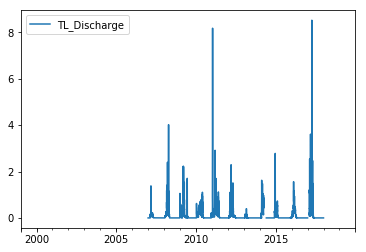

<Figure size 432x288 with 0 Axes>

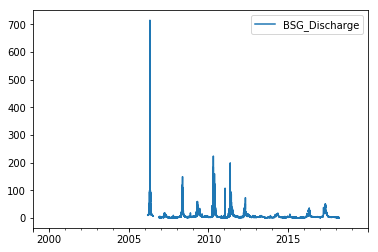

<Figure size 432x288 with 0 Axes>

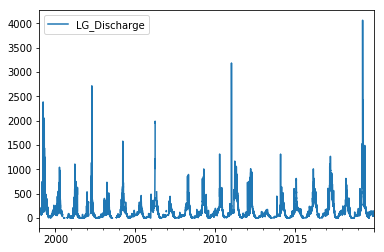

<Figure size 432x288 with 0 Axes>

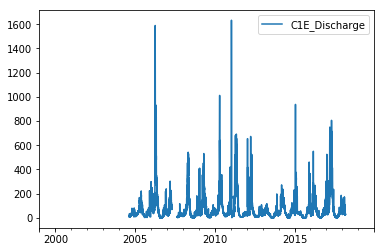

<Figure size 432x288 with 0 Axes>

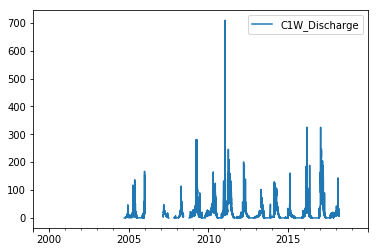

<Figure size 432x288 with 0 Axes>

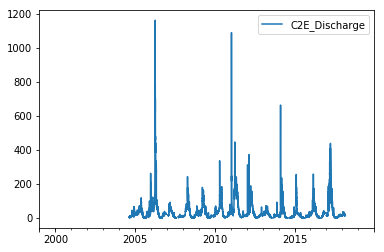

<Figure size 432x288 with 0 Axes>

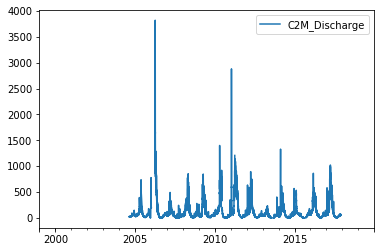

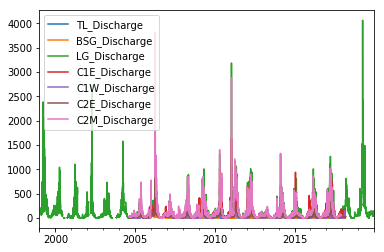

In [43]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head(2)

### 2. Precipitation

In [44]:
# extract variable data
BRW_ppt = BRW_met[['BRW_Precipitation']]
LDP_ppt = LDP_met[['LDP_Precipitation']]
SCR_ppt = SCR_met[['SCR_Precipitation']]
TL_ppt = TL_met[['TL_Precipitation']]
LW_ppt = LW_met[['LW_Precipitation']]

df_lst = [BRW_ppt, LDP_ppt, SCR_ppt, TL_ppt, LW_ppt]
for df in df_lst:     
    df = threC(df,'Precipitation') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 1)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 1)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 1)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 1)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 1)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [45]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "sum")

BRW_Precipitation  LDP_Precipitation  SCR_Precipitation  \
DateTime                                                                       
1999-01-01 00:00:00                NaN                NaN                NaN   
1999-01-01 01:00:00                NaN                NaN                NaN   

                     TL_Precipitation  LW_Precipitation  
DateTime                                                 
1999-01-01 00:00:00               NaN               0.0  
1999-01-01 01:00:00               NaN               0.0

BRW_Precipitation  LDP_Precipitation  SCR_Precipitation  \
DateTime                                                                       
2020-05-11 11:00:00              277.3                NaN                NaN   
2020-05-11 12:00:00              277.3                NaN                NaN   

                     TL_Precipitation  LW_Precipitation  
DateTime                                                 
2020-05-11 11:00:00               NaN               NaN  
2020-05-11 12:00:00               NaN               NaN

In [46]:
# change accumulated ppt data to seperate ppt data
for col in prep.columns:
    prep[col][1:] = np.array(prep[col])[1:] - np.array(prep[col])[:-1] 
    # take the difference to calculate the ppt data within each shour
prep = threC(prep,'Precipitation')

BRW_Precipitation
LDP_Precipitation
SCR_Precipitation
TL_Precipitation
LW_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

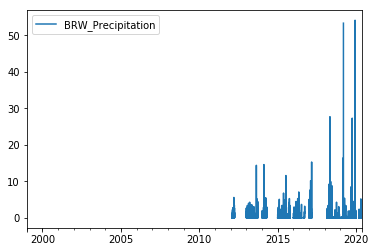

<Figure size 432x288 with 0 Axes>

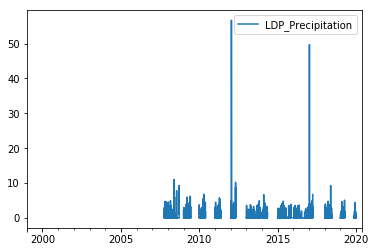

<Figure size 432x288 with 0 Axes>

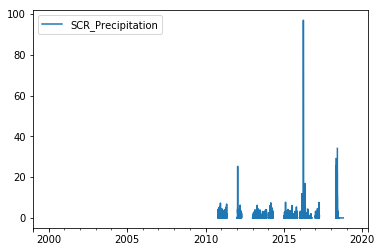

<Figure size 432x288 with 0 Axes>

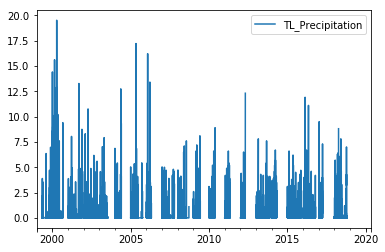

<Figure size 432x288 with 0 Axes>

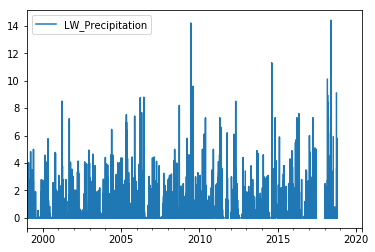

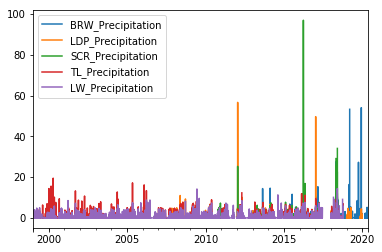

In [47]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [48]:
# extract variable data
BRW_AT = BRW_met[['BRW_AirTemperature']]
LDP_AT = LDP_met[['LDP_AirTemperature']]
SCR_AT = SCR_met[['SCR_AirTemperature']]
TL_AT = TL_met[['TL_AirTemperature']]
LW_AT = LW_met[['LW_AirTemperature']]

df_lst = [BRW_AT, LDP_AT, SCR_AT, TL_AT, LW_AT]
for df in df_lst:     
    df = threC(df,'AirTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 1)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 1)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 1)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 1)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 1)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [49]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_AirTemperature  LDP_AirTemperature  \
DateTime                                                      
1999-01-01 00:00:00                 NaN                 NaN   
1999-01-01 01:00:00                 NaN                 NaN   

                     SCR_AirTemperature  TL_AirTemperature  LW_AirTemperature  
DateTime                                                                       
1999-01-01 00:00:00                 NaN                NaN               2.27  
1999-01-01 01:00:00                 NaN                NaN               2.62

BRW_AirTemperature  LDP_AirTemperature  \
DateTime                                                      
2020-05-11 11:00:00               13.50                 NaN   
2020-05-11 12:00:00               13.38                 NaN   

                     SCR_AirTemperature  TL_AirTemperature  LW_AirTemperature  
DateTime                                                                       
2020-05-11 11:00:00                 NaN                NaN                NaN  
2020-05-11 12:00:00                 NaN                NaN                NaN

BRW_AirTemperature
LDP_AirTemperature
SCR_AirTemperature
TL_AirTemperature
LW_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

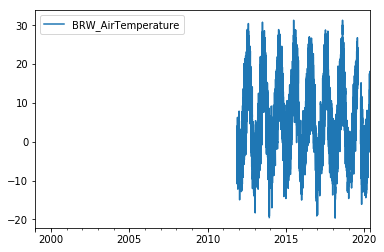

<Figure size 432x288 with 0 Axes>

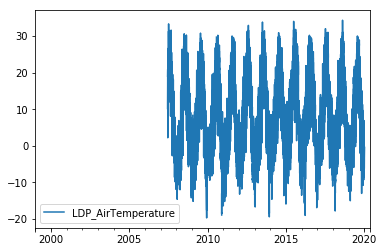

<Figure size 432x288 with 0 Axes>

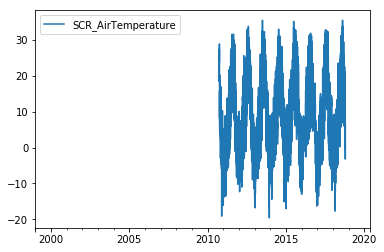

<Figure size 432x288 with 0 Axes>

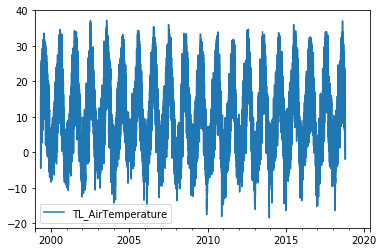

<Figure size 432x288 with 0 Axes>

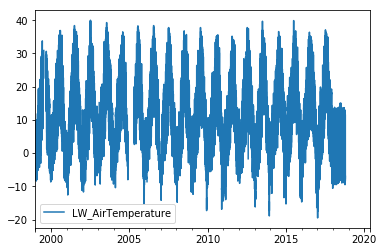

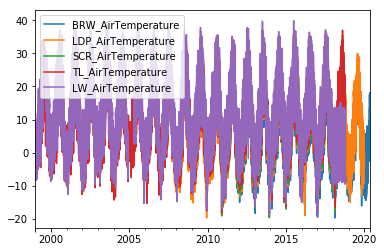

In [50]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

In [87]:
# extarct variable data
BRW_SR = BRW_met[['BRW_SolarRadiation_regular','BRW_SolarRadiation_net']]
LDP_SR = LDP_met[['LDP_SolarRadiation_regular','LDP_SolarRadiation_net']]
SCR_SR = SCR_met[['SCR_SolarRadiation_regular','SCR_SolarRadiation_net']]
TL_SR = TL_met[['TL_SolarRadiation_regular','TL_SolarRadiation_net']]
LW_SR = LW_met[['LW_SolarRadiation_regular','LW_SolarRadiation_net']]

df_lst = [BRW_SR, LDP_SR, SCR_SR, TL_SR, LW_SR]
for df in df_lst:     
    df = threC(df,'SolarRadiation') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 2)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 2)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 2)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 2)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 2)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [90]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_SolarRadiation_regular  BRW_SolarRadiation_net  \
DateTime                                                                  
1999-01-01 00:00:00                         NaN                     NaN   
1999-01-01 01:00:00                         NaN                     NaN   

                     LDP_SolarRadiation_regular  LDP_SolarRadiation_net  \
DateTime                                                                  
1999-01-01 00:00:00                         NaN                     NaN   
1999-01-01 01:00:00                         NaN                     NaN   

                     SCR_SolarRadiation_regular  SCR_SolarRadiation_net  \
DateTime                                                                  
1999-01-01 00:00:00                         NaN                     NaN   
1999-01-01 01:00:00                         NaN                     NaN   

                     TL_SolarRadiation_regular  TL_SolarRadiation_net  \
DateTime                                                                
1999-01-01 00:00:00                        NaN                    NaN   
1999-01-01 01:00:00                        NaN                    NaN   

                     LW_SolarRadiation_regular  LW_SolarRadiation_net  
DateTime                                                               
1999-01-01 00:00:00                        NaN                    NaN  
1999-01-01 01:00:00                        NaN                    NaN

BRW_SolarRadiation_regular  BRW_SolarRadiation_net  \
DateTime                                                                  
2020-05-11 11:00:00                       686.8                   447.0   
2020-05-11 12:00:00                       719.9                   475.2   

                     LDP_SolarRadiation_regular  LDP_SolarRadiation_net  \
DateTime                                                                  
2020-05-11 11:00:00                         NaN                     NaN   
2020-05-11 12:00:00                         NaN                     NaN   

                     SCR_SolarRadiation_regular  SCR_SolarRadiation_net  \
DateTime                                                                  
2020-05-11 11:00:00                         NaN                     NaN   
2020-05-11 12:00:00                         NaN                     NaN   

                     TL_SolarRadiation_regular  TL_SolarRadiation_net  \
DateTime                                                                
2020-05-11 11:00:00                        NaN                    NaN   
2020-05-11 12:00:00                        NaN                    NaN   

                     LW_SolarRadiation_regular  LW_SolarRadiation_net  
DateTime                                                               
2020-05-11 11:00:00                        NaN                    NaN  
2020-05-11 12:00:00                        NaN                    NaN

BRW_SolarRadiation_regular
BRW_SolarRadiation_net
LDP_SolarRadiation_regular
LDP_SolarRadiation_net
SCR_SolarRadiation_regular
SCR_SolarRadiation_net
TL_SolarRadiation_regular
TL_SolarRadiation_net
LW_SolarRadiation_regular
LW_SolarRadiation_net


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

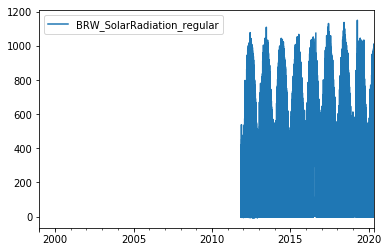

<Figure size 432x288 with 0 Axes>

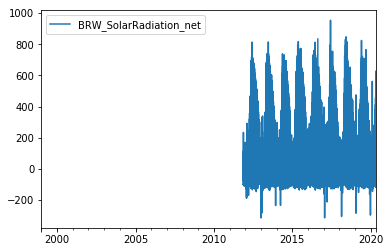

<Figure size 432x288 with 0 Axes>

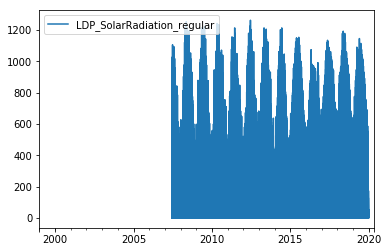

<Figure size 432x288 with 0 Axes>

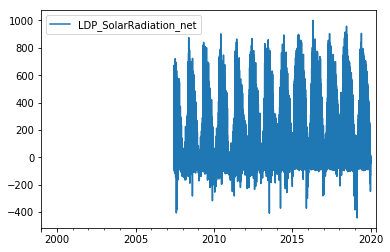

<Figure size 432x288 with 0 Axes>

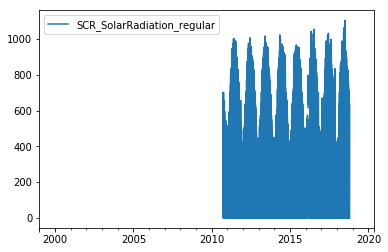

<Figure size 432x288 with 0 Axes>

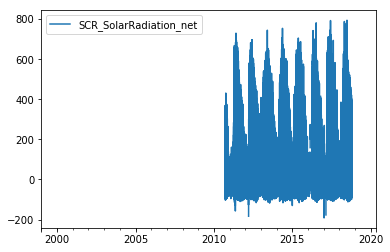

<Figure size 432x288 with 0 Axes>

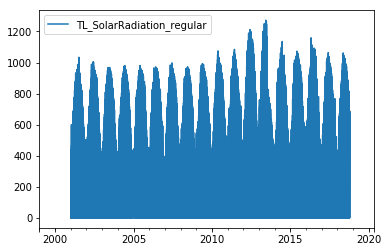

<Figure size 432x288 with 0 Axes>

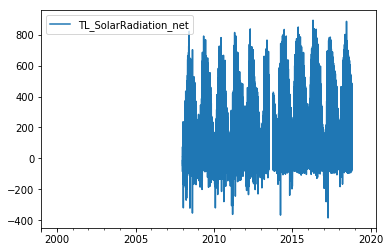

<Figure size 432x288 with 0 Axes>

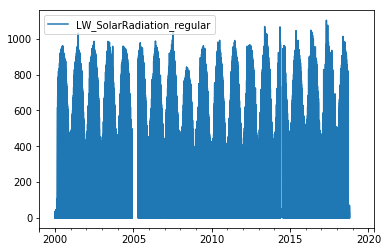

<Figure size 432x288 with 0 Axes>

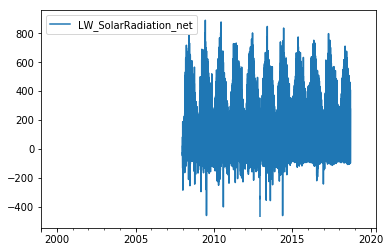

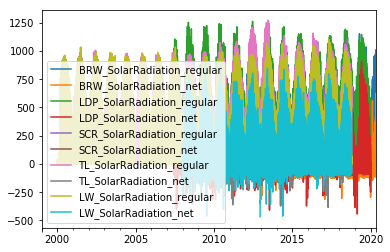

In [91]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SolarRadiation should be W/m2

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. Relative Humidity

In [54]:
# extarct variable data
BRW_RH = BRW_met[['BRW_RelativeHumidity']]
LDP_RH = LDP_met[['LDP_RelativeHumidity']]
SCR_RH = SCR_met[['SCR_RelativeHumidity']]
TL_RH = TL_met[['TL_RelativeHumidity']]
LW_RH = LW_met[['LW_RelativeHumidity']]

df_lst = [BRW_RH, LDP_RH, SCR_RH, TL_RH, LW_RH]
for df in df_lst:     
    df = threC(df,'RelativeHumidity') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 1)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 1)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 1)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 1)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 1)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [55]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_RelativeHumidity  LDP_RelativeHumidity  \
DateTime                                                          
1999-01-01 00:00:00                   NaN                   NaN   
1999-01-01 01:00:00                   NaN                   NaN   

                     SCR_RelativeHumidity  TL_RelativeHumidity  \
DateTime                                                         
1999-01-01 00:00:00                   NaN                  NaN   
1999-01-01 01:00:00                   NaN                  NaN   

                     LW_RelativeHumidity  
DateTime                                  
1999-01-01 00:00:00                 79.9  
1999-01-01 01:00:00                 75.1

BRW_RelativeHumidity  LDP_RelativeHumidity  \
DateTime                                                          
2020-05-11 11:00:00                 35.73                   NaN   
2020-05-11 12:00:00                 35.14                   NaN   

                     SCR_RelativeHumidity  TL_RelativeHumidity  \
DateTime                                                         
2020-05-11 11:00:00                   NaN                  NaN   
2020-05-11 12:00:00                   NaN                  NaN   

                     LW_RelativeHumidity  
DateTime                                  
2020-05-11 11:00:00                  NaN  
2020-05-11 12:00:00                  NaN

BRW_RelativeHumidity
LDP_RelativeHumidity
SCR_RelativeHumidity
TL_RelativeHumidity
LW_RelativeHumidity


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

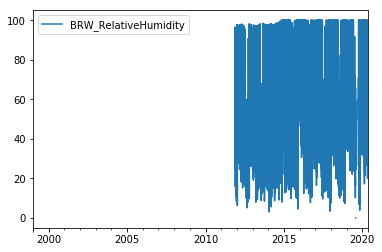

<Figure size 432x288 with 0 Axes>

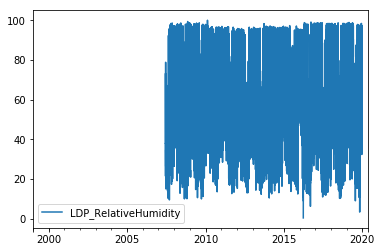

<Figure size 432x288 with 0 Axes>

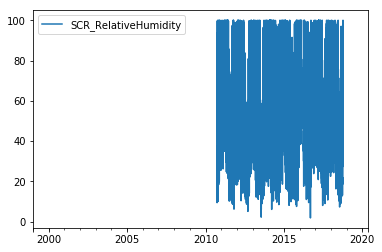

<Figure size 432x288 with 0 Axes>

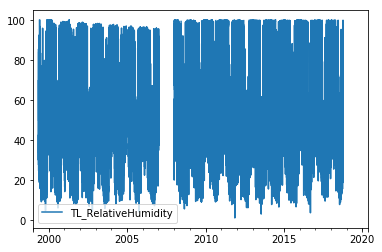

<Figure size 432x288 with 0 Axes>

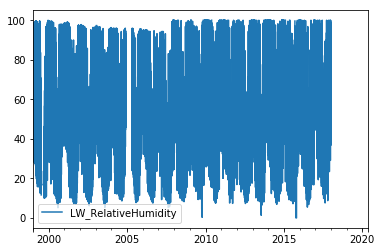

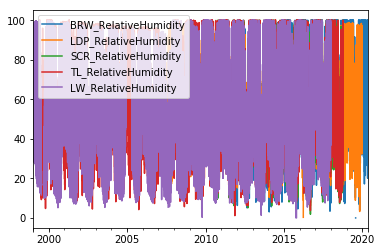

In [56]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. WindDirection

In [57]:
# extarct variable data
BRW_WD = BRW_met[['BRW_WindDirection']]
LDP_WD = LDP_met[['LDP_WindDirection']]
SCR_WD = SCR_met[['SCR_WindDirection']]
TL_WD = TL_met[['TL_WindDirection']]
LW_WD = LW_met[['LW_WindDirection']]

df_lst = [BRW_WD, LDP_WD, SCR_WD, TL_WD, LW_WD]
for df in df_lst:     
    df = threC(df,'WindDirection') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 1)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 1)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 1)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 1)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 1)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [58]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_WindDirection  LDP_WindDirection  SCR_WindDirection  \
DateTime                                                                       
1999-01-01 00:00:00                NaN                NaN                NaN   
1999-01-01 01:00:00                NaN                NaN                NaN   

                     TL_WindDirection  LW_WindDirection  
DateTime                                                 
1999-01-01 00:00:00               NaN             320.7  
1999-01-01 01:00:00               NaN             318.4

BRW_WindDirection  LDP_WindDirection  SCR_WindDirection  \
DateTime                                                                       
2020-05-11 11:00:00              2.286                NaN                NaN   
2020-05-11 12:00:00              1.943                NaN                NaN   

                     TL_WindDirection  LW_WindDirection  
DateTime                                                 
2020-05-11 11:00:00               NaN               NaN  
2020-05-11 12:00:00               NaN               NaN

BRW_WindDirection
LDP_WindDirection
SCR_WindDirection
TL_WindDirection
LW_WindDirection


BRW_WindDirection  LDP_WindDirection  SCR_WindDirection  \
1999-01-01 00:00:00                NaN                NaN                NaN   
1999-01-01 01:00:00                NaN                NaN                NaN   

                     TL_WindDirection  LW_WindDirection  
1999-01-01 00:00:00               NaN             320.7  
1999-01-01 01:00:00               NaN             318.4

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

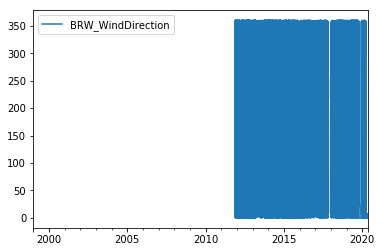

<Figure size 432x288 with 0 Axes>

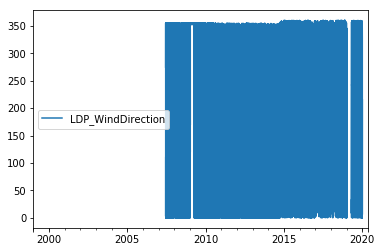

<Figure size 432x288 with 0 Axes>

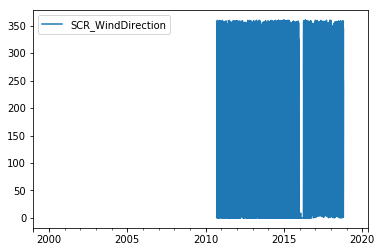

<Figure size 432x288 with 0 Axes>

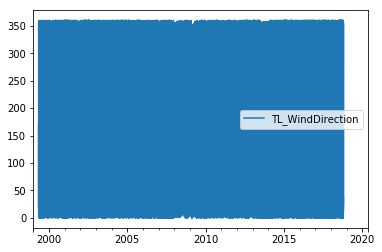

<Figure size 432x288 with 0 Axes>

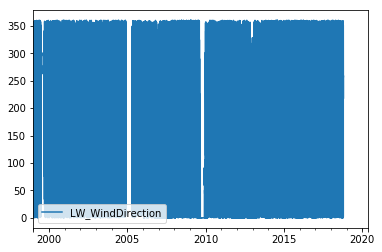

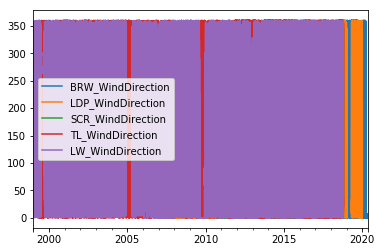

In [59]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindDirection unit should be degree
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head(2)

### 7. WindSpeed

In [60]:
# extarct variable data
BRW_WS = BRW_met[['BRW_WindSpeed']]
LDP_WS = LDP_met[['LDP_WindSpeed']]
SCR_WS = SCR_met[['SCR_WindSpeed']]
TL_WS = TL_met[['TL_WindSpeed']]
LW_WS = LW_met[['LW_WindSpeed']]

df_lst = [BRW_WS, LDP_WS, SCR_WS, TL_WS, LW_WS]
for df in df_lst:     
    df = threC(df,'WindSpeed') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 1)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 1)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 1)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 1)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 1)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [61]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_WindSpeed  LDP_WindSpeed  SCR_WindSpeed  \
DateTime                                                           
1999-01-01 00:00:00            NaN            NaN            NaN   
1999-01-01 01:00:00            NaN            NaN            NaN   

                     TL_WindSpeed  LW_WindSpeed  
DateTime                                         
1999-01-01 00:00:00           NaN          3.33  
1999-01-01 01:00:00           NaN          5.10

BRW_WindSpeed  LDP_WindSpeed  SCR_WindSpeed  \
DateTime                                                           
2020-05-11 11:00:00            0.0            NaN            NaN   
2020-05-11 12:00:00            0.0            NaN            NaN   

                     TL_WindSpeed  LW_WindSpeed  
DateTime                                         
2020-05-11 11:00:00           NaN           NaN  
2020-05-11 12:00:00           NaN           NaN

BRW_WindSpeed
LDP_WindSpeed
SCR_WindSpeed
TL_WindSpeed
LW_WindSpeed


BRW_WindSpeed  LDP_WindSpeed  SCR_WindSpeed  \
1999-01-01 00:00:00            NaN            NaN            NaN   
1999-01-01 01:00:00            NaN            NaN            NaN   

                     TL_WindSpeed  LW_WindSpeed  
1999-01-01 00:00:00           NaN          3.33  
1999-01-01 01:00:00           NaN          5.10

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

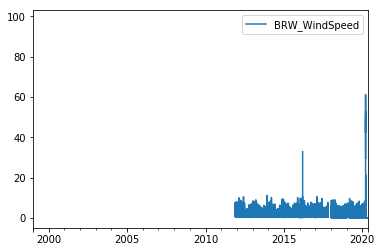

<Figure size 432x288 with 0 Axes>

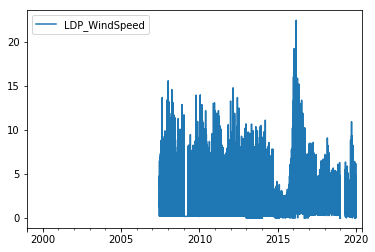

<Figure size 432x288 with 0 Axes>

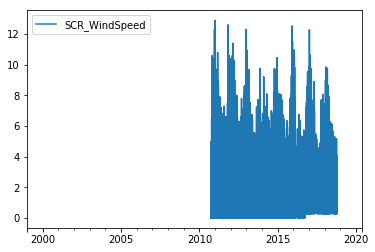

<Figure size 432x288 with 0 Axes>

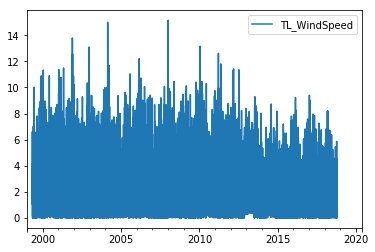

<Figure size 432x288 with 0 Axes>

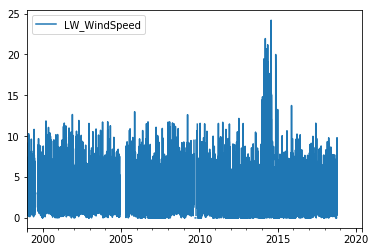

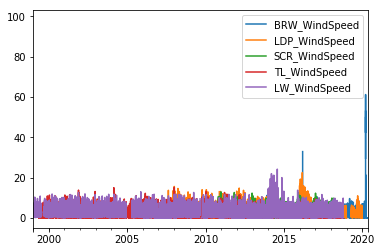

In [62]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head(2)

### 8. SWE

### 9. SnowDepth

In [63]:
# extract variable data
BRW_SD = BRW_met[['BRW_SnowDepth']]
LDP_SD = LDP_met[['LDP_SnowDepth']]
SCR_SD = SCR_met[['SCR_SnowDepth']]
TL_SD = TL_met[['TL_SnowDepth']]
LW_SD = LW_met[['LW_SnowDepth']]

df_lst = [BRW_SD, LDP_SD, SCR_SD, TL_SD, LW_SD]
for df in df_lst:     
    df = threC(df,'SnowDepth') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

(82045, 1)
2011-01-01 00:00:00 2020-05-11 12:00:00
(113979, 1)
2007-01-01 00:00:00 2019-12-31 23:00:00
(77876, 1)
2010-01-01 00:00:00 2018-10-15 13:00:00
(173623, 1)
1999-01-01 00:00:00 2018-10-15 12:00:00
(182343, 1)
1999-01-01 00:00:00 2018-10-15 13:00:00


In [64]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_SnowDepth  LDP_SnowDepth  SCR_SnowDepth  \
DateTime                                                           
1999-01-01 00:00:00            NaN            NaN            NaN   
1999-01-01 01:00:00            NaN            NaN            NaN   

                     TL_SnowDepth  LW_SnowDepth  
DateTime                                         
1999-01-01 00:00:00           NaN          0.45  
1999-01-01 01:00:00           NaN          0.52

BRW_SnowDepth  LDP_SnowDepth  SCR_SnowDepth  \
DateTime                                                           
2020-05-11 11:00:00            NaN            NaN            NaN   
2020-05-11 12:00:00            NaN            NaN            NaN   

                     TL_SnowDepth  LW_SnowDepth  
DateTime                                         
2020-05-11 11:00:00           NaN           NaN  
2020-05-11 12:00:00           NaN           NaN

BRW_SnowDepth
LDP_SnowDepth
SCR_SnowDepth
TL_SnowDepth
LW_SnowDepth


BRW_SnowDepth  LDP_SnowDepth  SCR_SnowDepth  \
1999-01-01 00:00:00            NaN            NaN            NaN   
1999-01-01 01:00:00            NaN            NaN            NaN   

                     TL_SnowDepth  LW_SnowDepth  
1999-01-01 00:00:00           NaN           4.5  
1999-01-01 01:00:00           NaN           5.2

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

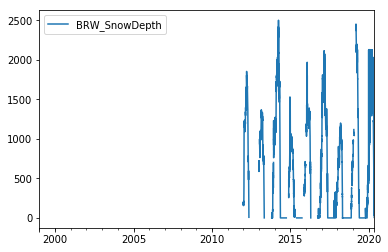

<Figure size 432x288 with 0 Axes>

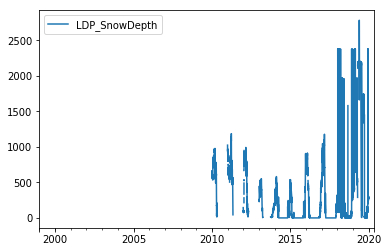

<Figure size 432x288 with 0 Axes>

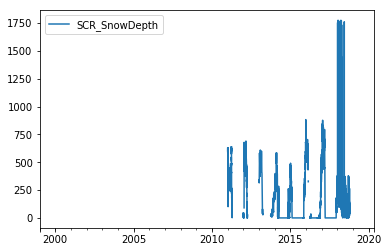

<Figure size 432x288 with 0 Axes>

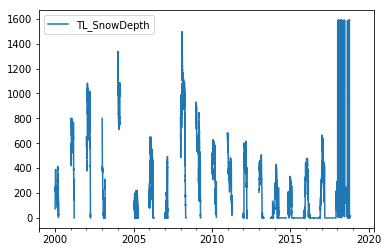

<Figure size 432x288 with 0 Axes>

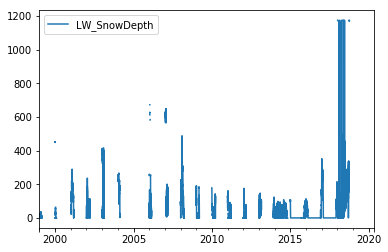

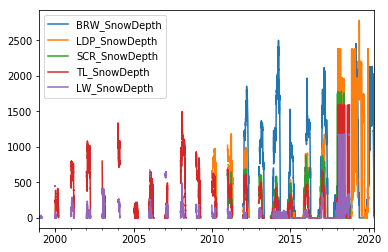

In [65]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Snowdepth unit should be mm
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*10  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()
SnowDepth.head(2)

### 10. VaporPressure

### 11. SoilMoisture

In [66]:
BRW_SM = BRW_soil[[i for i in BRW_soil.columns if i.split('_')[1] == 'SoilMoisture']]
LDP_SM = LDP_soil[[i for i in LDP_soil.columns if i.split('_')[1] == 'SoilMoisture']]
SCR_SM = SCR_soil[[i for i in SCR_soil.columns if i.split('_')[1] == 'SoilMoisture']]
TL_SM = TL_soil[[i for i in TL_soil.columns if i.split('_')[1] == 'SoilMoisture']]
LW_SM = LW_soil[[i for i in LW_soil.columns if i.split('_')[1] == 'SoilMoisture']]
HN_SM = HN_soil[[i for i in HN_soil.columns if i.split('_')[1] == 'SoilMoisture']]
HS_SM = HS_soil[[i for i in HS_soil.columns if i.split('_')[1] == 'SoilMoisture']]
MHN_SM = MHN_soil[[i for i in MHN_soil.columns if i.split('_')[1] == 'SoilMoisture']]
MHS_SM = MHS_soil[[i for i in MHS_soil.columns if i.split('_')[1] == 'SoilMoisture']]
MLN_SM = MLN_soil[[i for i in MLN_soil.columns if i.split('_')[1] == 'SoilMoisture']]
MLS_SM = MLS_soil[[i for i in MLS_soil.columns if i.split('_')[1] == 'SoilMoisture']]
LN_SM = LN_soil[[i for i in LN_soil.columns if i.split('_')[1] == 'SoilMoisture']]
LS_SM = LS_soil[[i for i in LS_soil.columns if i.split('_')[1] == 'SoilMoisture']]

In [67]:
df_lst = [BRW_SM,LDP_SM,SCR_SM,TL_SM,LW_SM]
for df in df_lst:  
    display(df.head(2))
    df = threC(df,'SoilMoisture') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

BRW_SoilMoisture_L_5cm  BRW_SoilMoisture_L_15cm  \
DateTime                                                            
11/24/2012 10:00                   0.184                    0.204   
11/24/2012 10:15                   0.180                    0.202   

                  BRW_SoilMoisture_L_30cm  BRW_SoilMoisture_L_81cm  \
DateTime                                                             
11/24/2012 10:00                     0.19                    0.083   
11/24/2012 10:15                     0.19                    0.083   

                  BRW_SoilMoisture_U_5cm  BRW_SoilMoisture_U_15cm  \
DateTime                                                            
11/24/2012 10:00                   0.086                    0.156   
11/24/2012 10:15                   0.088                    0.156   

                  BRW_SoilMoisture_U_30cm  BRW_SoilMoisture_U_55cm  
DateTime                                                            
11/24/2012 10:00                    0.208                    0.109  
11/24/2012 10:15                    0.208                    0.109

(44461, 8)
2012-11-24 10:00:00 2018-01-05 12:00:00


LDP_SoilMoisture_W_8cm  LDP_SoilMoisture_E_8cm
DateTime                                                     
1/1/2007 0:00                 -6999.0                 -6999.0
1/1/2007 1:00                 -6999.0                 -6999.0

(96432, 2)
2007-01-01 00:00:00 2017-12-31 23:00:00


SCR_SoilMoisture_5cm
DateTime                           
1/1/2012 0:00               -6999.0
1/1/2012 1:00               -6999.0

(55978, 1)
2012-01-01 00:00:00 2018-05-21 09:00:00


TL_SoilMoisture_P3_5cm  TL_SoilMoisture_P3_15cm  \
1/1/1999 0:00                 -6999.0                  -6999.0   
1/1/1999 1:00                 -6999.0                  -6999.0   

               TL_SoilMoisture_P3_30cm  TL_SoilMoisture_P3_60cm  \
1/1/1999 0:00                  -6999.0                  -6999.0   
1/1/1999 1:00                  -6999.0                  -6999.0   

               TL_SoilMoisture_P3_100cm  TL_SoilMoisture_P4_5cm  \
1/1/1999 0:00                   -6999.0                 -6999.0   
1/1/1999 1:00                   -6999.0                 -6999.0   

               TL_SoilMoisture_P4_15cm  TL_SoilMoisture_P4_30cm  \
1/1/1999 0:00                  -6999.0                  -6999.0   
1/1/1999 1:00                  -6999.0                  -6999.0   

               TL_SoilMoisture_P4_45cm  TL_SoilMoisture_P4_65cm  
1/1/1999 0:00                  -6999.0                  -6999.0  
1/1/1999 1:00                  -6999.0                  -6999.0

(166814, 10)
1999-01-01 00:00:00 2017-12-31 23:00:00


LW_SoilMoisture_P1_5cm  LW_SoilMoisture_P1_15cm  \
DateTime                                                            
01/01/1999 00:00                   0.239                    0.259   
01/01/1999 01:00                   0.239                    0.259   

                  LW_SoilMoisture_P1_30cm  LW_SoilMoisture_P1_50cm  \
DateTime                                                             
01/01/1999 00:00                    0.238                    0.039   
01/01/1999 01:00                    0.238                    0.039   

                  LW_SoilMoisture_P1_100cm  LW_SoilMoisture_P2_5cm  \
DateTime                                                             
01/01/1999 00:00                     0.076                   0.289   
01/01/1999 01:00                     0.076                   0.285   

                  LW_SoilMoisture_P2_15cm  LW_SoilMoisture_P2_30cm  \
DateTime                                                             
01/01/1999 00:00                    0.280                    0.157   
01/01/1999 01:00                    0.279                    0.158   

                  LW_SoilMoisture_P2_60cm  LW_SoilMoisture_P2_100cm  
DateTime                                                             
01/01/1999 00:00                     0.01                     0.057  
01/01/1999 01:00                     0.01                     0.057

(175591, 10)
1999-01-01 00:00:00 2017-12-31 23:00:00


In [68]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_SoilMoisture_L_5cm  BRW_SoilMoisture_L_15cm  \
1999-01-01 00:00:00                     NaN                      NaN   
1999-01-01 01:00:00                     NaN                      NaN   

                     BRW_SoilMoisture_L_30cm  BRW_SoilMoisture_L_81cm  \
1999-01-01 00:00:00                      NaN                      NaN   
1999-01-01 01:00:00                      NaN                      NaN   

                     BRW_SoilMoisture_U_5cm  BRW_SoilMoisture_U_15cm  \
1999-01-01 00:00:00                     NaN                      NaN   
1999-01-01 01:00:00                     NaN                      NaN   

                     BRW_SoilMoisture_U_30cm  BRW_SoilMoisture_U_55cm  \
1999-01-01 00:00:00                      NaN                      NaN   
1999-01-01 01:00:00                      NaN                      NaN   

                     LDP_SoilMoisture_W_8cm  LDP_SoilMoisture_E_8cm  ...  \
1999-01-01 00:00:00                     NaN                     NaN  ...   
1999-01-01 01:00:00                     NaN                     NaN  ...   

                     LW_SoilMoisture_P1_5cm  LW_SoilMoisture_P1_15cm  \
1999-01-01 00:00:00                   0.239                    0.259   
1999-01-01 01:00:00                   0.239                    0.259   

                     LW_SoilMoisture_P1_30cm  LW_SoilMoisture_P1_50cm  \
1999-01-01 00:00:00                    0.238                    0.039   
1999-01-01 01:00:00                    0.238                    0.039   

                     LW_SoilMoisture_P1_100cm  LW_SoilMoisture_P2_5cm  \
1999-01-01 00:00:00                     0.076                   0.289   
1999-01-01 01:00:00                     0.076                   0.285   

                     LW_SoilMoisture_P2_15cm  LW_SoilMoisture_P2_30cm  \
1999-01-01 00:00:00                    0.280                    0.157   
1999-01-01 01:00:00                    0.279                    0.158   

                     LW_SoilMoisture_P2_60cm  LW_SoilMoisture_P2_100cm  
1999-01-01 00:00:00                     0.01                     0.057  
1999-01-01 01:00:00                     0.01                     0.057  

[2 rows x 31 columns]

BRW_SoilMoisture_L_5cm  BRW_SoilMoisture_L_15cm  \
2018-05-21 08:00:00                     NaN                      NaN   
2018-05-21 09:00:00                     NaN                      NaN   

                     BRW_SoilMoisture_L_30cm  BRW_SoilMoisture_L_81cm  \
2018-05-21 08:00:00                      NaN                      NaN   
2018-05-21 09:00:00                      NaN                      NaN   

                     BRW_SoilMoisture_U_5cm  BRW_SoilMoisture_U_15cm  \
2018-05-21 08:00:00                     NaN                      NaN   
2018-05-21 09:00:00                     NaN                      NaN   

                     BRW_SoilMoisture_U_30cm  BRW_SoilMoisture_U_55cm  \
2018-05-21 08:00:00                      NaN                      NaN   
2018-05-21 09:00:00                      NaN                      NaN   

                     LDP_SoilMoisture_W_8cm  LDP_SoilMoisture_E_8cm  ...  \
2018-05-21 08:00:00                     NaN                     NaN  ...   
2018-05-21 09:00:00                     NaN                     NaN  ...   

                     LW_SoilMoisture_P1_5cm  LW_SoilMoisture_P1_15cm  \
2018-05-21 08:00:00                     NaN                      NaN   
2018-05-21 09:00:00                     NaN                      NaN   

                     LW_SoilMoisture_P1_30cm  LW_SoilMoisture_P1_50cm  \
2018-05-21 08:00:00                      NaN                      NaN   
2018-05-21 09:00:00                      NaN                      NaN   

                     LW_SoilMoisture_P1_100cm  LW_SoilMoisture_P2_5cm  \
2018-05-21 08:00:00                       NaN                     NaN   
2018-05-21 09:00:00                       NaN                     NaN   

                     LW_SoilMoisture_P2_15cm  LW_SoilMoisture_P2_30cm  \
2018-05-21 08:00:00                      NaN                      NaN   
2018-05-21 09:00:00                      NaN                      NaN   

                     LW_SoilMoisture_P2_60cm  LW_SoilMoisture_P2_100cm  
2018-05-21 08:00:00                      NaN                       NaN  
2018-05-21 09:00:00                      NaN                       NaN  

[2 rows x 31 columns]

BRW_SoilMoisture_L_5cm
BRW_SoilMoisture_L_15cm
BRW_SoilMoisture_L_30cm
BRW_SoilMoisture_L_81cm
BRW_SoilMoisture_U_5cm
BRW_SoilMoisture_U_15cm
BRW_SoilMoisture_U_30cm
BRW_SoilMoisture_U_55cm
LDP_SoilMoisture_W_8cm
LDP_SoilMoisture_E_8cm
SCR_SoilMoisture_5cm
TL_SoilMoisture_P3_5cm
TL_SoilMoisture_P3_15cm
TL_SoilMoisture_P3_30cm
TL_SoilMoisture_P3_60cm
TL_SoilMoisture_P3_100cm
TL_SoilMoisture_P4_5cm
TL_SoilMoisture_P4_15cm
TL_SoilMoisture_P4_30cm
TL_SoilMoisture_P4_45cm
TL_SoilMoisture_P4_65cm
LW_SoilMoisture_P1_5cm
LW_SoilMoisture_P1_15cm
LW_SoilMoisture_P1_30cm
LW_SoilMoisture_P1_50cm
LW_SoilMoisture_P1_100cm
LW_SoilMoisture_P2_5cm
LW_SoilMoisture_P2_15cm
LW_SoilMoisture_P2_30cm
LW_SoilMoisture_P2_60cm
LW_SoilMoisture_P2_100cm


BRW_SoilMoisture_L_5cm  BRW_SoilMoisture_L_15cm  \
1999-01-01 00:00:00                     NaN                      NaN   
1999-01-01 01:00:00                     NaN                      NaN   

                     BRW_SoilMoisture_L_30cm  BRW_SoilMoisture_L_81cm  \
1999-01-01 00:00:00                      NaN                      NaN   
1999-01-01 01:00:00                      NaN                      NaN   

                     BRW_SoilMoisture_U_5cm  BRW_SoilMoisture_U_15cm  \
1999-01-01 00:00:00                     NaN                      NaN   
1999-01-01 01:00:00                     NaN                      NaN   

                     BRW_SoilMoisture_U_30cm  BRW_SoilMoisture_U_55cm  \
1999-01-01 00:00:00                      NaN                      NaN   
1999-01-01 01:00:00                      NaN                      NaN   

                     LDP_SoilMoisture_W_8cm  LDP_SoilMoisture_E_8cm  ...  \
1999-01-01 00:00:00                     NaN                     NaN  ...   
1999-01-01 01:00:00                     NaN                     NaN  ...   

                     LW_SoilMoisture_P1_5cm  LW_SoilMoisture_P1_15cm  \
1999-01-01 00:00:00                    23.9                     25.9   
1999-01-01 01:00:00                    23.9                     25.9   

                     LW_SoilMoisture_P1_30cm  LW_SoilMoisture_P1_50cm  \
1999-01-01 00:00:00                     23.8                      3.9   
1999-01-01 01:00:00                     23.8                      3.9   

                     LW_SoilMoisture_P1_100cm  LW_SoilMoisture_P2_5cm  \
1999-01-01 00:00:00                       7.6                    28.9   
1999-01-01 01:00:00                       7.6                    28.5   

                     LW_SoilMoisture_P2_15cm  LW_SoilMoisture_P2_30cm  \
1999-01-01 00:00:00                     28.0                     15.7   
1999-01-01 01:00:00                     27.9                     15.8   

                     LW_SoilMoisture_P2_60cm  LW_SoilMoisture_P2_100cm  
1999-01-01 00:00:00                      1.0                       5.7  
1999-01-01 01:00:00                      1.0                       5.7  

[2 rows x 31 columns]

<Figure size 720x288 with 0 Axes>

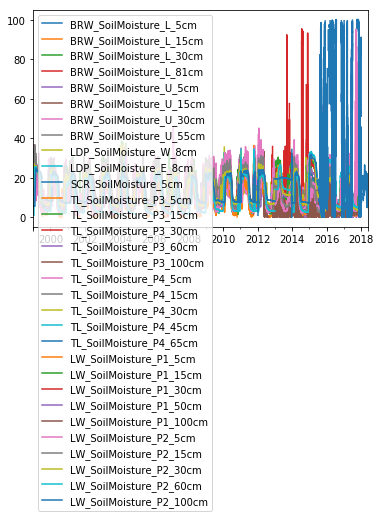

In [69]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilMositure data should be %
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100  # 
    #plt.figure()
    #df[[site]].plot()
SoilMoisture1 = copy.deepcopy(df)
SoilMoisture1 = threC(SoilMoisture1,'SoilMoisture') 
SoilMoisture1.plot()
SoilMoisture1.head(2)

In [70]:
df_lst = [HN_SM,HS_SM,MHN_SM,MHS_SM]
for df in df_lst:  
    display(df.head(2))
    df = threC(df,'SoilMoisture') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

HN_SoilMoisture_Pit1_2cm  HN_SoilMoisture_Pit1_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit1_30cm  HN_SoilMoisture_Pit1_37cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   

                  HN_SoilMoisture_Pit2_2cm  HN_SoilMoisture_Pit2_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit2_30cm  HN_SoilMoisture_Pit2_42cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   

                  HN_SoilMoisture_Pit3_2cm  HN_SoilMoisture_Pit3_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit3_30cm  HN_SoilMoisture_Pit3_54cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   

                  HN_SoilMoisture_Pit4_2cm  HN_SoilMoisture_Pit4_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  HN_SoilMoisture_Pit4_30cm  HN_SoilMoisture_Pit4_45cmBdrk  
DateTime                                                                    
01/01/2008 00:00                    -6999.0                        -6999.0  
01/01/2008 01:00                    -6999.0                        -6999.0

(87754, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


HS_SoilMoisture_Pit1_2cm  HS_SoilMoisture_Pit1_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   

               HS_SoilMoisture_Pit1_30cm  HS_SoilMoisture_Pit1_65cmBdrk  \
DateTime                                                                  
1/1/2008 0:00                    -6999.0                        -6999.0   
1/1/2008 1:00                    -6999.0                        -6999.0   

               HS_SoilMoisture_Pit2_2cm  HS_SoilMoisture_Pit2_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   

               HS_SoilMoisture_Pit2_30cm  HS_SoilMoisture_Pit2_70cmBdrk  \
DateTime                                                                  
1/1/2008 0:00                    -6999.0                        -6999.0   
1/1/2008 1:00                    -6999.0                        -6999.0   

               HS_SoilMoisture_Pit3_2cm  HS_SoilMoisture_Pit3_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   

               HS_SoilMoisture_Pit3_30cm  HS_SoilMoisture_Pit3_80cmBdrk  \
DateTime                                                                  
1/1/2008 0:00                    -6999.0                        -6999.0   
1/1/2008 1:00                    -6999.0                        -6999.0   

               HS_SoilMoisture_Pit4_2cm  HS_SoilMoisture_Pit4_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   

               HS_SoilMoisture_Pit4_30cm  HS_SoilMoisture_Pit4_77cmBdrk  
DateTime                                                                 
1/1/2008 0:00                    -6999.0                        -6999.0  
1/1/2008 1:00                    -6999.0                        -6999.0

(87648, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


MHN_SoilMoisture_Pit1_2cm  MHN_SoilMoisture_Pit1_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHN_SoilMoisture_Pit1_30cm  MHN_SoilMoisture_Pit1_71cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MHN_SoilMoisture_Pit2_2cm  MHN_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHN_SoilMoisture_Pit2_30cm  MHN_SoilMoisture_Pit2_97cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MHN_SoilMoisture_Pit3_2cm  MHN_SoilMoisture_Pit3_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHN_SoilMoisture_Pit3_30cm  MHN_SoilMoisture_Pit3_52cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MHN_SoilMoisture_Pit4_2cm  MHN_SoilMoisture_Pit4_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHN_SoilMoisture_Pit4_30cm  MHN_SoilMoisture_Pit4_74cmBdrk  
DateTime                                                                      
01/01/2008 00:00                     -6999.0                         -6999.0  
01/01/2008 01:00                     -6999.0                         -6999.0

(87754, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


MHS_SoilMoisture_Pit1_2cm  MHS_SoilMoisture_Pit1_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHS_SoilMoisture_Pit1_30cm  MHS_SoilMoisture_Pit1_70cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MHS_SoilMoisture_Pit2_2cm  MHS_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHS_SoilMoisture_Pit2_30cm  MHS_SoilMoisture_Pit2_59cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MHS_SoilMoisture_Pit3_2cm  MHS_SoilMoisture_Pit3_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHS_SoilMoisture_Pit3_30cm  MHS_SoilMoisture_Pit3_60cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MHS_SoilMoisture_Pit4_2cm  MHS_SoilMoisture_Pit4_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MHS_SoilMoisture_Pit4_30cm  MHS_SoilMoisture_Pit4_50cmBdrk  
DateTime                                                                      
01/01/2008 00:00                     -6999.0                         -6999.0  
01/01/2008 01:00                     -6999.0                         -6999.0

(83182, 16)
2008-01-01 00:00:00 2017-06-23 17:00:00


In [71]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

HN_SoilMoisture_Pit1_2cm  HN_SoilMoisture_Pit1_15cm  \
DateTime                                                                   
2008-01-01 00:00:00                       NaN                        NaN   
2008-01-01 01:00:00                       NaN                        NaN   

                     HN_SoilMoisture_Pit1_30cm  HN_SoilMoisture_Pit1_37cmBdrk  \
DateTime                                                                        
2008-01-01 00:00:00                        NaN                            NaN   
2008-01-01 01:00:00                        NaN                            NaN   

                     HN_SoilMoisture_Pit2_2cm  HN_SoilMoisture_Pit2_15cm  \
DateTime                                                                   
2008-01-01 00:00:00                       NaN                        NaN   
2008-01-01 01:00:00                       NaN                        NaN   

                     HN_SoilMoisture_Pit2_30cm  HN_SoilMoisture_Pit2_42cmBdrk  \
DateTime                                                                        
2008-01-01 00:00:00                        NaN                            NaN   
2008-01-01 01:00:00                        NaN                            NaN   

                     HN_SoilMoisture_Pit3_2cm  HN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                  ...   
2008-01-01 00:00:00                       NaN                        NaN  ...   
2008-01-01 01:00:00                       NaN                        NaN  ...   

                     MHS_SoilMoisture_Pit2_30cm  \
DateTime                                          
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MHS_SoilMoisture_Pit2_59cmBdrk  \
DateTime                                              
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MHS_SoilMoisture_Pit3_2cm  MHS_SoilMoisture_Pit3_15cm  \
DateTime                                                                     
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MHS_SoilMoisture_Pit3_30cm  \
DateTime                                          
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MHS_SoilMoisture_Pit3_60cmBdrk  \
DateTime                                              
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MHS_SoilMoisture_Pit4_2cm  MHS_SoilMoisture_Pit4_15cm  \
DateTime                                                                     
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MHS_SoilMoisture_Pit4_30cm  \
DateTime                                          
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MHS_SoilMoisture_Pit4_50cmBdrk  
DateTime                                             
2008-01-01 00:00:00                             NaN  
2008-01-01 01:00:00                             NaN  

[2 rows x 64 columns]

HN_SoilMoisture_Pit1_2cm  HN_SoilMoisture_Pit1_15cm  \
DateTime                                                                   
2017-12-31 22:00:00                     0.224                      0.252   
2017-12-31 23:00:00                     0.235                      0.252   

                     HN_SoilMoisture_Pit1_30cm  HN_SoilMoisture_Pit1_37cmBdrk  \
DateTime                                                                        
2017-12-31 22:00:00                        NaN                          0.230   
2017-12-31 23:00:00                        NaN                          0.224   

                     HN_SoilMoisture_Pit2_2cm  HN_SoilMoisture_Pit2_15cm  \
DateTime                                                                   
2017-12-31 22:00:00                       NaN                        NaN   
2017-12-31 23:00:00                       NaN                        NaN   

                     HN_SoilMoisture_Pit2_30cm  HN_SoilMoisture_Pit2_42cmBdrk  \
DateTime                                                                        
2017-12-31 22:00:00                      0.288                          0.231   
2017-12-31 23:00:00                      0.305                          0.230   

                     HN_SoilMoisture_Pit3_2cm  HN_SoilMoisture_Pit3_15cm  ...  \
DateTime                                                                  ...   
2017-12-31 22:00:00                     0.157                      0.306  ...   
2017-12-31 23:00:00                     0.168                      0.290  ...   

                     MHS_SoilMoisture_Pit2_30cm  \
DateTime                                          
2017-12-31 22:00:00                         NaN   
2017-12-31 23:00:00                         NaN   

                     MHS_SoilMoisture_Pit2_59cmBdrk  \
DateTime                                              
2017-12-31 22:00:00                             NaN   
2017-12-31 23:00:00                             NaN   

                     MHS_SoilMoisture_Pit3_2cm  MHS_SoilMoisture_Pit3_15cm  \
DateTime                                                                     
2017-12-31 22:00:00                        NaN                         NaN   
2017-12-31 23:00:00                        NaN                         NaN   

                     MHS_SoilMoisture_Pit3_30cm  \
DateTime                                          
2017-12-31 22:00:00                         NaN   
2017-12-31 23:00:00                         NaN   

                     MHS_SoilMoisture_Pit3_60cmBdrk  \
DateTime                                              
2017-12-31 22:00:00                             NaN   
2017-12-31 23:00:00                             NaN   

                     MHS_SoilMoisture_Pit4_2cm  MHS_SoilMoisture_Pit4_15cm  \
DateTime                                                                     
2017-12-31 22:00:00                        NaN                         NaN   
2017-12-31 23:00:00                        NaN                         NaN   

                     MHS_SoilMoisture_Pit4_30cm  \
DateTime                                          
2017-12-31 22:00:00                         NaN   
2017-12-31 23:00:00                         NaN   

                     MHS_SoilMoisture_Pit4_50cmBdrk  
DateTime                                             
2017-12-31 22:00:00                             NaN  
2017-12-31 23:00:00                             NaN  

[2 rows x 64 columns]

HN_SoilMoisture_Pit1_2cm
HN_SoilMoisture_Pit1_15cm
HN_SoilMoisture_Pit1_30cm
HN_SoilMoisture_Pit1_37cmBdrk
HN_SoilMoisture_Pit2_2cm
HN_SoilMoisture_Pit2_15cm
HN_SoilMoisture_Pit2_30cm
HN_SoilMoisture_Pit2_42cmBdrk
HN_SoilMoisture_Pit3_2cm
HN_SoilMoisture_Pit3_15cm
HN_SoilMoisture_Pit3_30cm
HN_SoilMoisture_Pit3_54cmBdrk
HN_SoilMoisture_Pit4_2cm
HN_SoilMoisture_Pit4_15cm
HN_SoilMoisture_Pit4_30cm
HN_SoilMoisture_Pit4_45cmBdrk
HS_SoilMoisture_Pit1_2cm
HS_SoilMoisture_Pit1_15cm
HS_SoilMoisture_Pit1_30cm
HS_SoilMoisture_Pit1_65cmBdrk
HS_SoilMoisture_Pit2_2cm
HS_SoilMoisture_Pit2_15cm
HS_SoilMoisture_Pit2_30cm
HS_SoilMoisture_Pit2_70cmBdrk
HS_SoilMoisture_Pit3_2cm
HS_SoilMoisture_Pit3_15cm
HS_SoilMoisture_Pit3_30cm
HS_SoilMoisture_Pit3_80cmBdrk
HS_SoilMoisture_Pit4_2cm
HS_SoilMoisture_Pit4_15cm
HS_SoilMoisture_Pit4_30cm
HS_SoilMoisture_Pit4_77cmBdrk
MHN_SoilMoisture_Pit1_2cm
MHN_SoilMoisture_Pit1_15cm
MHN_SoilMoisture_Pit1_30cm
MHN_SoilMoisture_Pit1_71cmBdrk
MHN_SoilMoisture_Pit2_2cm
MHN_Soi

HN_SoilMoisture_Pit1_2cm  HN_SoilMoisture_Pit1_15cm  \
2008-01-01 00:00:00                       NaN                        NaN   
2008-01-01 01:00:00                       NaN                        NaN   

                     HN_SoilMoisture_Pit1_30cm  HN_SoilMoisture_Pit1_37cmBdrk  \
2008-01-01 00:00:00                        NaN                            NaN   
2008-01-01 01:00:00                        NaN                            NaN   

                     HN_SoilMoisture_Pit2_2cm  HN_SoilMoisture_Pit2_15cm  \
2008-01-01 00:00:00                       NaN                        NaN   
2008-01-01 01:00:00                       NaN                        NaN   

                     HN_SoilMoisture_Pit2_30cm  HN_SoilMoisture_Pit2_42cmBdrk  \
2008-01-01 00:00:00                        NaN                            NaN   
2008-01-01 01:00:00                        NaN                            NaN   

                     HN_SoilMoisture_Pit3_2cm  HN_SoilMoisture_Pit3_15cm  ...  \
2008-01-01 00:00:00                       NaN                        NaN  ...   
2008-01-01 01:00:00                       NaN                        NaN  ...   

                     MHS_SoilMoisture_Pit2_30cm  \
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MHS_SoilMoisture_Pit2_59cmBdrk  \
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MHS_SoilMoisture_Pit3_2cm  MHS_SoilMoisture_Pit3_15cm  \
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MHS_SoilMoisture_Pit3_30cm  \
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MHS_SoilMoisture_Pit3_60cmBdrk  \
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MHS_SoilMoisture_Pit4_2cm  MHS_SoilMoisture_Pit4_15cm  \
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MHS_SoilMoisture_Pit4_30cm  \
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MHS_SoilMoisture_Pit4_50cmBdrk  
2008-01-01 00:00:00                             NaN  
2008-01-01 01:00:00                             NaN  

[2 rows x 64 columns]

<Figure size 720x288 with 0 Axes>

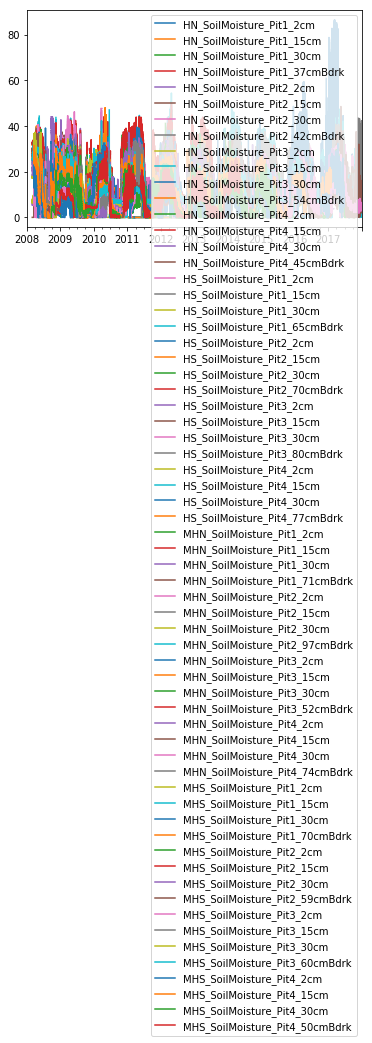

In [72]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilMositure data should be %
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100  # 
    #plt.figure()
    #df[[site]].plot()

SoilMoisture2 = copy.deepcopy(df)
SoilMoisture2 = threC(SoilMoisture2,'SoilMoisture') 
SoilMoisture2.plot()
SoilMoisture2.head(2)

In [73]:
df_lst = [MLN_SM,MLS_SM,LN_SM,LS_SM]
for df in df_lst:  
    display(df.head(2))
    df = threC(df,'SoilMoisture') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

MLN_SoilMoisture_Pit1_2cm MLN_SoilMoisture_Pit1_15cm  \
DateTime                                                                 
01/01/2008 00:00                    -6999.0                      -6999   
01/01/2008 01:00                    -6999.0                      -6999   

                  MLN_SoilMoisture_Pit1_30cm  MLN_SoilMoisture_Pit1_84cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MLN_SoilMoisture_Pit2_2cm  MLN_SoilMoisture_Pit2_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MLN_SoilMoisture_Pit2_30cm  MLN_SoilMoisture_Pit2_89cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MLN_SoilMoisture_Pit3_2cm  MLN_SoilMoisture_Pit3_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MLN_SoilMoisture_Pit3_30cm  MLN_SoilMoisture_Pit3_61cmBdrk  \
DateTime                                                                       
01/01/2008 00:00                     -6999.0                         -6999.0   
01/01/2008 01:00                     -6999.0                         -6999.0   

                  MLN_SoilMoisture_Pit4_2cm  MLN_SoilMoisture_Pit4_15cm  \
DateTime                                                                  
01/01/2008 00:00                    -6999.0                     -6999.0   
01/01/2008 01:00                    -6999.0                     -6999.0   

                  MLN_SoilMoisture_Pit4_30cm  MLN_SoilMoisture_Pit4_71cmBdrk  
DateTime                                                                      
01/01/2008 00:00                     -6999.0                         -6999.0  
01/01/2008 01:00                     -6999.0                         -6999.0

(79004, 16)
2008-01-01 00:00:00 2016-12-31 23:00:00


MLS_SoilMoisture_Pit1_2cm  MLS_SoilMoisture_Pit1_15cm  \
DateTime                                                                
01/01/08 00:00                    -6999.0                     -6999.0   
01/01/08 01:00                    -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit1_30cm  MLS_SoilMoisture_Pit2_2cm  \
DateTime                                                                
01/01/08 00:00                     -6999.0                    -6999.0   
01/01/08 01:00                     -6999.0                    -6999.0   

                MLS_SoilMoisture_Pit2_15cm  MLS_SoilMoisture_Pit2_30cm  \
DateTime                                                                 
01/01/08 00:00                     -6999.0                     -6999.0   
01/01/08 01:00                     -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit3_2cm  MLS_SoilMoisture_Pit3_15cm  \
DateTime                                                                
01/01/08 00:00                    -6999.0                     -6999.0   
01/01/08 01:00                    -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit3_30cm  MLS_SoilMoisture_Pit3_52cmBdrk  \
DateTime                                                                     
01/01/08 00:00                     -6999.0                         -6999.0   
01/01/08 01:00                     -6999.0                         -6999.0   

                MLS_SoilMoisture_Pit4_2cm  MLS_SoilMoisture_Pit4_15cm  \
DateTime                                                                
01/01/08 00:00                    -6999.0                     -6999.0   
01/01/08 01:00                    -6999.0                     -6999.0   

                MLS_SoilMoisture_Pit4_30cm  
DateTime                                    
01/01/08 00:00                     -6999.0  
01/01/08 01:00                     -6999.0

(87754, 13)
2008-01-01 00:00:00 2017-12-31 23:00:00


LN_SoilMoisture_Pit1_2cm  LN_SoilMoisture_Pit1_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  LN_SoilMoisture_Pit1_30cm  LN_SoilMoisture_Pit1_62cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   

                  LN_SoilMoisture_Pit2_2cm  LN_SoilMoisture_Pit2_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  LN_SoilMoisture_Pit2_30cm  LN_SoilMoisture_Pit2_62cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   

                  LN_SoilMoisture_Pit3_2cm  LN_SoilMoisture_Pit3_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  LN_SoilMoisture_Pit3_30cm  LN_SoilMoisture_Pit3_62cmBdrk  \
DateTime                                                                     
01/01/2008 00:00                    -6999.0                        -6999.0   
01/01/2008 01:00                    -6999.0                        -6999.0   

                  LN_SoilMoisture_Pit4_2cm  LN_SoilMoisture_Pit4_15cm  \
DateTime                                                                
01/01/2008 00:00                   -6999.0                    -6999.0   
01/01/2008 01:00                   -6999.0                    -6999.0   

                  LN_SoilMoisture_Pit4_30cm  LN_SoilMoisture_Pit4_56cmBdrk  
DateTime                                                                    
01/01/2008 00:00                    -6999.0                        -6999.0  
01/01/2008 01:00                    -6999.0                        -6999.0

(87752, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


LS_SoilMoisture_Pit1_2cm  LS_SoilMoisture_Pit1_15cm  \
DateTime                                                             
1/1/2008 0:00                   -6999.0                    -6999.0   
1/1/2008 1:00                   -6999.0                    -6999.0   

              LS_SoilMoisture_Pit1_30cm  LS_SoilMoisture_Pit2_2cm  \
DateTime                                                            
1/1/2008 0:00                     -6999                   -6999.0   
1/1/2008 1:00                     -6999                   -6999.0   

               LS_SoilMoisture_Pit2_15cm  LS_SoilMoisture_Pit2_30cm  \
DateTime                                                              
1/1/2008 0:00                    -6999.0                    -6999.0   
1/1/2008 1:00                    -6999.0                    -6999.0   

               LS_SoilMoisture_Pit3_2cm LS_SoilMoisture_Pit3_15cm  \
DateTime                                                            
1/1/2008 0:00                   -6999.0                     -6999   
1/1/2008 1:00                   -6999.0                     -6999   

               LS_SoilMoisture_Pit3_30cm LS_SoilMoisture_Pit4_2cm  \
DateTime                                                            
1/1/2008 0:00                    -6999.0                    -6999   
1/1/2008 1:00                    -6999.0                    -6999   

               LS_SoilMoisture_Pit4_15cm  LS_SoilMoisture_Pit4_30cm  
DateTime                                                             
1/1/2008 0:00                    -6999.0                    -6999.0  
1/1/2008 1:00                    -6999.0                    -6999.0

(92993, 12)
2008-01-01 00:00:00 2017-12-31 23:00:00


In [74]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

MLN_SoilMoisture_Pit1_2cm  MLN_SoilMoisture_Pit1_15cm  \
DateTime                                                                     
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MLN_SoilMoisture_Pit1_30cm  \
DateTime                                          
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MLN_SoilMoisture_Pit1_84cmBdrk  \
DateTime                                              
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MLN_SoilMoisture_Pit2_2cm  MLN_SoilMoisture_Pit2_15cm  \
DateTime                                                                     
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MLN_SoilMoisture_Pit2_30cm  \
DateTime                                          
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MLN_SoilMoisture_Pit2_89cmBdrk  \
DateTime                                              
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MLN_SoilMoisture_Pit3_2cm  MLN_SoilMoisture_Pit3_15cm  \
DateTime                                                                     
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     ...  LS_SoilMoisture_Pit1_30cm  LS_SoilMoisture_Pit2_2cm  \
DateTime             ...                                                        
2008-01-01 00:00:00  ...                        NaN                       NaN   
2008-01-01 01:00:00  ...                        NaN                       NaN   

                     LS_SoilMoisture_Pit2_15cm  LS_SoilMoisture_Pit2_30cm  \
DateTime                                                                    
2008-01-01 00:00:00                        NaN                        NaN   
2008-01-01 01:00:00                        NaN                        NaN   

                     LS_SoilMoisture_Pit3_2cm  LS_SoilMoisture_Pit3_15cm  \
DateTime                                                                   
2008-01-01 00:00:00                       NaN                        NaN   
2008-01-01 01:00:00                       NaN                        NaN   

                     LS_SoilMoisture_Pit3_30cm  LS_SoilMoisture_Pit4_2cm  \
DateTime                                                                   
2008-01-01 00:00:00                        NaN                       NaN   
2008-01-01 01:00:00                        NaN                       NaN   

                     LS_SoilMoisture_Pit4_15cm  LS_SoilMoisture_Pit4_30cm  
DateTime                                                                   
2008-01-01 00:00:00                        NaN                        NaN  
2008-01-01 01:00:00                        NaN                        NaN  

[2 rows x 57 columns]

MLN_SoilMoisture_Pit1_2cm  MLN_SoilMoisture_Pit1_15cm  \
DateTime                                                                     
2017-12-31 22:00:00                        NaN                         NaN   
2017-12-31 23:00:00                        NaN                         NaN   

                     MLN_SoilMoisture_Pit1_30cm  \
DateTime                                          
2017-12-31 22:00:00                         NaN   
2017-12-31 23:00:00                         NaN   

                     MLN_SoilMoisture_Pit1_84cmBdrk  \
DateTime                                              
2017-12-31 22:00:00                             NaN   
2017-12-31 23:00:00                             NaN   

                     MLN_SoilMoisture_Pit2_2cm  MLN_SoilMoisture_Pit2_15cm  \
DateTime                                                                     
2017-12-31 22:00:00                        NaN                         NaN   
2017-12-31 23:00:00                        NaN                         NaN   

                     MLN_SoilMoisture_Pit2_30cm  \
DateTime                                          
2017-12-31 22:00:00                         NaN   
2017-12-31 23:00:00                         NaN   

                     MLN_SoilMoisture_Pit2_89cmBdrk  \
DateTime                                              
2017-12-31 22:00:00                             NaN   
2017-12-31 23:00:00                             NaN   

                     MLN_SoilMoisture_Pit3_2cm  MLN_SoilMoisture_Pit3_15cm  \
DateTime                                                                     
2017-12-31 22:00:00                        NaN                         NaN   
2017-12-31 23:00:00                        NaN                         NaN   

                     ...  LS_SoilMoisture_Pit1_30cm  LS_SoilMoisture_Pit2_2cm  \
DateTime             ...                                                        
2017-12-31 22:00:00  ...                        NaN                       NaN   
2017-12-31 23:00:00  ...                        NaN                       NaN   

                     LS_SoilMoisture_Pit2_15cm  LS_SoilMoisture_Pit2_30cm  \
DateTime                                                                    
2017-12-31 22:00:00                      0.218                      0.172   
2017-12-31 23:00:00                      0.211                      0.170   

                     LS_SoilMoisture_Pit3_2cm  LS_SoilMoisture_Pit3_15cm  \
DateTime                                                                   
2017-12-31 22:00:00                       NaN                        NaN   
2017-12-31 23:00:00                       NaN                        NaN   

                     LS_SoilMoisture_Pit3_30cm  LS_SoilMoisture_Pit4_2cm  \
DateTime                                                                   
2017-12-31 22:00:00                      0.216                       NaN   
2017-12-31 23:00:00                      0.216                       NaN   

                     LS_SoilMoisture_Pit4_15cm  LS_SoilMoisture_Pit4_30cm  
DateTime                                                                   
2017-12-31 22:00:00                        NaN                      0.220  
2017-12-31 23:00:00                        NaN                      0.221  

[2 rows x 57 columns]

MLN_SoilMoisture_Pit1_2cm
MLN_SoilMoisture_Pit1_15cm
MLN_SoilMoisture_Pit1_30cm
MLN_SoilMoisture_Pit1_84cmBdrk
MLN_SoilMoisture_Pit2_2cm
MLN_SoilMoisture_Pit2_15cm
MLN_SoilMoisture_Pit2_30cm
MLN_SoilMoisture_Pit2_89cmBdrk
MLN_SoilMoisture_Pit3_2cm
MLN_SoilMoisture_Pit3_15cm
MLN_SoilMoisture_Pit3_30cm
MLN_SoilMoisture_Pit3_61cmBdrk
MLN_SoilMoisture_Pit4_2cm
MLN_SoilMoisture_Pit4_15cm
MLN_SoilMoisture_Pit4_30cm
MLN_SoilMoisture_Pit4_71cmBdrk
MLS_SoilMoisture_Pit1_2cm
MLS_SoilMoisture_Pit1_15cm
MLS_SoilMoisture_Pit1_30cm
MLS_SoilMoisture_Pit2_2cm
MLS_SoilMoisture_Pit2_15cm
MLS_SoilMoisture_Pit2_30cm
MLS_SoilMoisture_Pit3_2cm
MLS_SoilMoisture_Pit3_15cm
MLS_SoilMoisture_Pit3_30cm
MLS_SoilMoisture_Pit3_52cmBdrk
MLS_SoilMoisture_Pit4_2cm
MLS_SoilMoisture_Pit4_15cm
MLS_SoilMoisture_Pit4_30cm
LN_SoilMoisture_Pit1_2cm
LN_SoilMoisture_Pit1_15cm
LN_SoilMoisture_Pit1_30cm
LN_SoilMoisture_Pit1_62cmBdrk
LN_SoilMoisture_Pit2_2cm
LN_SoilMoisture_Pit2_15cm
LN_SoilMoisture_Pit2_30cm
LN_SoilMoisture_Pit2_

MLN_SoilMoisture_Pit1_2cm  MLN_SoilMoisture_Pit1_15cm  \
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MLN_SoilMoisture_Pit1_30cm  \
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MLN_SoilMoisture_Pit1_84cmBdrk  \
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MLN_SoilMoisture_Pit2_2cm  MLN_SoilMoisture_Pit2_15cm  \
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     MLN_SoilMoisture_Pit2_30cm  \
2008-01-01 00:00:00                         NaN   
2008-01-01 01:00:00                         NaN   

                     MLN_SoilMoisture_Pit2_89cmBdrk  \
2008-01-01 00:00:00                             NaN   
2008-01-01 01:00:00                             NaN   

                     MLN_SoilMoisture_Pit3_2cm  MLN_SoilMoisture_Pit3_15cm  \
2008-01-01 00:00:00                        NaN                         NaN   
2008-01-01 01:00:00                        NaN                         NaN   

                     ...  LS_SoilMoisture_Pit1_30cm  LS_SoilMoisture_Pit2_2cm  \
2008-01-01 00:00:00  ...                        NaN                       NaN   
2008-01-01 01:00:00  ...                        NaN                       NaN   

                     LS_SoilMoisture_Pit2_15cm  LS_SoilMoisture_Pit2_30cm  \
2008-01-01 00:00:00                        NaN                        NaN   
2008-01-01 01:00:00                        NaN                        NaN   

                     LS_SoilMoisture_Pit3_2cm  LS_SoilMoisture_Pit3_15cm  \
2008-01-01 00:00:00                       NaN                        NaN   
2008-01-01 01:00:00                       NaN                        NaN   

                     LS_SoilMoisture_Pit3_30cm  LS_SoilMoisture_Pit4_2cm  \
2008-01-01 00:00:00                        NaN                       NaN   
2008-01-01 01:00:00                        NaN                       NaN   

                     LS_SoilMoisture_Pit4_15cm  LS_SoilMoisture_Pit4_30cm  
2008-01-01 00:00:00                        NaN                        NaN  
2008-01-01 01:00:00                        NaN                        NaN  

[2 rows x 57 columns]

<Figure size 720x288 with 0 Axes>

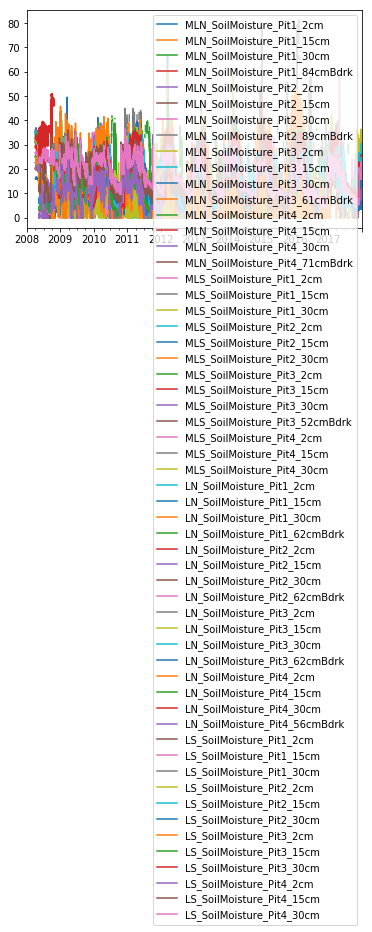

In [75]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilMositure data should be %
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100  # 
    #plt.figure()
    #df[[site]].plot()
SoilMoisture3 = copy.deepcopy(df)
SoilMoisture3 = threC(SoilMoisture3,'SoilMoisture') 
SoilMoisture3.plot()
SoilMoisture3.head(2)

### 12. SoilTemperature

In [76]:
BRW_ST = BRW_soil[[i for i in BRW_soil.columns if i.split('_')[1] == 'SoilTemperature']]
LDP_ST = LDP_soil[[i for i in LDP_soil.columns if i.split('_')[1] == 'SoilTemperature']]
SCR_ST = SCR_soil[[i for i in SCR_soil.columns if i.split('_')[1] == 'SoilTemperature']]
TL_ST = TL_soil[[i for i in TL_soil.columns if i.split('_')[1] == 'SoilTemperature']]
LW_ST = LW_soil[[i for i in LW_soil.columns if i.split('_')[1] == 'SoilTemperature']]
HN_ST = HN_soil[[i for i in HN_soil.columns if i.split('_')[1] == 'SoilTemperature']]
HS_ST = HS_soil[[i for i in HS_soil.columns if i.split('_')[1] == 'SoilTemperature']]
MHN_ST = MHN_soil[[i for i in MHN_soil.columns if i.split('_')[1] == 'SoilTemperature']]
MHS_ST = MHS_soil[[i for i in MHS_soil.columns if i.split('_')[1] == 'SoilTemperature']]
MLN_ST = MLN_soil[[i for i in MLN_soil.columns if i.split('_')[1] == 'SoilTemperature']]
MLS_ST = MLS_soil[[i for i in MLS_soil.columns if i.split('_')[1] == 'SoilTemperature']]
LN_ST = LN_soil[[i for i in LN_soil.columns if i.split('_')[1] == 'SoilTemperature']]
LS_ST = LS_soil[[i for i in LS_soil.columns if i.split('_')[1] == 'SoilTemperature']]

In [77]:
df_lst = [BRW_ST,LDP_ST,SCR_ST,TL_ST,LW_ST]
for df in df_lst:  
    display(df.head(2))
    df = threC(df,'SoilTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

BRW_SoilTemperature_L_5cm  BRW_SoilTemperature_L_15cm  \
DateTime                                                                  
11/24/2012 10:00                        0.3                         0.6   
11/24/2012 10:15                        0.3                         0.6   

                  BRW_SoilTemperature_L_30cm  BRW_SoilTemperature_L_81cm  \
DateTime                                                                   
11/24/2012 10:00                         1.6                         3.8   
11/24/2012 10:15                         1.6                         3.8   

                  BRW_SoilTemperature_U_5cm  BRW_SoilTemperature_U_15cm  \
DateTime                                                                  
11/24/2012 10:00                        0.0                         0.9   
11/24/2012 10:15                        0.0                         0.8   

                  BRW_SoilTemperature_U_30cm  BRW_SoilTemperature_U_55cm  
DateTime                                                                  
11/24/2012 10:00                         1.9                         3.3  
11/24/2012 10:15                         1.9                         3.3

(44461, 8)
2012-11-24 10:00:00 2018-01-05 12:00:00


LDP_SoilTemperature_W_2cm  LDP_SoilTemperature_W_6cm  \
DateTime                                                              
1/1/2007 0:00                    -6999.0                    -6999.0   
1/1/2007 1:00                    -6999.0                    -6999.0   

               LDP_SoilTemperature_E_2cm  LDP_SoilTemperature_E_6cm  \
DateTime                                                              
1/1/2007 0:00                    -6999.0                    -6999.0   
1/1/2007 1:00                    -6999.0                    -6999.0   

               LDP_SoilTemperature_2.5cm  LDP_SoilTemperature_20cm  \
DateTime                                                             
1/1/2007 0:00                    -6999.0                   -6999.0   
1/1/2007 1:00                    -6999.0                   -6999.0   

               LDP_SoilTemperature_33cm  
DateTime                                 
1/1/2007 0:00                   -6999.0  
1/1/2007 1:00                   -6999.0

(96432, 7)
2007-01-01 00:00:00 2017-12-31 23:00:00


SCR_SoilTemperature_5cm
DateTime                              
1/1/2012 0:00                  -6999.0
1/1/2012 1:00                  -6999.0

(55978, 1)
2012-01-01 00:00:00 2018-05-21 09:00:00


TL_SoilTemperature_P3_5cm  TL_SoilTemperature_P3_30cm  \
1/1/1999 0:00                    -6999.0                     -6999.0   
1/1/1999 1:00                    -6999.0                     -6999.0   

               TL_SoilTemperature_P3_60cm TL_SoilTemperature_P3_100cm  \
1/1/1999 0:00                     -6999.0                       -6999   
1/1/1999 1:00                     -6999.0                       -6999   

               TL_SoilTemperature_P4_5cm  TL_SoilTemperature_P4_15cm  \
1/1/1999 0:00                    -6999.0                     -6999.0   
1/1/1999 1:00                    -6999.0                     -6999.0   

               TL_SoilTemperature_P4_30cm  TL_SoilTemperature_P4_45cm  \
1/1/1999 0:00                     -6999.0                     -6999.0   
1/1/1999 1:00                     -6999.0                     -6999.0   

               TL_SoilTemperature_P4_65cm  
1/1/1999 0:00                     -6999.0  
1/1/1999 1:00                     -6999.0

(166814, 9)
1999-01-01 00:00:00 2017-12-31 23:00:00


LW_SoilTemperature_P1_5cm  LW_SoilTemperature_P1_15cm  \
DateTime                                                                  
01/01/1999 00:00                       -0.1                     -6999.0   
01/01/1999 01:00                        0.3                     -6999.0   

                  LW_SoilTemperature_P1_30cm  LW_SoilTemperature_P1_50cm  \
DateTime                                                                   
01/01/1999 00:00                     -6999.0                     -6999.0   
01/01/1999 01:00                     -6999.0                     -6999.0   

                  LW_SoilTemperature_P1_100cm  LW_SoilTemperature_P2_5cm  \
DateTime                                                                   
01/01/1999 00:00                      -6999.0                    -6999.0   
01/01/1999 01:00                      -6999.0                    -6999.0   

                  LW_SoilTemperature_P2_15cm  LW_SoilTemperature_P2_30cm  \
DateTime                                                                   
01/01/1999 00:00                     -6999.0                     -6999.0   
01/01/1999 01:00                     -6999.0                     -6999.0   

                  LW_SoilTemperature_P2_60cm  LW_SoilTemperature_P2_100cm  
DateTime                                                                   
01/01/1999 00:00                     -6999.0                      -6999.0  
01/01/1999 01:00                     -6999.0                      -6999.0

(175591, 10)
1999-01-01 00:00:00 2017-12-31 23:00:00


In [78]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

BRW_SoilTemperature_L_5cm  BRW_SoilTemperature_L_15cm  \
1999-01-01 00:00:00                        NaN                         NaN   
1999-01-01 01:00:00                        NaN                         NaN   

                     BRW_SoilTemperature_L_30cm  BRW_SoilTemperature_L_81cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     BRW_SoilTemperature_U_5cm  BRW_SoilTemperature_U_15cm  \
1999-01-01 00:00:00                        NaN                         NaN   
1999-01-01 01:00:00                        NaN                         NaN   

                     BRW_SoilTemperature_U_30cm  BRW_SoilTemperature_U_55cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     LDP_SoilTemperature_W_2cm  LDP_SoilTemperature_W_6cm  \
1999-01-01 00:00:00                        NaN                        NaN   
1999-01-01 01:00:00                        NaN                        NaN   

                     ...  LW_SoilTemperature_P1_5cm  \
1999-01-01 00:00:00  ...                       -0.1   
1999-01-01 01:00:00  ...                        0.3   

                     LW_SoilTemperature_P1_15cm  LW_SoilTemperature_P1_30cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     LW_SoilTemperature_P1_50cm  LW_SoilTemperature_P1_100cm  \
1999-01-01 00:00:00                         NaN                          NaN   
1999-01-01 01:00:00                         NaN                          NaN   

                     LW_SoilTemperature_P2_5cm  LW_SoilTemperature_P2_15cm  \
1999-01-01 00:00:00                        NaN                         NaN   
1999-01-01 01:00:00                        NaN                         NaN   

                     LW_SoilTemperature_P2_30cm  LW_SoilTemperature_P2_60cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     LW_SoilTemperature_P2_100cm  
1999-01-01 00:00:00                          NaN  
1999-01-01 01:00:00                          NaN  

[2 rows x 35 columns]

BRW_SoilTemperature_L_5cm  BRW_SoilTemperature_L_15cm  \
2018-05-21 08:00:00                        NaN                         NaN   
2018-05-21 09:00:00                        NaN                         NaN   

                     BRW_SoilTemperature_L_30cm  BRW_SoilTemperature_L_81cm  \
2018-05-21 08:00:00                         NaN                         NaN   
2018-05-21 09:00:00                         NaN                         NaN   

                     BRW_SoilTemperature_U_5cm  BRW_SoilTemperature_U_15cm  \
2018-05-21 08:00:00                        NaN                         NaN   
2018-05-21 09:00:00                        NaN                         NaN   

                     BRW_SoilTemperature_U_30cm  BRW_SoilTemperature_U_55cm  \
2018-05-21 08:00:00                         NaN                         NaN   
2018-05-21 09:00:00                         NaN                         NaN   

                     LDP_SoilTemperature_W_2cm  LDP_SoilTemperature_W_6cm  \
2018-05-21 08:00:00                        NaN                        NaN   
2018-05-21 09:00:00                        NaN                        NaN   

                     ...  LW_SoilTemperature_P1_5cm  \
2018-05-21 08:00:00  ...                        NaN   
2018-05-21 09:00:00  ...                        NaN   

                     LW_SoilTemperature_P1_15cm  LW_SoilTemperature_P1_30cm  \
2018-05-21 08:00:00                         NaN                         NaN   
2018-05-21 09:00:00                         NaN                         NaN   

                     LW_SoilTemperature_P1_50cm  LW_SoilTemperature_P1_100cm  \
2018-05-21 08:00:00                         NaN                          NaN   
2018-05-21 09:00:00                         NaN                          NaN   

                     LW_SoilTemperature_P2_5cm  LW_SoilTemperature_P2_15cm  \
2018-05-21 08:00:00                        NaN                         NaN   
2018-05-21 09:00:00                        NaN                         NaN   

                     LW_SoilTemperature_P2_30cm  LW_SoilTemperature_P2_60cm  \
2018-05-21 08:00:00                         NaN                         NaN   
2018-05-21 09:00:00                         NaN                         NaN   

                     LW_SoilTemperature_P2_100cm  
2018-05-21 08:00:00                          NaN  
2018-05-21 09:00:00                          NaN  

[2 rows x 35 columns]

BRW_SoilTemperature_L_5cm
BRW_SoilTemperature_L_15cm
BRW_SoilTemperature_L_30cm
BRW_SoilTemperature_L_81cm
BRW_SoilTemperature_U_5cm
BRW_SoilTemperature_U_15cm
BRW_SoilTemperature_U_30cm
BRW_SoilTemperature_U_55cm
LDP_SoilTemperature_W_2cm
LDP_SoilTemperature_W_6cm
LDP_SoilTemperature_E_2cm
LDP_SoilTemperature_E_6cm
LDP_SoilTemperature_2.5cm
LDP_SoilTemperature_20cm
LDP_SoilTemperature_33cm
SCR_SoilTemperature_5cm
TL_SoilTemperature_P3_5cm
TL_SoilTemperature_P3_30cm
TL_SoilTemperature_P3_60cm
TL_SoilTemperature_P3_100cm
TL_SoilTemperature_P4_5cm
TL_SoilTemperature_P4_15cm
TL_SoilTemperature_P4_30cm
TL_SoilTemperature_P4_45cm
TL_SoilTemperature_P4_65cm
LW_SoilTemperature_P1_5cm
LW_SoilTemperature_P1_15cm
LW_SoilTemperature_P1_30cm
LW_SoilTemperature_P1_50cm
LW_SoilTemperature_P1_100cm
LW_SoilTemperature_P2_5cm
LW_SoilTemperature_P2_15cm
LW_SoilTemperature_P2_30cm
LW_SoilTemperature_P2_60cm
LW_SoilTemperature_P2_100cm


BRW_SoilTemperature_L_5cm  BRW_SoilTemperature_L_15cm  \
1999-01-01 00:00:00                        NaN                         NaN   
1999-01-01 01:00:00                        NaN                         NaN   

                     BRW_SoilTemperature_L_30cm  BRW_SoilTemperature_L_81cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     BRW_SoilTemperature_U_5cm  BRW_SoilTemperature_U_15cm  \
1999-01-01 00:00:00                        NaN                         NaN   
1999-01-01 01:00:00                        NaN                         NaN   

                     BRW_SoilTemperature_U_30cm  BRW_SoilTemperature_U_55cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     LDP_SoilTemperature_W_2cm  LDP_SoilTemperature_W_6cm  \
1999-01-01 00:00:00                        NaN                        NaN   
1999-01-01 01:00:00                        NaN                        NaN   

                     ...  LW_SoilTemperature_P1_5cm  \
1999-01-01 00:00:00  ...                       -0.1   
1999-01-01 01:00:00  ...                        0.3   

                     LW_SoilTemperature_P1_15cm  LW_SoilTemperature_P1_30cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     LW_SoilTemperature_P1_50cm  LW_SoilTemperature_P1_100cm  \
1999-01-01 00:00:00                         NaN                          NaN   
1999-01-01 01:00:00                         NaN                          NaN   

                     LW_SoilTemperature_P2_5cm  LW_SoilTemperature_P2_15cm  \
1999-01-01 00:00:00                        NaN                         NaN   
1999-01-01 01:00:00                        NaN                         NaN   

                     LW_SoilTemperature_P2_30cm  LW_SoilTemperature_P2_60cm  \
1999-01-01 00:00:00                         NaN                         NaN   
1999-01-01 01:00:00                         NaN                         NaN   

                     LW_SoilTemperature_P2_100cm  
1999-01-01 00:00:00                          NaN  
1999-01-01 01:00:00                          NaN  

[2 rows x 35 columns]

<Figure size 720x288 with 0 Axes>

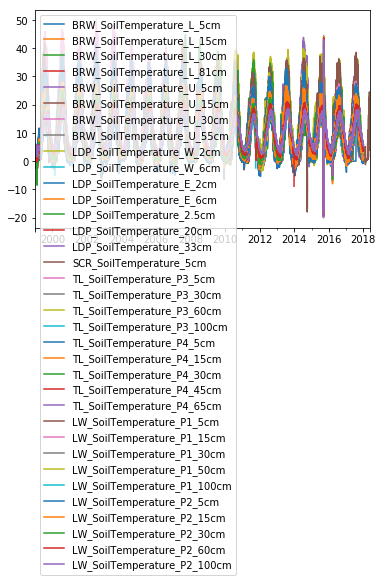

In [79]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilTemperature data should be degree celsius
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # 
    #plt.figure()
    #df[[site]].plot()
    
SoilTemperature1 = copy.deepcopy(df)
SoilTemperature1.plot()
SoilTemperature1.head(2)

In [80]:
df_lst = [HN_ST,HS_ST,MHN_ST,MHS_ST]
for df in df_lst:  
    display(df.head(2))
    df = threC(df,'SoilTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

HN_SoilTemperature_Pit1_2cm  HN_SoilTemperature_Pit1_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit1_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  HN_SoilTemperature_Pit1_37cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   

                  HN_SoilTemperature_Pit2_2cm  HN_SoilTemperature_Pit2_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit2_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  HN_SoilTemperature_Pit2_42cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   

                  HN_SoilTemperature_Pit3_2cm  HN_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit3_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  HN_SoilTemperature_Pit3_54cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   

                  HN_SoilTemperature_Pit4_2cm  HN_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  HN_SoilTemperature_Pit4_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  HN_SoilTemperature_Pit4_45cmBdrk  
DateTime                                            
01/01/2008 00:00                           -6999.0  
01/01/2008 01:00                           -6999.0

(87754, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


HS_SoilTemperature_Pit1_2cm  HS_SoilTemperature_Pit1_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   

               HS_SoilTemperature_Pit1_30cm  HS_SoilTemperature_Pit1_65cmBdrk  \
DateTime                                                                        
1/1/2008 0:00                       -6999.0                           -6999.0   
1/1/2008 1:00                       -6999.0                           -6999.0   

               HS_SoilTemperature_Pit2_2cm  HS_SoilTemperature_Pit2_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   

               HS_SoilTemperature_Pit2_30cm  HS_SoilTemperature_Pit2_70cmBdrk  \
DateTime                                                                        
1/1/2008 0:00                       -6999.0                           -6999.0   
1/1/2008 1:00                       -6999.0                           -6999.0   

               HS_SoilTemperature_Pit3_2cm  HS_SoilTemperature_Pit3_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   

               HS_SoilTemperature_Pit3_30cm  HS_SoilTemperature_Pit3_80cmBdrk  \
DateTime                                                                        
1/1/2008 0:00                       -6999.0                           -6999.0   
1/1/2008 1:00                       -6999.0                           -6999.0   

               HS_SoilTemperature_Pit4_2cm  HS_SoilTemperature_Pit4_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   

               HS_SoilTemperature_Pit4_30cm  HS_SoilTemperature_Pit4_77cmBdrk  
DateTime                                                                       
1/1/2008 0:00                       -6999.0                           -6999.0  
1/1/2008 1:00                       -6999.0                           -6999.0

(87648, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


MHN_SoilTemperature_Pit1_2cm  MHN_SoilTemperature_Pit1_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit1_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHN_SoilTemperature_Pit1_71cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MHN_SoilTemperature_Pit2_2cm  MHN_SoilTemperature_Pit2_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit2_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHN_SoilTemperature_Pit2_97cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MHN_SoilTemperature_Pit3_2cm  MHN_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit3_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHN_SoilTemperature_Pit3_52cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MHN_SoilTemperature_Pit4_2cm  MHN_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHN_SoilTemperature_Pit4_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHN_SoilTemperature_Pit4_74cmBdrk  
DateTime                                             
01/01/2008 00:00                            -6999.0  
01/01/2008 01:00                            -6999.0

(87754, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


MHS_SoilTemperature_Pit1_2cm  MHS_SoilTemperature_Pit1_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHS_SoilTemperature_Pit1_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHS_SoilTemperature_Pit1_70cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MHS_SoilTemperature_Pit2_2cm  MHS_SoilTemperature_Pit2_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHS_SoilTemperature_Pit2_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHS_SoilTemperature_Pit2_59cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MHS_SoilTemperature_Pit3_2cm  MHS_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHS_SoilTemperature_Pit3_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHS_SoilTemperature_Pit3_60cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MHS_SoilTemperature_Pit4_2cm  MHS_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MHS_SoilTemperature_Pit4_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MHS_SoilTemperature_Pit4_50cmBdrk  
DateTime                                             
01/01/2008 00:00                            -6999.0  
01/01/2008 01:00                            -6999.0

(83182, 16)
2008-01-01 00:00:00 2017-06-23 17:00:00


In [81]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

HN_SoilTemperature_Pit1_2cm  \
DateTime                                           
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     HN_SoilTemperature_Pit1_15cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit1_30cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit1_37cmBdrk  \
DateTime                                                
2008-01-01 00:00:00                               NaN   
2008-01-01 01:00:00                               NaN   

                     HN_SoilTemperature_Pit2_2cm  \
DateTime                                           
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     HN_SoilTemperature_Pit2_15cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit2_30cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit2_42cmBdrk  \
DateTime                                                
2008-01-01 00:00:00                               NaN   
2008-01-01 01:00:00                               NaN   

                     HN_SoilTemperature_Pit3_2cm  \
DateTime                                           
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     HN_SoilTemperature_Pit3_15cm  ...  \
DateTime                                           ...   
2008-01-01 00:00:00                           NaN  ...   
2008-01-01 01:00:00                           NaN  ...   

                     MHS_SoilTemperature_Pit2_30cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit2_59cmBdrk  \
DateTime                                                 
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MHS_SoilTemperature_Pit3_2cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MHS_SoilTemperature_Pit3_15cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit3_30cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit3_60cmBdrk  \
DateTime                                                 
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MHS_SoilTemperature_Pit4_2cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MHS_SoilTemperature_Pit4_15cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit4_30cm  \
DateTime                             

HN_SoilTemperature_Pit1_2cm  \
DateTime                                           
2017-12-31 22:00:00                          NaN   
2017-12-31 23:00:00                          NaN   

                     HN_SoilTemperature_Pit1_15cm  \
DateTime                                            
2017-12-31 22:00:00                           2.8   
2017-12-31 23:00:00                           2.8   

                     HN_SoilTemperature_Pit1_30cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     HN_SoilTemperature_Pit1_37cmBdrk  \
DateTime                                                
2017-12-31 22:00:00                               2.8   
2017-12-31 23:00:00                               2.8   

                     HN_SoilTemperature_Pit2_2cm  \
DateTime                                           
2017-12-31 22:00:00                          NaN   
2017-12-31 23:00:00                          NaN   

                     HN_SoilTemperature_Pit2_15cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     HN_SoilTemperature_Pit2_30cm  \
DateTime                                            
2017-12-31 22:00:00                           2.5   
2017-12-31 23:00:00                           2.5   

                     HN_SoilTemperature_Pit2_42cmBdrk  \
DateTime                                                
2017-12-31 22:00:00                               2.9   
2017-12-31 23:00:00                               3.2   

                     HN_SoilTemperature_Pit3_2cm  \
DateTime                                           
2017-12-31 22:00:00                          0.4   
2017-12-31 23:00:00                          0.4   

                     HN_SoilTemperature_Pit3_15cm  ...  \
DateTime                                           ...   
2017-12-31 22:00:00                           0.8  ...   
2017-12-31 23:00:00                           1.1  ...   

                     MHS_SoilTemperature_Pit2_30cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MHS_SoilTemperature_Pit2_59cmBdrk  \
DateTime                                                 
2017-12-31 22:00:00                                NaN   
2017-12-31 23:00:00                                NaN   

                     MHS_SoilTemperature_Pit3_2cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     MHS_SoilTemperature_Pit3_15cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MHS_SoilTemperature_Pit3_30cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MHS_SoilTemperature_Pit3_60cmBdrk  \
DateTime                                                 
2017-12-31 22:00:00                                NaN   
2017-12-31 23:00:00                                NaN   

                     MHS_SoilTemperature_Pit4_2cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     MHS_SoilTemperature_Pit4_15cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MHS_SoilTemperature_Pit4_30cm  \
DateTime                             

HN_SoilTemperature_Pit1_2cm
HN_SoilTemperature_Pit1_15cm
HN_SoilTemperature_Pit1_30cm
HN_SoilTemperature_Pit1_37cmBdrk
HN_SoilTemperature_Pit2_2cm
HN_SoilTemperature_Pit2_15cm
HN_SoilTemperature_Pit2_30cm
HN_SoilTemperature_Pit2_42cmBdrk
HN_SoilTemperature_Pit3_2cm
HN_SoilTemperature_Pit3_15cm
HN_SoilTemperature_Pit3_30cm
HN_SoilTemperature_Pit3_54cmBdrk
HN_SoilTemperature_Pit4_2cm
HN_SoilTemperature_Pit4_15cm
HN_SoilTemperature_Pit4_30cm
HN_SoilTemperature_Pit4_45cmBdrk
HS_SoilTemperature_Pit1_2cm
HS_SoilTemperature_Pit1_15cm
HS_SoilTemperature_Pit1_30cm
HS_SoilTemperature_Pit1_65cmBdrk
HS_SoilTemperature_Pit2_2cm
HS_SoilTemperature_Pit2_15cm
HS_SoilTemperature_Pit2_30cm
HS_SoilTemperature_Pit2_70cmBdrk
HS_SoilTemperature_Pit3_2cm
HS_SoilTemperature_Pit3_15cm
HS_SoilTemperature_Pit3_30cm
HS_SoilTemperature_Pit3_80cmBdrk
HS_SoilTemperature_Pit4_2cm
HS_SoilTemperature_Pit4_15cm
HS_SoilTemperature_Pit4_30cm
HS_SoilTemperature_Pit4_77cmBdrk
MHN_SoilTemperature_Pit1_2cm
MHN_SoilTemperature

HN_SoilTemperature_Pit1_2cm  \
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     HN_SoilTemperature_Pit1_15cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit1_30cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit1_37cmBdrk  \
2008-01-01 00:00:00                               NaN   
2008-01-01 01:00:00                               NaN   

                     HN_SoilTemperature_Pit2_2cm  \
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     HN_SoilTemperature_Pit2_15cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit2_30cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     HN_SoilTemperature_Pit2_42cmBdrk  \
2008-01-01 00:00:00                               NaN   
2008-01-01 01:00:00                               NaN   

                     HN_SoilTemperature_Pit3_2cm  \
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     HN_SoilTemperature_Pit3_15cm  ...  \
2008-01-01 00:00:00                           NaN  ...   
2008-01-01 01:00:00                           NaN  ...   

                     MHS_SoilTemperature_Pit2_30cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit2_59cmBdrk  \
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MHS_SoilTemperature_Pit3_2cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MHS_SoilTemperature_Pit3_15cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit3_30cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit3_60cmBdrk  \
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MHS_SoilTemperature_Pit4_2cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MHS_SoilTemperature_Pit4_15cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit4_30cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MHS_SoilTemperature_Pit4_50cmBdrk  
2008-01-01 00:00:00                                NaN  
2008-01-01 01:00:00                                NaN  

[2 rows x 64 columns]

<Figure size 720x288 with 0 Axes>

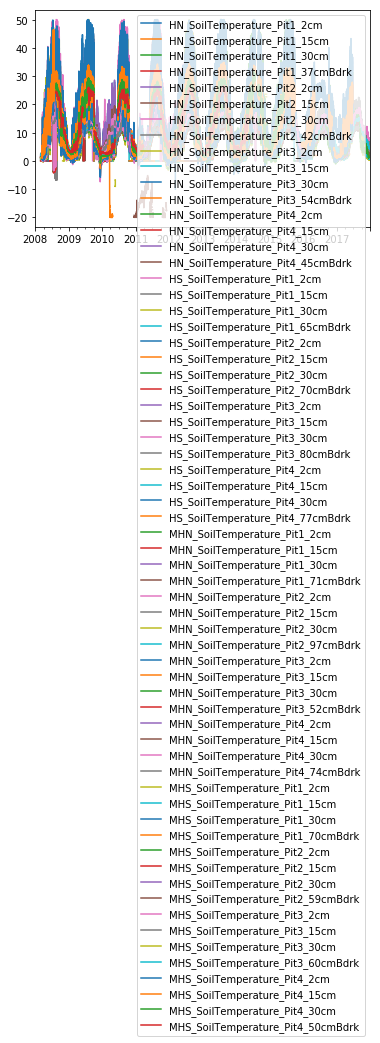

In [82]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilTemperature data should be degree celsius
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # 
    #plt.figure()
    #df[[site]].plot()
    
SoilTemperature2 = copy.deepcopy(df)
SoilTemperature2.plot()
SoilTemperature2.head(2)

In [83]:
df_lst = [MLN_ST,MLS_ST,LN_ST,LS_ST]
for df in df_lst:  
    display(df.head(2))
    df = threC(df,'SoilTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.Series(pd.to_datetime(df.index,errors = 'coerce')).apply(lambda x: x.replace(minute=0, second=0)) # round to whole hour
    #df = copy.deepcopy(dis_df.groupby(dis_df.index.date).mean())  # if daily data is wanted 
    print(df.shape)
    print(df.index[0],df.index[-1])

MLN_SoilTemperature_Pit1_2cm  MLN_SoilTemperature_Pit1_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MLN_SoilTemperature_Pit1_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MLN_SoilTemperature_Pit1_84cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MLN_SoilTemperature_Pit2_2cm  MLN_SoilTemperature_Pit2_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MLN_SoilTemperature_Pit2_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MLN_SoilTemperature_Pit2_89cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MLN_SoilTemperature_Pit3_2cm  MLN_SoilTemperature_Pit3_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MLN_SoilTemperature_Pit3_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MLN_SoilTemperature_Pit3_61cmBdrk  \
DateTime                                              
01/01/2008 00:00                            -6999.0   
01/01/2008 01:00                            -6999.0   

                  MLN_SoilTemperature_Pit4_2cm  MLN_SoilTemperature_Pit4_15cm  \
DateTime                                                                        
01/01/2008 00:00                       -6999.0                        -6999.0   
01/01/2008 01:00                       -6999.0                        -6999.0   

                  MLN_SoilTemperature_Pit4_30cm  \
DateTime                                          
01/01/2008 00:00                        -6999.0   
01/01/2008 01:00                        -6999.0   

                  MLN_SoilTemperature_Pit4_71cmBdrk  
DateTime                                             
01/01/2008 00:00                            -6999.0  
01/01/2008 01:00                            -6999.0

(79004, 16)
2008-01-01 00:00:00 2016-12-31 23:00:00


MLS_SoilTemperature_Pit1_2cm  MLS_SoilTemperature_Pit1_15cm  \
DateTime                                                                      
01/01/08 00:00                       -6999.0                        -6999.0   
01/01/08 01:00                       -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit1_30cm  MLS_SoilTemperature_Pit2_2cm  \
DateTime                                                                      
01/01/08 00:00                        -6999.0                       -6999.0   
01/01/08 01:00                        -6999.0                       -6999.0   

                MLS_SoilTemperature_Pit2_15cm  MLS_SoilTemperature_Pit2_30cm  \
DateTime                                                                       
01/01/08 00:00                        -6999.0                        -6999.0   
01/01/08 01:00                        -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit3_2cm  MLS_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
01/01/08 00:00                       -6999.0                        -6999.0   
01/01/08 01:00                       -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit3_30cm  \
DateTime                                        
01/01/08 00:00                        -6999.0   
01/01/08 01:00                        -6999.0   

                MLS_SoilTemperature_Pit3_52cmBdrk  \
DateTime                                            
01/01/08 00:00                            -6999.0   
01/01/08 01:00                            -6999.0   

                MLS_SoilTemperature_Pit4_2cm  MLS_SoilTemperature_Pit4_15cm  \
DateTime                                                                      
01/01/08 00:00                       -6999.0                        -6999.0   
01/01/08 01:00                       -6999.0                        -6999.0   

                MLS_SoilTemperature_Pit4_30cm  
DateTime                                       
01/01/08 00:00                        -6999.0  
01/01/08 01:00                        -6999.0

(87754, 13)
2008-01-01 00:00:00 2017-12-31 23:00:00


LN_SoilTemperature_Pit1_2cm  LN_SoilTemperature_Pit1_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  LN_SoilTemperature_Pit1_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  LN_SoilTemperature_Pit1_62cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   

                  LN_SoilTemperature_Pit2_2cm  LN_SoilTemperature_Pit2_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  LN_SoilTemperature_Pit2_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  LN_SoilTemperature_Pit2_62cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   

                  LN_SoilTemperature_Pit3_2cm  LN_SoilTemperature_Pit3_15cm  \
DateTime                                                                      
01/01/2008 00:00                      -6999.0                       -6999.0   
01/01/2008 01:00                      -6999.0                       -6999.0   

                  LN_SoilTemperature_Pit3_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  LN_SoilTemperature_Pit3_62cmBdrk  \
DateTime                                             
01/01/2008 00:00                           -6999.0   
01/01/2008 01:00                           -6999.0   

                 LN_SoilTemperature_Pit4_2cm  LN_SoilTemperature_Pit4_15cm  \
DateTime                                                                     
01/01/2008 00:00                       -6999                       -6999.0   
01/01/2008 01:00                       -6999                       -6999.0   

                  LN_SoilTemperature_Pit4_30cm  \
DateTime                                         
01/01/2008 00:00                       -6999.0   
01/01/2008 01:00                       -6999.0   

                  LN_SoilTemperature_Pit4_56cmBdrk  
DateTime                                            
01/01/2008 00:00                           -6999.0  
01/01/2008 01:00                           -6999.0

(87752, 16)
2008-01-01 00:00:00 2017-12-31 23:00:00


LS_SoilTemperature_Pit1_2cm  LS_SoilTemperature_Pit1_15cm  \
DateTime                                                                   
1/1/2008 0:00                      -6999.0                       -6999.0   
1/1/2008 1:00                      -6999.0                       -6999.0   

              LS_SoilTemperature_Pit1_30cm  LS_SoilTemperature_Pit2_2cm  \
DateTime                                                                  
1/1/2008 0:00                        -6999                      -6999.0   
1/1/2008 1:00                        -6999                      -6999.0   

               LS_SoilTemperature_Pit2_15cm  LS_SoilTemperature_Pit2_30cm  \
DateTime                                                                    
1/1/2008 0:00                       -6999.0                       -6999.0   
1/1/2008 1:00                       -6999.0                       -6999.0   

               LS_SoilTemperature_Pit3_2cm LS_SoilTemperature_Pit3_15cm  \
DateTime                                                                  
1/1/2008 0:00                      -6999.0                        -6999   
1/1/2008 1:00                      -6999.0                        -6999   

               LS_SoilTemperature_Pit3_30cm LS_SoilTemperature_Pit4_2cm  \
DateTime                                                                  
1/1/2008 0:00                       -6999.0                       -6999   
1/1/2008 1:00                       -6999.0                       -6999   

               LS_SoilTemperature_Pit4_15cm  LS_SoilTemperature_Pit4_30cm  
DateTime                                                                   
1/1/2008 0:00                       -6999.0                       -6999.0  
1/1/2008 1:00                       -6999.0                       -6999.0

(92993, 12)
2008-01-01 00:00:00 2017-12-31 23:00:00


In [84]:
prep = aggre_and_comb_hourly(df_lst,axis=1, func = "mean")

MLN_SoilTemperature_Pit1_2cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MLN_SoilTemperature_Pit1_15cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit1_30cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit1_84cmBdrk  \
DateTime                                                 
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MLN_SoilTemperature_Pit2_2cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MLN_SoilTemperature_Pit2_15cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit2_30cm  \
DateTime                                             
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit2_89cmBdrk  \
DateTime                                                 
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MLN_SoilTemperature_Pit3_2cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MLN_SoilTemperature_Pit3_15cm  ...  \
DateTime                                            ...   
2008-01-01 00:00:00                            NaN  ...   
2008-01-01 01:00:00                            NaN  ...   

                     LS_SoilTemperature_Pit1_30cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit2_2cm  \
DateTime                                           
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     LS_SoilTemperature_Pit2_15cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit2_30cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit3_2cm  \
DateTime                                           
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     LS_SoilTemperature_Pit3_15cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit3_30cm  \
DateTime                                            
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit4_2cm  \
DateTime                                           
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     LS_SoilTemperature_Pit4_15cm  \
DateTime                                            
2008-01-01 00

MLN_SoilTemperature_Pit1_2cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     MLN_SoilTemperature_Pit1_15cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MLN_SoilTemperature_Pit1_30cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MLN_SoilTemperature_Pit1_84cmBdrk  \
DateTime                                                 
2017-12-31 22:00:00                                NaN   
2017-12-31 23:00:00                                NaN   

                     MLN_SoilTemperature_Pit2_2cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     MLN_SoilTemperature_Pit2_15cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MLN_SoilTemperature_Pit2_30cm  \
DateTime                                             
2017-12-31 22:00:00                            NaN   
2017-12-31 23:00:00                            NaN   

                     MLN_SoilTemperature_Pit2_89cmBdrk  \
DateTime                                                 
2017-12-31 22:00:00                                NaN   
2017-12-31 23:00:00                                NaN   

                     MLN_SoilTemperature_Pit3_2cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     MLN_SoilTemperature_Pit3_15cm  ...  \
DateTime                                            ...   
2017-12-31 22:00:00                            NaN  ...   
2017-12-31 23:00:00                            NaN  ...   

                     LS_SoilTemperature_Pit1_30cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     LS_SoilTemperature_Pit2_2cm  \
DateTime                                           
2017-12-31 22:00:00                         -0.2   
2017-12-31 23:00:00                         -0.6   

                     LS_SoilTemperature_Pit2_15cm  \
DateTime                                            
2017-12-31 22:00:00                           7.7   
2017-12-31 23:00:00                           7.3   

                     LS_SoilTemperature_Pit2_30cm  \
DateTime                                            
2017-12-31 22:00:00                           7.9   
2017-12-31 23:00:00                           7.8   

                     LS_SoilTemperature_Pit3_2cm  \
DateTime                                           
2017-12-31 22:00:00                         -1.4   
2017-12-31 23:00:00                         -1.8   

                     LS_SoilTemperature_Pit3_15cm  \
DateTime                                            
2017-12-31 22:00:00                           NaN   
2017-12-31 23:00:00                           NaN   

                     LS_SoilTemperature_Pit3_30cm  \
DateTime                                            
2017-12-31 22:00:00                           7.6   
2017-12-31 23:00:00                           7.7   

                     LS_SoilTemperature_Pit4_2cm  \
DateTime                                           
2017-12-31 22:00:00                          NaN   
2017-12-31 23:00:00                          NaN   

                     LS_SoilTemperature_Pit4_15cm  \
DateTime                                            
2017-12-31 22

MLN_SoilTemperature_Pit1_2cm
MLN_SoilTemperature_Pit1_15cm
MLN_SoilTemperature_Pit1_30cm
MLN_SoilTemperature_Pit1_84cmBdrk
MLN_SoilTemperature_Pit2_2cm
MLN_SoilTemperature_Pit2_15cm
MLN_SoilTemperature_Pit2_30cm
MLN_SoilTemperature_Pit2_89cmBdrk
MLN_SoilTemperature_Pit3_2cm
MLN_SoilTemperature_Pit3_15cm
MLN_SoilTemperature_Pit3_30cm
MLN_SoilTemperature_Pit3_61cmBdrk
MLN_SoilTemperature_Pit4_2cm
MLN_SoilTemperature_Pit4_15cm
MLN_SoilTemperature_Pit4_30cm
MLN_SoilTemperature_Pit4_71cmBdrk
MLS_SoilTemperature_Pit1_2cm
MLS_SoilTemperature_Pit1_15cm
MLS_SoilTemperature_Pit1_30cm
MLS_SoilTemperature_Pit2_2cm
MLS_SoilTemperature_Pit2_15cm
MLS_SoilTemperature_Pit2_30cm
MLS_SoilTemperature_Pit3_2cm
MLS_SoilTemperature_Pit3_15cm
MLS_SoilTemperature_Pit3_30cm
MLS_SoilTemperature_Pit3_52cmBdrk
MLS_SoilTemperature_Pit4_2cm
MLS_SoilTemperature_Pit4_15cm
MLS_SoilTemperature_Pit4_30cm
LN_SoilTemperature_Pit1_2cm
LN_SoilTemperature_Pit1_15cm
LN_SoilTemperature_Pit1_30cm
LN_SoilTemperature_Pit1_62cmBdrk

MLN_SoilTemperature_Pit1_2cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MLN_SoilTemperature_Pit1_15cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit1_30cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit1_84cmBdrk  \
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MLN_SoilTemperature_Pit2_2cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MLN_SoilTemperature_Pit2_15cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit2_30cm  \
2008-01-01 00:00:00                            NaN   
2008-01-01 01:00:00                            NaN   

                     MLN_SoilTemperature_Pit2_89cmBdrk  \
2008-01-01 00:00:00                                NaN   
2008-01-01 01:00:00                                NaN   

                     MLN_SoilTemperature_Pit3_2cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     MLN_SoilTemperature_Pit3_15cm  ...  \
2008-01-01 00:00:00                            NaN  ...   
2008-01-01 01:00:00                            NaN  ...   

                     LS_SoilTemperature_Pit1_30cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit2_2cm  \
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     LS_SoilTemperature_Pit2_15cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit2_30cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit3_2cm  \
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     LS_SoilTemperature_Pit3_15cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit3_30cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit4_2cm  \
2008-01-01 00:00:00                          NaN   
2008-01-01 01:00:00                          NaN   

                     LS_SoilTemperature_Pit4_15cm  \
2008-01-01 00:00:00                           NaN   
2008-01-01 01:00:00                           NaN   

                     LS_SoilTemperature_Pit4_30cm  
2008-01-01 00:00:00                           NaN  
2008-01-01 01:00:00                           NaN  

[2 rows x 57 columns]

<Figure size 720x288 with 0 Axes>

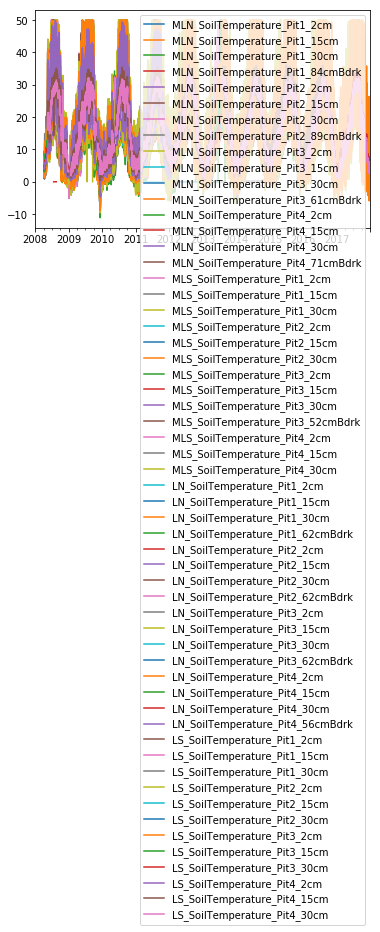

In [85]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilTemperature data should be degree celsius
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]), freq="60min")  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # 
    #plt.figure()
    #df[[site]].plot()
    
SoilTemperature3 = copy.deepcopy(df)
SoilTemperature3.plot()
SoilTemperature3.head(2)

### 13. Isotope

### All result

In [92]:
result = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity, 
                    WindDirection,WindSpeed,SnowDepth,
                    SoilMoisture1,SoilMoisture2,SoilMoisture3,
                    SoilTemperature1, SoilTemperature2, SoilTemperature3],
                    axis=1,join='outer')
result.index.rename('DateTime',inplace = True)
result.head()

TL_Discharge  BSG_Discharge  LG_Discharge  C1E_Discharge  \
DateTime                                                                        
1999-01-01 00:00:00           NaN            NaN           NaN            NaN   
1999-01-01 01:00:00           NaN            NaN           NaN            NaN   
1999-01-01 02:00:00           NaN            NaN           NaN            NaN   
1999-01-01 03:00:00           NaN            NaN           NaN            NaN   
1999-01-01 04:00:00           NaN            NaN           NaN            NaN   

                     C1W_Discharge  C2E_Discharge  C2M_Discharge  \
DateTime                                                           
1999-01-01 00:00:00            NaN            NaN            NaN   
1999-01-01 01:00:00            NaN            NaN            NaN   
1999-01-01 02:00:00            NaN            NaN            NaN   
1999-01-01 03:00:00            NaN            NaN            NaN   
1999-01-01 04:00:00            NaN            NaN            NaN   

                     BRW_Precipitation  LDP_Precipitation  SCR_Precipitation  \
DateTime                                                                       
1999-01-01 00:00:00                NaN                NaN                NaN   
1999-01-01 01:00:00                NaN                NaN                NaN   
1999-01-01 02:00:00                NaN                NaN                NaN   
1999-01-01 03:00:00                NaN                NaN                NaN   
1999-01-01 04:00:00                NaN                NaN                NaN   

                     ...  LS_SoilTemperature_Pit1_30cm  \
DateTime             ...                                 
1999-01-01 00:00:00  ...                           NaN   
1999-01-01 01:00:00  ...                           NaN   
1999-01-01 02:00:00  ...                           NaN   
1999-01-01 03:00:00  ...                           NaN   
1999-01-01 04:00:00  ...                           NaN   

                     LS_SoilTemperature_Pit2_2cm  \
DateTime                                           
1999-01-01 00:00:00                          NaN   
1999-01-01 01:00:00                          NaN   
1999-01-01 02:00:00                          NaN   
1999-01-01 03:00:00                          NaN   
1999-01-01 04:00:00                          NaN   

                     LS_SoilTemperature_Pit2_15cm  \
DateTime                                            
1999-01-01 00:00:00                           NaN   
1999-01-01 01:00:00                           NaN   
1999-01-01 02:00:00                           NaN   
1999-01-01 03:00:00                           NaN   
1999-01-01 04:00:00                           NaN   

                     LS_SoilTemperature_Pit2_30cm  \
DateTime                                            
1999-01-01 00:00:00                           NaN   
1999-01-01 01:00:00                           NaN   
1999-01-01 02:00:00                           NaN   
1999-01-01 03:00:00                           NaN   
1999-01-01 04:00:00                           NaN   

                     LS_SoilTemperature_Pit3_2cm  \
DateTime                                           
1999-01-01 00:00:00                          NaN   
1999-01-01 01:00:00                          NaN   
1999-01-01 02:00:00                          NaN   
1999-01-01 03:00:00                          NaN   
1999-01-01 04:00:00                          NaN   

                     LS_SoilTemperature_Pit3_15cm  \
DateTime                                            
1999-01-01 00:00:00                           NaN   
1999-01-01 01:00:00                           NaN   
1999-01-01 02:00:00                           NaN   
1999-01-01 03:00:00                           NaN   
1999-01-01 04:00:00                           NaN   

                     LS_SoilTemperature_Pit3_30cm  \
DateTime                                            
1999-01-01 00:00:00                           NaN   
199

In [93]:
result.tail()

TL_Discharge  BSG_Discharge  LG_Discharge  C1E_Discharge  \
DateTime                                                                        
2020-05-11 08:00:00           NaN            NaN           NaN            NaN   
2020-05-11 09:00:00           NaN            NaN           NaN            NaN   
2020-05-11 10:00:00           NaN            NaN           NaN            NaN   
2020-05-11 11:00:00           NaN            NaN           NaN            NaN   
2020-05-11 12:00:00           NaN            NaN           NaN            NaN   

                     C1W_Discharge  C2E_Discharge  C2M_Discharge  \
DateTime                                                           
2020-05-11 08:00:00            NaN            NaN            NaN   
2020-05-11 09:00:00            NaN            NaN            NaN   
2020-05-11 10:00:00            NaN            NaN            NaN   
2020-05-11 11:00:00            NaN            NaN            NaN   
2020-05-11 12:00:00            NaN            NaN            NaN   

                     BRW_Precipitation  LDP_Precipitation  SCR_Precipitation  \
DateTime                                                                       
2020-05-11 08:00:00                0.0                NaN                NaN   
2020-05-11 09:00:00                NaN                NaN                NaN   
2020-05-11 10:00:00                0.0                NaN                NaN   
2020-05-11 11:00:00                0.1                NaN                NaN   
2020-05-11 12:00:00                0.0                NaN                NaN   

                     ...  LS_SoilTemperature_Pit1_30cm  \
DateTime             ...                                 
2020-05-11 08:00:00  ...                           NaN   
2020-05-11 09:00:00  ...                           NaN   
2020-05-11 10:00:00  ...                           NaN   
2020-05-11 11:00:00  ...                           NaN   
2020-05-11 12:00:00  ...                           NaN   

                     LS_SoilTemperature_Pit2_2cm  \
DateTime                                           
2020-05-11 08:00:00                          NaN   
2020-05-11 09:00:00                          NaN   
2020-05-11 10:00:00                          NaN   
2020-05-11 11:00:00                          NaN   
2020-05-11 12:00:00                          NaN   

                     LS_SoilTemperature_Pit2_15cm  \
DateTime                                            
2020-05-11 08:00:00                           NaN   
2020-05-11 09:00:00                           NaN   
2020-05-11 10:00:00                           NaN   
2020-05-11 11:00:00                           NaN   
2020-05-11 12:00:00                           NaN   

                     LS_SoilTemperature_Pit2_30cm  \
DateTime                                            
2020-05-11 08:00:00                           NaN   
2020-05-11 09:00:00                           NaN   
2020-05-11 10:00:00                           NaN   
2020-05-11 11:00:00                           NaN   
2020-05-11 12:00:00                           NaN   

                     LS_SoilTemperature_Pit3_2cm  \
DateTime                                           
2020-05-11 08:00:00                          NaN   
2020-05-11 09:00:00                          NaN   
2020-05-11 10:00:00                          NaN   
2020-05-11 11:00:00                          NaN   
2020-05-11 12:00:00                          NaN   

                     LS_SoilTemperature_Pit3_15cm  \
DateTime                                            
2020-05-11 08:00:00                           NaN   
2020-05-11 09:00:00                           NaN   
2020-05-11 10:00:00                           NaN   
2020-05-11 11:00:00                           NaN   
2020-05-11 12:00:00                           NaN   

                     LS_SoilTemperature_Pit3_30cm  \
DateTime                                            
2020-05-11 08:00:00                           NaN   
202

In [94]:
result.to_csv('1_DryCreek_Download_Aggregation_hourly.csv', sep=',')